<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Extension/blob/main/Adult_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Adult Dataset - Predicting Income using Fine-tuning TL on Education

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C55S3H):

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [ ]:
X

age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2                Divorced  Handlers-cleaners   Not-in-family   
3      Married-civ-spouse  Handlers-cleaners         Husband   
4      Married-civ-spouse     Prof-specialty            Wife   
...                   ...                ...             ...   
48837            Divorced     Prof-specialty   Not-in-family   
48838             Widowed                NaN  Other-relative   
48839  Married-civ-spouse     Prof-specialty         Husband   
48840            Divorced       Adm-clerical       Own-child   
48841  Married-civ-spouse    Exec-managerial         Husband   

                     race     sex  capital-gain  capital-loss  hours-per-week  \
0                   White    Male          2174             0              40   
1                   White    Male             0             0              13   
2                   White    Male             0             0              40   
3                   Black    Male             0             0              40   
4                   Black  Female             0             0              40   
...                   ...     ...           ...           ...             ...   
48837               White  Female             0             0              36   
48838               Black    Male             0             0              40   
48839               White    Male             0             0              50   
48840  Asian-Pac-Islander    Male          5455             0              40   
48841               White    Male             0             0              60   

      native-country  
0      United-States  
1      United-States  
2      United-States  
3      United-States  
4               Cuba  
...              ...  
48837  United-States  
48838  United-States  
48839  United-States  
48840  United-States  
48841  United-States  

[48842 rows x 14 columns]

In [ ]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [ ]:
X.iloc[:,4].value_counts()

education-num
9     15784
10    10878
13     8025
14     2657
11     2061
7      1812
12     1601
6      1389
4       955
15      834
5       756
8       657
16      594
3       509
2       247
1        83
Name: count, dtype: int64

In [ ]:
X_numeric = pd.DataFrame()

## Age:
X_numeric['age'] = X['age']

## Working class:
X_numeric['workclass'] = X['workclass']
X_numeric['workclass'].replace(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', '?',
                                'Self-emp-inc', 'Without-pay', 'Never-worked'],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

## Fnlwgt:

X_numeric['fnlwgt'] = X['fnlwgt']

## Education:
X_numeric['education_num'] = X['education-num']

## Marital Status:
X_numeric['marital_status'] = X['marital-status']
X_numeric['marital_status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-civ-spouse',
                                     'Married-AF-spouse', 'Married-spouse-absent'],
                                    [0, 1, 2, 3, 4, 5, 6], inplace=True)

## Occupation:
X_numeric['occupation'] = X['occupation']
X_numeric['occupation'].replace(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty',
                                 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving',
                                 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', '?',
                                 'Protective-serv', 'Armed-Forces', 'Priv-house-serv'],
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], inplace=True)

## Relationship:
X_numeric['relationship'] = X['relationship']
X_numeric['relationship'].replace(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'],
                                    [0, 1, 2, 3, 4, 5], inplace=True)

## Race:
X_numeric['race'] = X['race']
X_numeric['race'].replace(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
                          [0, 1, 2, 3, 4], inplace=True)

## Sex:
X_numeric['sex'] = X['sex']
X_numeric['sex'].replace(['Male', 'Female'],
                          [0, 1], inplace=True)

## Capital Gain/Loss:
X_numeric['capital_gain'] = X['capital-gain']
X_numeric['capital_loss'] = X['capital-loss']


## Hours worked:
X_numeric['hours_per_week'] = X['hours-per-week']


## Nationality:
X_numeric['native_country'] = X['native-country']
X_numeric['native_country'].replace(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico', 'South',
                                     'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
                                     'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia', 'Thailand', 'Ecuador',
                                     'Laos', 'Taiwan', 'Haiti', 'Portugal', 'Dominican-Republic', 'El-Salvador',
                                     'France', 'Guatemala', 'China', 'Japan', 'Yugoslavia', 'Peru',
                                     'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago', 'Greece',
                                     'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary', 'Holand-Netherlands'],
                                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                      24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], inplace=True)



## Income:
y_numeric = pd.DataFrame()
y_numeric['Y'] = y['income']
y_numeric['Y'].replace(['<=50K', '<=50K.', '>50K', '>50K.'],
                          [0, 0, 1, 1], inplace=True)

X_numeric



<ipython-input-7-7c89fb899090>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numeric['workclass'].replace(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', '?',
<ipython-input-7-7c89fb899090>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_numeric['workclass'].replace(

age  workclass  fnlwgt  education_num  marital_status  occupation  \
0       39        0.0   77516             13               0         0.0   
1       50        1.0   83311             13               4         1.0   
2       38        2.0  215646              9               1         2.0   
3       53        2.0  234721              7               4         2.0   
4       28        2.0  338409             13               4         3.0   
...    ...        ...     ...            ...             ...         ...   
48837   39        2.0  215419             13               1         3.0   
48838   64        NaN  321403              9               3         NaN   
48839   38        2.0  374983             13               4         3.0   
48840   44        2.0   83891             13               1         0.0   
48841   35        6.0  182148             13               4         1.0   

       relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0                 0     0    0          2174             0              40   
1                 1     0    0             0             0              13   
2                 0     0    0             0             0              40   
3                 1     1    0             0             0              40   
4                 2     1    1             0             0              40   
...             ...   ...  ...           ...           ...             ...   
48837             0     0    1             0             0              36   
48838             5     1    0             0             0              40   
48839             1     0    0             0             0              50   
48840             3     2    0          5455             0              40   
48841             1     0    0             0             0              60   

       native_country  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 1.0  
...               ...  
48837             0.0  
48838             0.0  
48839             0.0  
48840             0.0  
48841             0.0  

[48842 rows x 13 columns]

In [ ]:
y_numeric

Y
0      0
1      0
2      0
3      0
4      0
...   ..
48837  0
48838  0
48839  0
48840  0
48841  1

[48842 rows x 1 columns]

In [ ]:
data_total = pd.concat([X_numeric, y_numeric], axis=1)

data_total = data_total.dropna().reset_index(drop=True)

education = []
for i in range(len(data_total)):
  if data_total['education_num'].iloc[i] > 12:  ## At least Bachelors
    education.append(1)
  else:
    education.append(0)

data_total['Y2'] = education

data_total = data_total.drop(columns=['education_num'])

data_total

age  workclass  fnlwgt  marital_status  occupation  relationship  race  \
0       39        0.0   77516               0         0.0             0     0   
1       50        1.0   83311               4         1.0             1     0   
2       38        2.0  215646               1         2.0             0     0   
3       53        2.0  234721               4         2.0             1     1   
4       28        2.0  338409               4         3.0             2     1   
...    ...        ...     ...             ...         ...           ...   ...   
47616   33        2.0  245211               0         3.0             3     0   
47617   39        2.0  215419               1         3.0             0     0   
47618   38        2.0  374983               4         3.0             1     0   
47619   44        2.0   83891               1         0.0             3     2   
47620   35        6.0  182148               4         1.0             1     0   

       sex  capital_gain  capital_loss  hours_per_week  native_country  Y  Y2  
0        0          2174             0              40             0.0  0   1  
1        0             0             0              13             0.0  0   1  
2        0             0             0              40             0.0  0   0  
3        0             0             0              40             0.0  0   0  
4        1             0             0              40             1.0  0   1  
...    ...           ...           ...             ...             ... ..  ..  
47616    0             0             0              40             0.0  0   1  
47617    1             0             0              36             0.0  0   1  
47618    0             0             0              50             0.0  0   1  
47619    0          5455             0              40             0.0  0   1  
47620    0             0             0              60             0.0  1   1  

[47621 rows x 14 columns]

In [ ]:
data_total['Y2'].value_counts()

Y2
0    35729
1    11892
Name: count, dtype: int64

In [ ]:
X = data_total.iloc[:, :-2]
y = data_total.iloc[:,-2]
y2 = data_total.iloc[:,-1]
y

0        0
1        0
2        0
3        0
4        0
        ..
47616    0
47617    0
47618    0
47619    0
47620    1
Name: Y, Length: 47621, dtype: int64

In [ ]:
y.value_counts()

Y
0    36080
1    11541
Name: count, dtype: int64

In [ ]:
y2.value_counts()

Y2
0    35729
1    11892
Name: count, dtype: int64

In [ ]:
X.iloc[:,7].value_counts()

sex
0    31937
1    15684
Name: count, dtype: int64

In [ ]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [ ]:
data2 = pd.concat([X_scaled, y, y2], axis=1)
data2

0      1         2         3         4    5     6    7  \
0      0.301370  0.000  0.044131  0.000000  0.000000  0.0  0.00  0.0   
1      0.452055  0.125  0.048052  0.666667  0.071429  0.2  0.00  0.0   
2      0.287671  0.250  0.137581  0.166667  0.142857  0.0  0.00  0.0   
3      0.493151  0.250  0.150486  0.666667  0.142857  0.2  0.25  0.0   
4      0.150685  0.250  0.220635  0.666667  0.214286  0.4  0.25  1.0   
...         ...    ...       ...       ...       ...  ...   ...  ...   
47616  0.219178  0.250  0.157583  0.000000  0.214286  0.6  0.00  0.0   
47617  0.301370  0.250  0.137428  0.166667  0.214286  0.0  0.00  1.0   
47618  0.287671  0.250  0.245379  0.666667  0.214286  0.2  0.00  0.0   
47619  0.369863  0.250  0.048444  0.166667  0.000000  0.6  0.50  0.0   
47620  0.246575  0.750  0.114919  0.666667  0.071429  0.2  0.00  0.0   

              8    9        10       11  Y  Y2  
0      0.021740  0.0  0.397959  0.00000  0   1  
1      0.000000  0.0  0.122449  0.00000  0   1  
2      0.000000  0.0  0.397959  0.00000  0   0  
3      0.000000  0.0  0.397959  0.00000  0   0  
4      0.000000  0.0  0.397959  0.02439  0   1  
...         ...  ...       ...      ... ..  ..  
47616  0.000000  0.0  0.397959  0.00000  0   1  
47617  0.000000  0.0  0.357143  0.00000  0   1  
47618  0.000000  0.0  0.500000  0.00000  0   1  
47619  0.054551  0.0  0.397959  0.00000  0   1  
47620  0.000000  0.0  0.602041  0.00000  1   1  

[47621 rows x 14 columns]

In [ ]:
y.value_counts()

Y
0    36080
1    11541
Name: count, dtype: int64

In [ ]:
y2.value_counts()

Y2
0    35729
1    11892
Name: count, dtype: int64

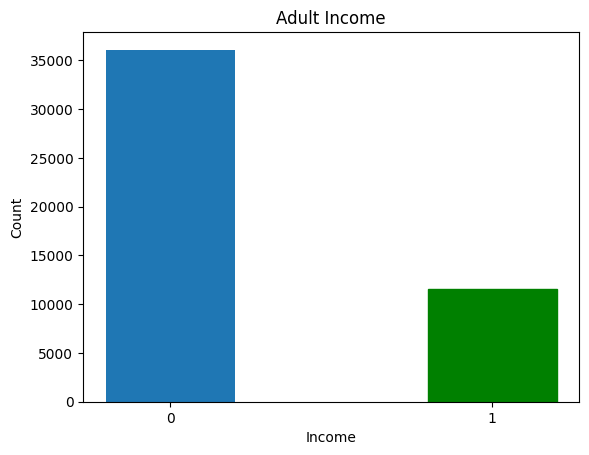

In [ ]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("Count")
plt.title("Adult Income")
plt.show()

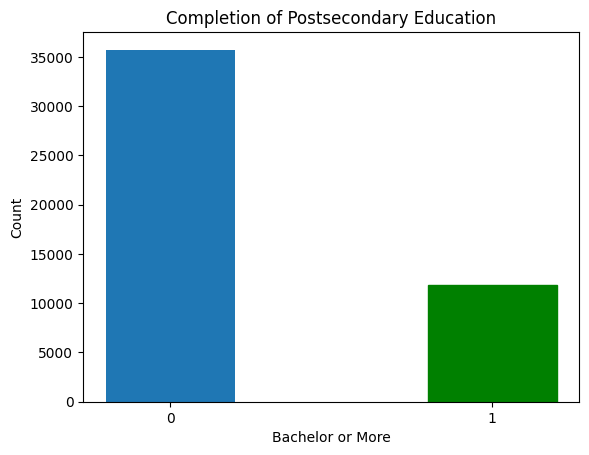

In [ ]:
barlist = plt.bar([str(0),str(1)], y2.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Bachelor or More")
plt.ylabel("Count")
plt.title("Completion of Postsecondary Education")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:

For the Heart Disease prediction, we split the dataset between low education level (**now including high-school dropouts**) and the high education level. The high-education data (with diabetes as response variable/label) becomes the source data and the low-education data (with Heart Disease as response variable/label) is the target data.

In [ ]:
data_total['sex'].value_counts()

sex
0    31937
1    15684
Name: count, dtype: int64

In [ ]:
data2[7].value_counts()  ## Splitting into source and target datasets based on 'Attendance daytime/evening' status

7
0.0    31937
1.0    15684
Name: count, dtype: int64

In [ ]:
data_S = data2[data2[7] <= 0.5].reset_index(drop=True)  ## Source domain and classification - Men
data_S_X = data_S.iloc[:,:-2]
data_S_y = data_S.iloc[:, -1]

data_S_full = pd.concat([data_S_X, data_S_y], axis=1)

data_T = data2[data2[7] > 0.5].reset_index(drop=True) ## Target domain and classification - Women

data_T_X = data_T.iloc[:,:-2]
data_T_y = data_T.iloc[:, -2]    ## Response variable of interest in Default

data_T_full = pd.concat([data_T_X, data_T_y], axis=1)

In [ ]:
data_S_full

0      1         2         3         4    5     6    7  \
0      0.301370  0.000  0.044131  0.000000  0.000000  0.0  0.00  0.0   
1      0.452055  0.125  0.048052  0.666667  0.071429  0.2  0.00  0.0   
2      0.287671  0.250  0.137581  0.166667  0.142857  0.0  0.00  0.0   
3      0.493151  0.250  0.150486  0.666667  0.142857  0.2  0.25  0.0   
4      0.479452  0.125  0.133519  0.666667  0.071429  0.2  0.00  0.0   
...         ...    ...       ...       ...       ...  ...   ...  ...   
31932  0.424658  0.500  0.227956  0.166667  0.285714  0.0  0.00  0.0   
31933  0.219178  0.250  0.157583  0.000000  0.214286  0.6  0.00  0.0   
31934  0.287671  0.250  0.245379  0.666667  0.214286  0.2  0.00  0.0   
31935  0.369863  0.250  0.048444  0.166667  0.000000  0.6  0.50  0.0   
31936  0.246575  0.750  0.114919  0.666667  0.071429  0.2  0.00  0.0   

              8    9        10   11  Y2  
0      0.021740  0.0  0.397959  0.0   1  
1      0.000000  0.0  0.122449  0.0   1  
2      0.000000  0.0  0.397959  0.0   0  
3      0.000000  0.0  0.397959  0.0   0  
4      0.000000  0.0  0.448980  0.0   0  
...         ...  ...       ...  ...  ..  
31932  0.000000  0.0  0.397959  0.0   1  
31933  0.000000  0.0  0.397959  0.0   1  
31934  0.000000  0.0  0.500000  0.0   1  
31935  0.054551  0.0  0.397959  0.0   1  
31936  0.000000  0.0  0.602041  0.0   1  

[31937 rows x 13 columns]

In [ ]:
data_T_full

0     1         2         3         4    5     6    7         8  \
0      0.150685  0.25  0.220635  0.666667  0.214286  0.4  0.25  1.0  0.000000   
1      0.273973  0.25  0.184219  0.666667  0.071429  0.4  0.00  1.0  0.000000   
2      0.438356  0.25  0.100061  1.000000  0.285714  0.0  0.25  1.0  0.000000   
3      0.191781  0.25  0.022661  0.000000  0.214286  0.0  0.00  1.0  0.140841   
4      0.082192  0.25  0.074410  0.000000  0.000000  0.6  0.00  1.0  0.000000   
...         ...   ...       ...       ...       ...  ...   ...  ...       ...   
15679  0.136986  0.25  0.282830  0.000000  0.357143  0.0  0.00  1.0  0.000000   
15680  0.520548  0.25  0.143676  0.333333  1.000000  0.0  0.00  1.0  0.000000   
15681  0.287671  0.25  0.159164  0.000000  0.000000  0.8  0.25  1.0  0.000000   
15682  0.109589  0.25  0.229138  0.000000  0.285714  0.6  0.00  1.0  0.000000   
15683  0.301370  0.25  0.137428  0.166667  0.214286  0.0  0.00  1.0  0.000000   

         9        10       11  Y  
0      0.0  0.397959  0.02439  0  
1      0.0  0.397959  0.00000  0  
2      0.0  0.153061  0.04878  0  
3      0.0  0.500000  0.00000  1  
4      0.0  0.295918  0.00000  0  
...    ...       ...      ... ..  
15679  0.0  0.448980  0.00000  0  
15680  0.0  0.316327  0.00000  0  
15681  0.0  0.397959  0.00000  0  
15682  0.0  0.397959  0.00000  0  
15683  0.0  0.357143  0.00000  0  

[15684 rows x 13 columns]

## Source domain and task labels:

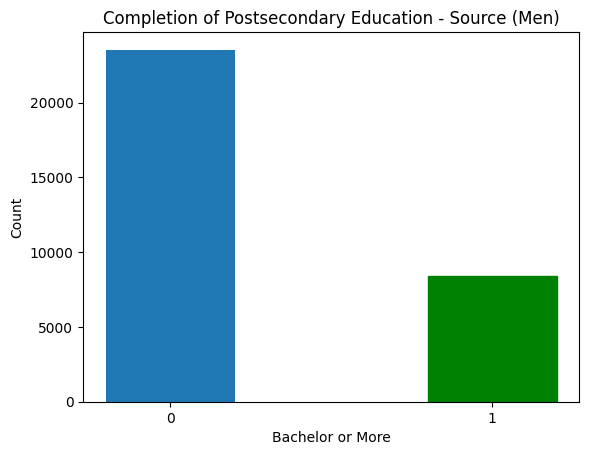

In [ ]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Bachelor or More")
plt.ylabel("Count")
plt.title("Completion of Postsecondary Education - Source (Men)")
plt.show()

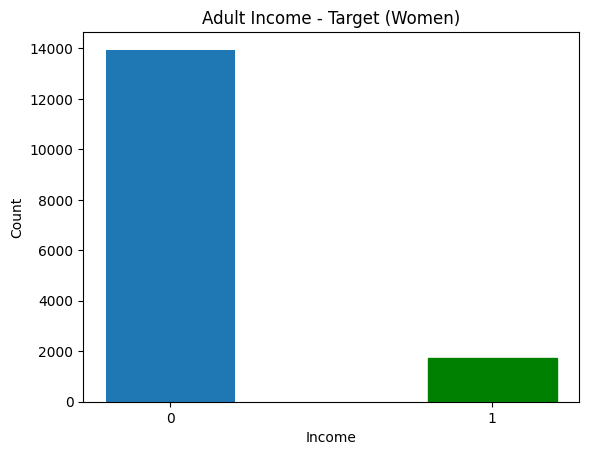

In [ ]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("Count")
plt.title("Adult Income - Target (Women)")
plt.show()

## Updated Code (Modified from Shreya's code):

In [ ]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  model.summary()
  print(len(model.layers))

  return model

# def create_dnn_model(input_shape):
#   model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
#     ])

#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

#   return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    model.save('model.h5')
    model.save_weights('model_wt.weights.h5')

    return model


In [ ]:
def train_and_evaluate_nosave(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])

    print(fpr)
    print(fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return fpr, fnr


In [ ]:
def fine_tuning(X_train, X_test, y_train, y_test, llim, ulim):
    new_model = create_dnn_model(X_S_train.shape[1])
    # new_model = tf.keras.models.load_model('model.h5')
    new_model.load_weights('model_wt.weights.h5')

    for layer in new_model.layers[llim:ulim]:
        layer.trainable = False
    for layer in new_model.layers[-1:]:
        layer.trainable = False

    for layer in new_model.layers:
        if layer.trainable == True:
          print("Trainable")
        else:
          print("Not Trainable")

    fpr, fnr = train_and_evaluate_nosave(new_model, X_train, X_test, y_train, y_test, "Target")
    return fpr, fnr

In [ ]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

# Over/undersampling functions:

## Undersampling functions:

In [ ]:
import random

def SRS_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def SRSwR_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :-1]
    y_SRS = data_SRS_RUS.iloc[:, -1]

    return X_SRS, y_SRS


def systematic_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.randint(1, int(k))
    print(start)
    Row = []
    for i in range(undersample_size):
      row = start+int(k*i)-1
      Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy



def multi_systematic_undersampler(data, data_column, m):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.sample(range(1, int(k*m)), m)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/m)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :-1]
    y_Sy = data_Sy_RUS.iloc[:, -1]

    return X_Sy, y_Sy

## Oversampling functions:

In [ ]:
def SRSwR_oversampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_SRS = data_SRS_ROS.iloc[:, :-1]
    y_SRS = data_SRS_ROS.iloc[:, -1]

    return X_SRS, y_SRS

# data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)


def systematic_resampler(data, data_column, k):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    Nsamples = k*(oversample_size-undersample_size)/undersample_size
    print('Nsamples=', Nsamples)

    np.random.seed(123)
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]

    data_Sy_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_Sy = data_Sy_ROS.iloc[:, :-1]
    y_Sy = data_Sy_ROS.iloc[:, -1]

    return X_Sy, y_Sy

# k = 48

# Nsamples = k*(oversample_size-undersample_size)/undersample_size
# # print(Nsamples)

# np.random.seed(123)
# start = np.random.choice(int(k), int(Nsamples), replace=True)
# # print(start)


# Row = []

# for j in range(len(start)):
#   for i in range(int(undersample_size/k)):
#     row = start[j]+int(k*i)-1
#     Row.append(row)

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

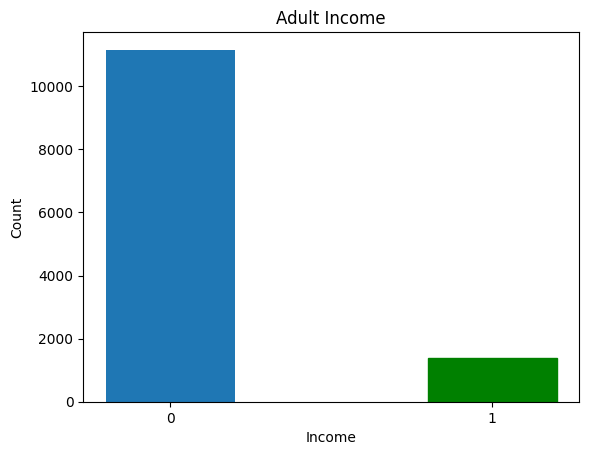

In [ ]:
barlist = plt.bar([str(0),str(1)], y_T_train.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("Count")
plt.title("Adult Income")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (25549, 12)
y_S_train: (25549,)
X_S_test: (6388, 12)
y_S_test: (6388,)


# Original (Imbalanced) dataset:

## Standard Machine Learning:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - AUC: 0.6177 - loss: 0.3909 - val_AUC: 0.8733 - val_loss: 0.2608
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8683 - loss: 0.2467 - val_AUC: 0.8985 - val_loss: 0.2336
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.2221 - val_AUC: 0.8976 - val_loss: 0.2352
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8915 - loss: 0.2241 - val_AUC: 0.9021 - val_loss: 0.2261
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9029 - loss: 0.2100 - val_AUC: 0.9031 - val_loss: 0.2241
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9037 - loss: 0.2117 - val_AUC: 0.8971 - val_loss: 0.2265
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9115 - loss: 0.2017 - val_AUC: 0.8988 - val_loss: 0.2311
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9084 - loss: 0.2019 - val_AUC: 0.9026 - val_loss: 0.2326
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

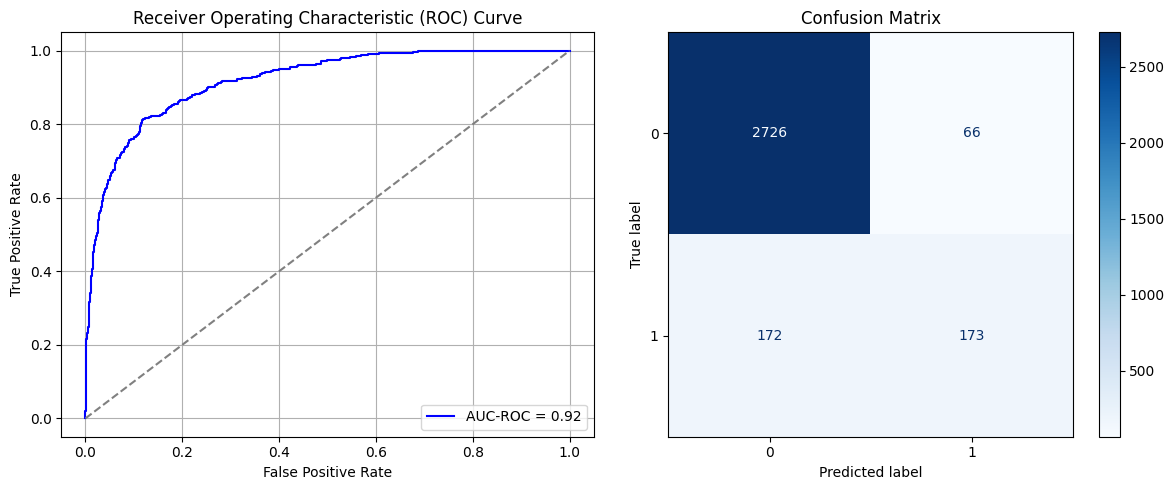

Best threshold based on F1-score: 0.40365922451019287
Time elapsed (performance): 25.741484764999996


<Sequential name=sequential, built=True>

In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])
train_and_evaluate(model_source, X_T_train, X_T_test, y_T_train, y_T_test, "Target")

## With Transfer Learning:

In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - AUC: 0.6826 - loss: 0.5413 - val_AUC: 0.7624 - val_loss: 0.4936
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7702 - loss: 0.4801 - val_AUC: 0.7954 - val_loss: 0.4761
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7976 - loss: 0.4628 - val_AUC: 0.8016 - val_loss: 0.4546
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8133 - loss: 0.4438 - val_AUC: 0.8155 - val_loss: 0.4486
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8169 - loss: 0.4389 - val_AUC: 0.8184 - val_loss: 0.4479
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8253 - loss: 0.4306 - val_AUC: 0.8280 - val_loss: 0.4322
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8330 - loss: 0.4176 - val_AUC: 0.8396 - val_loss: 0.4234
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8471 - loss: 0.4110 - val_AUC: 0.8429 - val_loss: 0.4184
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AU

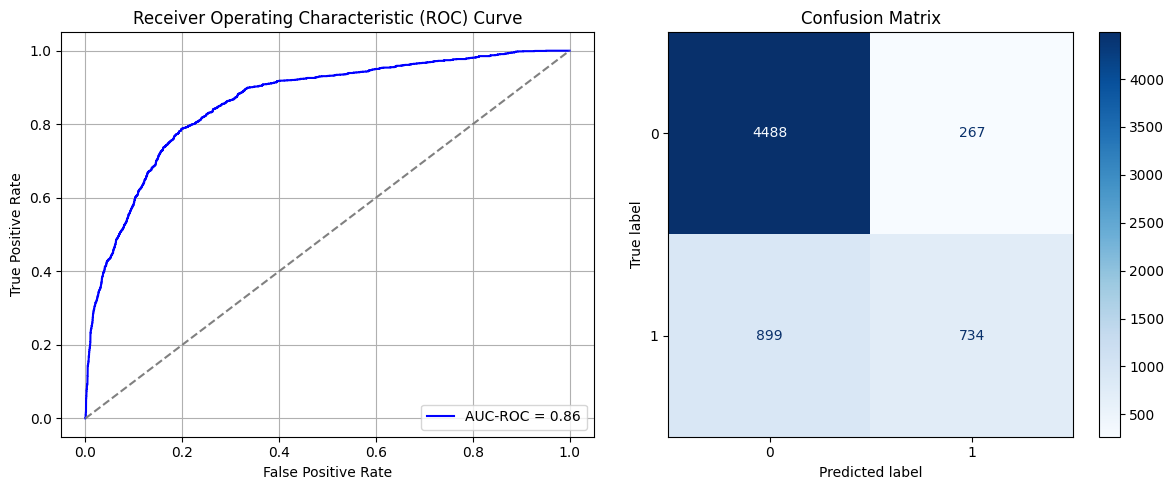

<ipython-input-46-93669339d7ff>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9664831757545471
Time elapsed (performance): 37.06733288500004


<Sequential name=sequential_1, built=True>

In [ ]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
# model_source.save('model_source.h5')
# model_source.save_weights('model_wt.weights.h5')

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.6852933848262116
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2792
           1       0.22      0.34      0.26       345

    accuracy                           0.79      3137
   macro avg       0.56      0.59      0.57      3137
weighted avg       0.84      0.79      0.81      3137

FPR 0.1504297994269341 TPR: 0.336231884057971 FNR: 0.663768115942029 TNR: 0.8495702005730659


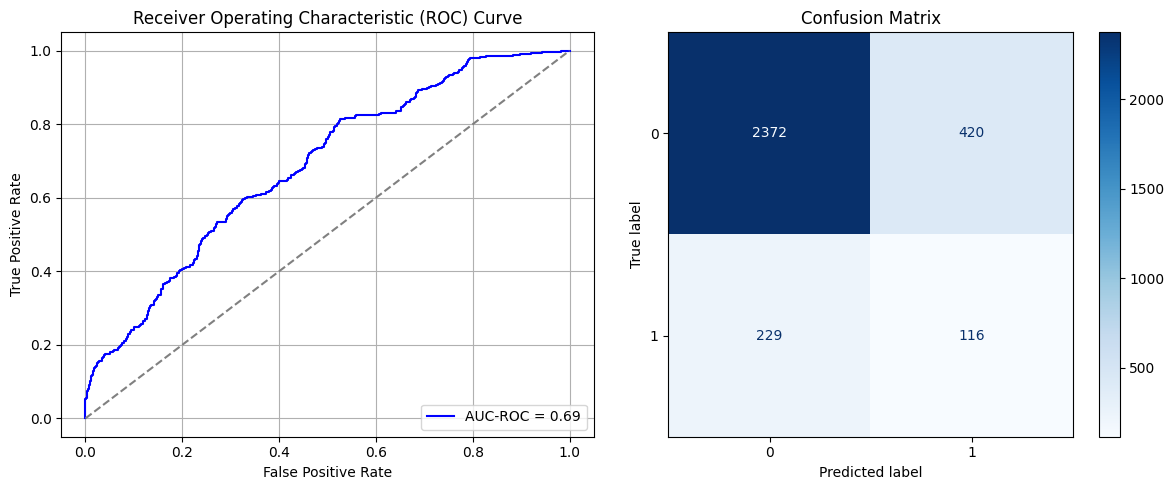

Best threshold based on F1-score: 0.2665976881980896
False Negative Rate: 0.663768115942029
Time elapsed (performance): 0.9673048699999072


In [ ]:
Transductive_TL(model_source, X_T_test, y_T_test, "Target")

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7087 - loss: 0.3300 - val_AUC: 0.7508 - val_loss: 0.3190
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7497 - loss: 0.2960 - val_AUC: 0.7714 - val_loss: 0.3101
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7789 - loss: 0.2872 - val_AUC: 0.7801 - val_loss: 0.3052
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7839 - loss: 0.2850 - val_AUC: 0.7864 - val_loss: 0.3052
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7837 - loss: 0.2861 - val_AUC: 0.7914 - val_loss: 0.3033
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7908 - loss: 0.2777 - val_AUC: 0.7964 - val_loss: 0.2992
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7930 - loss: 0.2831 - val_AUC: 0.7983 - val_loss: 0.2966
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7992 - loss: 0.2720 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.7046 - loss: 0.3226 - val_AUC: 0.7526 - val_loss: 0.3182
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7653 - loss: 0.2951 - val_AUC: 0.7713 - val_loss: 0.3104
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7609 - loss: 0.2900 - val_AUC: 0.7818 - val_loss: 0.3063
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7727 - loss: 0.2936 - val_AUC: 0.7839 - val_loss: 0.3036
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7866 - loss: 0.2904 - val_AUC: 0.7851 - val_loss: 0.3040
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7868 - loss: 0.2810 - val_AUC: 0.7959 - val_loss: 0.2993
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7992 - loss: 0.2833 - val_AUC: 0.7894 - val_loss: 0.3007
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8065 - loss: 0.2743 - val_AUC: 0.7957 - val_loss: 0.2979
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7988 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7073 - loss: 0.3285 - val_AUC: 0.7491 - val_loss: 0.3190
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7450 - loss: 0.2978 - val_AUC: 0.7675 - val_loss: 0.3107
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7770 - loss: 0.2843 - val_AUC: 0.7814 - val_loss: 0.3101
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7783 - loss: 0.2849 - val_AUC: 0.7832 - val_loss: 0.3045
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7782 - loss: 0.2910 - val_AUC: 0.7868 - val_loss: 0.3025
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7883 - loss: 0.2799 - val_AUC: 0.7912 - val_loss: 0.3008
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7983 - loss: 0.2761 - val_AUC: 0.7978 - val_loss: 0.2975
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7926 - loss: 0.2738 - val_AUC: 0.7971 - val_loss: 0.2995
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8086 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6965 - loss: 0.3302 - val_AUC: 0.7479 - val_loss: 0.3207
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7551 - loss: 0.2969 - val_AUC: 0.7723 - val_loss: 0.3101
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7741 - loss: 0.2934 - val_AUC: 0.7777 - val_loss: 0.3070
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7660 - loss: 0.2752 - val_AUC: 0.7832 - val_loss: 0.3044
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7834 - loss: 0.2751 - val_AUC: 0.7916 - val_loss: 0.3004
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7865 - loss: 0.2809 - val_AUC: 0.7899 - val_loss: 0.3020
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8004 - loss: 0.2874 - val_AUC: 0.7885 - val_loss: 0.3005
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8020 - loss: 0.2846 - val_AUC: 0.8093 - val_loss: 0.2953
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7958 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6891 - loss: 0.3340 - val_AUC: 0.7463 - val_loss: 0.3211
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7644 - loss: 0.2828 - val_AUC: 0.7717 - val_loss: 0.3096
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7727 - loss: 0.2910 - val_AUC: 0.7749 - val_loss: 0.3087
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7874 - loss: 0.2908 - val_AUC: 0.7828 - val_loss: 0.3040
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7886 - loss: 0.2832 - val_AUC: 0.7885 - val_loss: 0.3015
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7927 - loss: 0.2778 - val_AUC: 0.7957 - val_loss: 0.2991
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7930 - loss: 0.2858 - val_AUC: 0.7916 - val_loss: 0.3009
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7892 - loss: 0.2774 - val_AUC: 0.8043 - val_loss: 0.2956
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7872 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.7031 - loss: 0.3347 - val_AUC: 0.7523 - val_loss: 0.3187
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7641 - loss: 0.2967 - val_AUC: 0.7760 - val_loss: 0.3112
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7693 - loss: 0.2843 - val_AUC: 0.7789 - val_loss: 0.3068
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7903 - loss: 0.2867 - val_AUC: 0.7850 - val_loss: 0.3030
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7866 - loss: 0.2889 - val_AUC: 0.7920 - val_loss: 0.3005
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7834 - loss: 0.2853 - val_AUC: 0.7949 - val_loss: 0.2991
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7993 - loss: 0.2825 - val_AUC: 0.8021 - val_loss: 0.2972
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7859 - loss: 0.2910 - val_AUC: 0.8010 - val_loss: 0.2956
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8058 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6954 - loss: 0.3263 - val_AUC: 0.7433 - val_loss: 0.3217
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7459 - loss: 0.2954 - val_AUC: 0.7692 - val_loss: 0.3102
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7733 - loss: 0.2900 - val_AUC: 0.7816 - val_loss: 0.3088
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7844 - loss: 0.2848 - val_AUC: 0.7855 - val_loss: 0.3033
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7869 - loss: 0.2866 - val_AUC: 0.7889 - val_loss: 0.3031
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7878 - loss: 0.2833 - val_AUC: 0.7933 - val_loss: 0.3036
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7890 - loss: 0.2899 - val_AUC: 0.8018 - val_loss: 0.2999
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7909 - loss: 0.2839 - val_AUC: 0.7978 - val_loss: 0.2971
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8032 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.7111 - loss: 0.3221 - val_AUC: 0.7499 - val_loss: 0.3197
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7454 - loss: 0.3026 - val_AUC: 0.7735 - val_loss: 0.3098
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7749 - loss: 0.2932 - val_AUC: 0.7807 - val_loss: 0.3085
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7755 - loss: 0.2820 - val_AUC: 0.7858 - val_loss: 0.3039
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7774 - loss: 0.2900 - val_AUC: 0.7888 - val_loss: 0.3035
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7996 - loss: 0.2706 - val_AUC: 0.7900 - val_loss: 0.3006
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7905 - loss: 0.2851 - val_AUC: 0.8006 - val_loss: 0.2968
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8086 - loss: 0.2670 - val_AUC: 0.8040 - val_loss: 0.2949
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8131 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6990 - loss: 0.3309 - val_AUC: 0.7486 - val_loss: 0.3204
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7658 - loss: 0.2944 - val_AUC: 0.7742 - val_loss: 0.3095
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7812 - loss: 0.2919 - val_AUC: 0.7666 - val_loss: 0.3098
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7889 - loss: 0.2761 - val_AUC: 0.7851 - val_loss: 0.3043
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7950 - loss: 0.2817 - val_AUC: 0.7863 - val_loss: 0.3028
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7945 - loss: 0.2797 - val_AUC: 0.7880 - val_loss: 0.3010
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7921 - loss: 0.2790 - val_AUC: 0.7973 - val_loss: 0.2990
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7935 - loss: 0.2740 - val_AUC: 0.8019 - val_loss: 0.2955
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8015 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.7046 - loss: 0.3318 - val_AUC: 0.7483 - val_loss: 0.3203
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7556 - loss: 0.2922 - val_AUC: 0.7681 - val_loss: 0.3113
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7656 - loss: 0.2893 - val_AUC: 0.7810 - val_loss: 0.3054
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7852 - loss: 0.2842 - val_AUC: 0.7874 - val_loss: 0.3034
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7856 - loss: 0.2809 - val_AUC: 0.7949 - val_loss: 0.2996
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7997 - loss: 0.2706 - val_AUC: 0.7954 - val_loss: 0.3000
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7989 - loss: 0.2787 - val_AUC: 0.7972 - val_loss: 0.2978
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7971 - loss: 0.2758 - val_AUC: 0.7999 - val_loss: 0.2959
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8057 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.7023 - loss: 0.3367 - val_AUC: 0.7488 - val_loss: 0.3230
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7543 - loss: 0.2972 - val_AUC: 0.7715 - val_loss: 0.3102
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7667 - loss: 0.2950 - val_AUC: 0.7784 - val_loss: 0.3080
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7709 - loss: 0.2961 - val_AUC: 0.7834 - val_loss: 0.3042
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7802 - loss: 0.2861 - val_AUC: 0.7914 - val_loss: 0.3008
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7852 - loss: 0.2823 - val_AUC: 0.7960 - val_loss: 0.2990
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7945 - loss: 0.2854 - val_AUC: 0.7920 - val_loss: 0.2991
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7952 - loss: 0.2846 - val_AUC: 0.8021 - val_loss: 0.2953
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8099 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - AUC: 0.6903 - loss: 0.3374 - val_AUC: 0.7483 - val_loss: 0.3202
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7533 - loss: 0.2937 - val_AUC: 0.7669 - val_loss: 0.3128
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7619 - loss: 0.2953 - val_AUC: 0.7812 - val_loss: 0.3080
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7817 - loss: 0.2906 - val_AUC: 0.7872 - val_loss: 0.3033
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7805 - loss: 0.2840 - val_AUC: 0.7925 - val_loss: 0.3009
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7931 - loss: 0.2823 - val_AUC: 0.7967 - val_loss: 0.2991
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7898 - loss: 0.2736 - val_AUC: 0.8017 - val_loss: 0.2975
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8018 - loss: 0.2764 - val_AUC: 0.8023 - val_loss: 0.2984
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8055 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7072 - loss: 0.3254 - val_AUC: 0.7538 - val_loss: 0.3188
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7454 - loss: 0.2961 - val_AUC: 0.7712 - val_loss: 0.3101
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7808 - loss: 0.2844 - val_AUC: 0.7785 - val_loss: 0.3065
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7777 - loss: 0.2823 - val_AUC: 0.7858 - val_loss: 0.3031
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7860 - loss: 0.2802 - val_AUC: 0.7897 - val_loss: 0.3018
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7952 - loss: 0.2855 - val_AUC: 0.7931 - val_loss: 0.2994
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7974 - loss: 0.2825 - val_AUC: 0.8009 - val_loss: 0.2976
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8009 - loss: 0.2765 - val_AUC: 0.8036 - val_loss: 0.2969
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8108 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7035 - loss: 0.3258 - val_AUC: 0.7500 - val_loss: 0.3190
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7565 - loss: 0.2964 - val_AUC: 0.7637 - val_loss: 0.3128
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7764 - loss: 0.2937 - val_AUC: 0.7768 - val_loss: 0.3067
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7844 - loss: 0.2937 - val_AUC: 0.7796 - val_loss: 0.3066
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7841 - loss: 0.2933 - val_AUC: 0.7940 - val_loss: 0.3008
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7942 - loss: 0.2761 - val_AUC: 0.7973 - val_loss: 0.2992
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7879 - loss: 0.2846 - val_AUC: 0.7981 - val_loss: 0.2974
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7806 - loss: 0.2732 - val_AUC: 0.8053 - val_loss: 0.2951
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8026 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.7036 - loss: 0.3248 - val_AUC: 0.7480 - val_loss: 0.3207
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7517 - loss: 0.3004 - val_AUC: 0.7677 - val_loss: 0.3113
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7685 - loss: 0.2988 - val_AUC: 0.7797 - val_loss: 0.3101
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7781 - loss: 0.2857 - val_AUC: 0.7862 - val_loss: 0.3032
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7839 - loss: 0.2823 - val_AUC: 0.7954 - val_loss: 0.3005
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7951 - loss: 0.2805 - val_AUC: 0.7948 - val_loss: 0.3006
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8011 - loss: 0.2720 - val_AUC: 0.8013 - val_loss: 0.2973
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7967 - loss: 0.2803 - val_AUC: 0.7960 - val_loss: 0.2990
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6959 - loss: 0.3288 - val_AUC: 0.7507 - val_loss: 0.3193
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7627 - loss: 0.2948 - val_AUC: 0.7737 - val_loss: 0.3095
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7693 - loss: 0.2835 - val_AUC: 0.7800 - val_loss: 0.3065
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7903 - loss: 0.2861 - val_AUC: 0.7868 - val_loss: 0.3034
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7862 - loss: 0.2798 - val_AUC: 0.7883 - val_loss: 0.3031
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7895 - loss: 0.2854 - val_AUC: 0.7914 - val_loss: 0.3005
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7998 - loss: 0.2799 - val_AUC: 0.8003 - val_loss: 0.2998
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8011 - loss: 0.2723 - val_AUC: 0.8044 - val_loss: 0.2954
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8041 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6891 - loss: 0.3282 - val_AUC: 0.7519 - val_loss: 0.3189
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7560 - loss: 0.3023 - val_AUC: 0.7739 - val_loss: 0.3144
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7699 - loss: 0.2863 - val_AUC: 0.7754 - val_loss: 0.3068
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7896 - loss: 0.2858 - val_AUC: 0.7865 - val_loss: 0.3035
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7832 - loss: 0.2855 - val_AUC: 0.7925 - val_loss: 0.3026
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7953 - loss: 0.2790 - val_AUC: 0.7959 - val_loss: 0.3003
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7940 - loss: 0.2705 - val_AUC: 0.7973 - val_loss: 0.2972
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8119 - loss: 0.2672 - val_AUC: 0.8070 - val_loss: 0.2949
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7998 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.7053 - loss: 0.3257 - val_AUC: 0.7495 - val_loss: 0.3188
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7675 - loss: 0.2958 - val_AUC: 0.7681 - val_loss: 0.3107
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7764 - loss: 0.2977 - val_AUC: 0.7835 - val_loss: 0.3067
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7728 - loss: 0.2893 - val_AUC: 0.7893 - val_loss: 0.3028
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7763 - loss: 0.2919 - val_AUC: 0.7949 - val_loss: 0.3004
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7912 - loss: 0.2844 - val_AUC: 0.7934 - val_loss: 0.3009
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8034 - loss: 0.2811 - val_AUC: 0.7944 - val_loss: 0.2980
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8098 - loss: 0.2760 - val_AUC: 0.8011 - val_loss: 0.2965
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8132 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.6925 - loss: 0.3361 - val_AUC: 0.7456 - val_loss: 0.3208
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7584 - loss: 0.2934 - val_AUC: 0.7647 - val_loss: 0.3120
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7738 - loss: 0.2930 - val_AUC: 0.7813 - val_loss: 0.3076
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7804 - loss: 0.2892 - val_AUC: 0.7827 - val_loss: 0.3052
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7739 - loss: 0.2808 - val_AUC: 0.7911 - val_loss: 0.3013
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7899 - loss: 0.2852 - val_AUC: 0.7956 - val_loss: 0.2989
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7916 - loss: 0.2789 - val_AUC: 0.7996 - val_loss: 0.2974
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8070 - loss: 0.2754 - val_AUC: 0.8002 - val_loss: 0.2963
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7934 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_161 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7066 - loss: 0.3245 - val_AUC: 0.7488 - val_loss: 0.3196
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7536 - loss: 0.2999 - val_AUC: 0.7723 - val_loss: 0.3130
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7702 - loss: 0.2867 - val_AUC: 0.7769 - val_loss: 0.3088
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7940 - loss: 0.2913 - val_AUC: 0.7858 - val_loss: 0.3053
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7924 - loss: 0.2859 - val_AUC: 0.7961 - val_loss: 0.3007
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7963 - loss: 0.2837 - val_AUC: 0.7970 - val_loss: 0.3032
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7972 - loss: 0.2839 - val_AUC: 0.8029 - val_loss: 0.2960
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7882 - loss: 0.2778 - val_AUC: 0.7998 - val_loss: 0.2988
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7984 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.6940 - loss: 0.3316 - val_AUC: 0.7509 - val_loss: 0.3202
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7522 - loss: 0.3038 - val_AUC: 0.7663 - val_loss: 0.3137
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7756 - loss: 0.2753 - val_AUC: 0.7793 - val_loss: 0.3069
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7792 - loss: 0.2858 - val_AUC: 0.7836 - val_loss: 0.3060
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7818 - loss: 0.2891 - val_AUC: 0.7873 - val_loss: 0.3030
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8038 - loss: 0.2691 - val_AUC: 0.7905 - val_loss: 0.3006
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7967 - loss: 0.2807 - val_AUC: 0.7966 - val_loss: 0.2985
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7991 - loss: 0.2799 - val_AUC: 0.8008 - val_loss: 0.2979
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7934 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.7023 - loss: 0.3417 - val_AUC: 0.7469 - val_loss: 0.3231
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7593 - loss: 0.2873 - val_AUC: 0.7731 - val_loss: 0.3105
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7714 - loss: 0.3005 - val_AUC: 0.7820 - val_loss: 0.3067
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7780 - loss: 0.2884 - val_AUC: 0.7869 - val_loss: 0.3024
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7766 - loss: 0.2932 - val_AUC: 0.7899 - val_loss: 0.3050
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7931 - loss: 0.2777 - val_AUC: 0.7928 - val_loss: 0.2998
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7966 - loss: 0.2829 - val_AUC: 0.8013 - val_loss: 0.2971
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8002 - loss: 0.2769 - val_AUC: 0.8055 - val_loss: 0.2956
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8103 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.6879 - loss: 0.3286 - val_AUC: 0.7493 - val_loss: 0.3193
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7546 - loss: 0.2981 - val_AUC: 0.7708 - val_loss: 0.3122
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7683 - loss: 0.2894 - val_AUC: 0.7786 - val_loss: 0.3070
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7792 - loss: 0.2904 - val_AUC: 0.7847 - val_loss: 0.3044
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7896 - loss: 0.2686 - val_AUC: 0.7841 - val_loss: 0.3034
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7811 - loss: 0.2796 - val_AUC: 0.7956 - val_loss: 0.2990
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7886 - loss: 0.2802 - val_AUC: 0.7973 - val_loss: 0.2977
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8015 - loss: 0.2770 - val_AUC: 0.8034 - val_loss: 0.2954
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8018 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6912 - loss: 0.3417 - val_AUC: 0.7527 - val_loss: 0.3276
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7549 - loss: 0.3022 - val_AUC: 0.7754 - val_loss: 0.3116
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7711 - loss: 0.2931 - val_AUC: 0.7754 - val_loss: 0.3069
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7845 - loss: 0.2957 - val_AUC: 0.7888 - val_loss: 0.3033
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7842 - loss: 0.2867 - val_AUC: 0.7900 - val_loss: 0.3035
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7909 - loss: 0.2800 - val_AUC: 0.7902 - val_loss: 0.3035
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8000 - loss: 0.2784 - val_AUC: 0.7997 - val_loss: 0.3011
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8035 - loss: 0.2735 - val_AUC: 0.8040 - val_loss: 0.2988
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7999 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6952 - loss: 0.3270 - val_AUC: 0.7533 - val_loss: 0.3196
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7564 - loss: 0.2912 - val_AUC: 0.7733 - val_loss: 0.3102
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7582 - loss: 0.2843 - val_AUC: 0.7823 - val_loss: 0.3050
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7758 - loss: 0.2920 - val_AUC: 0.7849 - val_loss: 0.3029
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7857 - loss: 0.2810 - val_AUC: 0.7928 - val_loss: 0.3010
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7906 - loss: 0.2800 - val_AUC: 0.7909 - val_loss: 0.3003
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7910 - loss: 0.2924 - val_AUC: 0.7966 - val_loss: 0.2980
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7967 - loss: 0.2866 - val_AUC: 0.8052 - val_loss: 0.2955
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8027 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7196 - loss: 0.3131 - val_AUC: 0.7490 - val_loss: 0.3191
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7626 - loss: 0.3032 - val_AUC: 0.7709 - val_loss: 0.3111
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7647 - loss: 0.2957 - val_AUC: 0.7796 - val_loss: 0.3082
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7831 - loss: 0.2781 - val_AUC: 0.7863 - val_loss: 0.3047
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7827 - loss: 0.2885 - val_AUC: 0.7899 - val_loss: 0.3047
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7928 - loss: 0.2818 - val_AUC: 0.7931 - val_loss: 0.3007
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7959 - loss: 0.2884 - val_AUC: 0.8005 - val_loss: 0.3010
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7976 - loss: 0.2830 - val_AUC: 0.8063 - val_loss: 0.2960
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8085 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6936 - loss: 0.3353 - val_AUC: 0.7495 - val_loss: 0.3193
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7460 - loss: 0.2873 - val_AUC: 0.7709 - val_loss: 0.3106
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7770 - loss: 0.2905 - val_AUC: 0.7816 - val_loss: 0.3065
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7856 - loss: 0.2771 - val_AUC: 0.7829 - val_loss: 0.3060
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7927 - loss: 0.2831 - val_AUC: 0.7838 - val_loss: 0.3025
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7928 - loss: 0.2839 - val_AUC: 0.7976 - val_loss: 0.3016
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7872 - loss: 0.2830 - val_AUC: 0.7962 - val_loss: 0.2988
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7923 - loss: 0.2776 - val_AUC: 0.7912 - val_loss: 0.2986
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8003 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.6868 - loss: 0.3370 - val_AUC: 0.7511 - val_loss: 0.3198
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7512 - loss: 0.3010 - val_AUC: 0.7730 - val_loss: 0.3104
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7737 - loss: 0.2899 - val_AUC: 0.7806 - val_loss: 0.3078
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7767 - loss: 0.2853 - val_AUC: 0.7882 - val_loss: 0.3034
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7807 - loss: 0.2840 - val_AUC: 0.7909 - val_loss: 0.3012
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7887 - loss: 0.2753 - val_AUC: 0.7949 - val_loss: 0.3000
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7999 - loss: 0.2810 - val_AUC: 0.7930 - val_loss: 0.3028
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7976 - loss: 0.2727 - val_AUC: 0.8028 - val_loss: 0.2965
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8079 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6830 - loss: 0.3467 - val_AUC: 0.7495 - val_loss: 0.3222
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7561 - loss: 0.2953 - val_AUC: 0.7713 - val_loss: 0.3107
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7685 - loss: 0.2936 - val_AUC: 0.7770 - val_loss: 0.3078
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7896 - loss: 0.2730 - val_AUC: 0.7864 - val_loss: 0.3030
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7908 - loss: 0.2874 - val_AUC: 0.7912 - val_loss: 0.3008
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7948 - loss: 0.2769 - val_AUC: 0.7909 - val_loss: 0.3006
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7901 - loss: 0.2862 - val_AUC: 0.7990 - val_loss: 0.3001
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7957 - loss: 0.2717 - val_AUC: 0.7891 - val_loss: 0.2994
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8053 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7070 - loss: 0.3286 - val_AUC: 0.7502 - val_loss: 0.3205
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7648 - loss: 0.2962 - val_AUC: 0.7701 - val_loss: 0.3109
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7726 - loss: 0.2916 - val_AUC: 0.7813 - val_loss: 0.3077
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7735 - loss: 0.2900 - val_AUC: 0.7845 - val_loss: 0.3076
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7724 - loss: 0.2856 - val_AUC: 0.7874 - val_loss: 0.3014
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7840 - loss: 0.2862 - val_AUC: 0.7893 - val_loss: 0.3010
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7791 - loss: 0.2742 - val_AUC: 0.7999 - val_loss: 0.2974
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7925 - loss: 0.2748 - val_AUC: 0.8008 - val_loss: 0.3021
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7883 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - AUC: 0.6856 - loss: 0.3355 - val_AUC: 0.7442 - val_loss: 0.3210
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7522 - loss: 0.2998 - val_AUC: 0.7671 - val_loss: 0.3116
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7749 - loss: 0.2971 - val_AUC: 0.7798 - val_loss: 0.3092
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7744 - loss: 0.2946 - val_AUC: 0.7803 - val_loss: 0.3064
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7840 - loss: 0.2769 - val_AUC: 0.7893 - val_loss: 0.3023
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7927 - loss: 0.2848 - val_AUC: 0.7957 - val_loss: 0.2984
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7946 - loss: 0.2834 - val_AUC: 0.7985 - val_loss: 0.2976
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8051 - loss: 0.2775 - val_AUC: 0.8024 - val_loss: 0.2952
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8110 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6974 - loss: 0.3339 - val_AUC: 0.7424 - val_loss: 0.3212
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7558 - loss: 0.3051 - val_AUC: 0.7667 - val_loss: 0.3124
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7723 - loss: 0.2924 - val_AUC: 0.7759 - val_loss: 0.3069
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7809 - loss: 0.2830 - val_AUC: 0.7840 - val_loss: 0.3044
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7865 - loss: 0.2848 - val_AUC: 0.7797 - val_loss: 0.3061
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7898 - loss: 0.2715 - val_AUC: 0.7919 - val_loss: 0.3009
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7828 - loss: 0.2765 - val_AUC: 0.7975 - val_loss: 0.2978
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7823 - loss: 0.2918 - val_AUC: 0.8011 - val_loss: 0.2997
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7988 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.7046 - loss: 0.3213 - val_AUC: 0.7484 - val_loss: 0.3198
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7534 - loss: 0.3039 - val_AUC: 0.7736 - val_loss: 0.3112
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7738 - loss: 0.2943 - val_AUC: 0.7788 - val_loss: 0.3070
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7807 - loss: 0.2851 - val_AUC: 0.7862 - val_loss: 0.3031
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7929 - loss: 0.2889 - val_AUC: 0.7907 - val_loss: 0.3009
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7882 - loss: 0.2791 - val_AUC: 0.7961 - val_loss: 0.2991
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7932 - loss: 0.2726 - val_AUC: 0.8008 - val_loss: 0.2974
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7986 - loss: 0.2765 - val_AUC: 0.8057 - val_loss: 0.2968
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8035 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_259 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.6904 - loss: 0.3279 - val_AUC: 0.7527 - val_loss: 0.3180
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7620 - loss: 0.2886 - val_AUC: 0.7742 - val_loss: 0.3111
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7711 - loss: 0.2863 - val_AUC: 0.7807 - val_loss: 0.3061
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7848 - loss: 0.2836 - val_AUC: 0.7775 - val_loss: 0.3056
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7854 - loss: 0.2910 - val_AUC: 0.7921 - val_loss: 0.3001
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7821 - loss: 0.2811 - val_AUC: 0.7892 - val_loss: 0.3019
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7986 - loss: 0.2828 - val_AUC: 0.7990 - val_loss: 0.2978
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8065 - loss: 0.2755 - val_AUC: 0.8009 - val_loss: 0.2958
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8041 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.7064 - loss: 0.3269 - val_AUC: 0.7512 - val_loss: 0.3224
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7590 - loss: 0.3008 - val_AUC: 0.7750 - val_loss: 0.3097
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7775 - loss: 0.2943 - val_AUC: 0.7806 - val_loss: 0.3068
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7823 - loss: 0.2784 - val_AUC: 0.7886 - val_loss: 0.3025
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7876 - loss: 0.2835 - val_AUC: 0.7875 - val_loss: 0.3016
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7830 - loss: 0.2982 - val_AUC: 0.7956 - val_loss: 0.3007
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7822 - loss: 0.2778 - val_AUC: 0.7995 - val_loss: 0.2978
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8001 - loss: 0.2689 - val_AUC: 0.7966 - val_loss: 0.2968
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.7013 - loss: 0.3260 - val_AUC: 0.7488 - val_loss: 0.3195
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7603 - loss: 0.2887 - val_AUC: 0.7687 - val_loss: 0.3115
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7906 - loss: 0.2825 - val_AUC: 0.7809 - val_loss: 0.3085
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7811 - loss: 0.2840 - val_AUC: 0.7785 - val_loss: 0.3057
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7868 - loss: 0.2827 - val_AUC: 0.7905 - val_loss: 0.3009
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7845 - loss: 0.2853 - val_AUC: 0.7924 - val_loss: 0.3019
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7929 - loss: 0.2843 - val_AUC: 0.7986 - val_loss: 0.2990
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7985 - loss: 0.2841 - val_AUC: 0.8032 - val_loss: 0.2962
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8059 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6859 - loss: 0.3282 - val_AUC: 0.7450 - val_loss: 0.3205
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7443 - loss: 0.2951 - val_AUC: 0.7702 - val_loss: 0.3107
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7672 - loss: 0.2896 - val_AUC: 0.7799 - val_loss: 0.3091
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7771 - loss: 0.2884 - val_AUC: 0.7865 - val_loss: 0.3041
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7797 - loss: 0.2922 - val_AUC: 0.7912 - val_loss: 0.3005
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7890 - loss: 0.2800 - val_AUC: 0.7976 - val_loss: 0.2986
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8016 - loss: 0.2652 - val_AUC: 0.8003 - val_loss: 0.2974
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8049 - loss: 0.2747 - val_AUC: 0.8001 - val_loss: 0.2966
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8093 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.7012 - loss: 0.3266 - val_AUC: 0.7498 - val_loss: 0.3183
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7529 - loss: 0.2989 - val_AUC: 0.7735 - val_loss: 0.3115
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7699 - loss: 0.2896 - val_AUC: 0.7780 - val_loss: 0.3061
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7692 - loss: 0.2977 - val_AUC: 0.7844 - val_loss: 0.3084
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7883 - loss: 0.2927 - val_AUC: 0.7920 - val_loss: 0.3015
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7949 - loss: 0.2920 - val_AUC: 0.7939 - val_loss: 0.3019
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8055 - loss: 0.2730 - val_AUC: 0.7956 - val_loss: 0.2986
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8004 - loss: 0.2749 - val_AUC: 0.8055 - val_loss: 0.2961
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7926 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6938 - loss: 0.3344 - val_AUC: 0.7442 - val_loss: 0.3220
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7557 - loss: 0.2979 - val_AUC: 0.7727 - val_loss: 0.3131
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7718 - loss: 0.2892 - val_AUC: 0.7803 - val_loss: 0.3066
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7760 - loss: 0.2873 - val_AUC: 0.7844 - val_loss: 0.3035
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7879 - loss: 0.2860 - val_AUC: 0.7904 - val_loss: 0.3006
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7899 - loss: 0.2851 - val_AUC: 0.7988 - val_loss: 0.2991
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7828 - loss: 0.2897 - val_AUC: 0.7986 - val_loss: 0.2993
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8021 - loss: 0.2805 - val_AUC: 0.8032 - val_loss: 0.2953
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8074 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7043 - loss: 0.3164 - val_AUC: 0.7526 - val_loss: 0.3189
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7455 - loss: 0.2991 - val_AUC: 0.7740 - val_loss: 0.3114
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7923 - loss: 0.2772 - val_AUC: 0.7825 - val_loss: 0.3050
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7855 - loss: 0.2801 - val_AUC: 0.7863 - val_loss: 0.3038
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8009 - loss: 0.2731 - val_AUC: 0.7910 - val_loss: 0.3052
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7911 - loss: 0.2762 - val_AUC: 0.7949 - val_loss: 0.2982
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7947 - loss: 0.2815 - val_AUC: 0.8014 - val_loss: 0.2965
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8009 - loss: 0.2737 - val_AUC: 0.8003 - val_loss: 0.2982
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7981 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6988 - loss: 0.3330 - val_AUC: 0.7466 - val_loss: 0.3206
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7579 - loss: 0.3028 - val_AUC: 0.7673 - val_loss: 0.3111
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7733 - loss: 0.2880 - val_AUC: 0.7748 - val_loss: 0.3071
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7813 - loss: 0.2956 - val_AUC: 0.7870 - val_loss: 0.3031
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7803 - loss: 0.2907 - val_AUC: 0.7913 - val_loss: 0.3044
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7883 - loss: 0.2878 - val_AUC: 0.7902 - val_loss: 0.3004
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7904 - loss: 0.2744 - val_AUC: 0.7904 - val_loss: 0.2996
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8102 - loss: 0.2788 - val_AUC: 0.7973 - val_loss: 0.2969
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7967 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.6830 - loss: 0.3355 - val_AUC: 0.7394 - val_loss: 0.3230
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7601 - loss: 0.2979 - val_AUC: 0.7739 - val_loss: 0.3113
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7689 - loss: 0.2819 - val_AUC: 0.7820 - val_loss: 0.3063
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7867 - loss: 0.2838 - val_AUC: 0.7835 - val_loss: 0.3035
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7889 - loss: 0.2775 - val_AUC: 0.7876 - val_loss: 0.3050
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7807 - loss: 0.2787 - val_AUC: 0.7865 - val_loss: 0.3015
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8001 - loss: 0.2849 - val_AUC: 0.7943 - val_loss: 0.2984
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8003 - loss: 0.2713 - val_AUC: 0.8060 - val_loss: 0.2951
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7962 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6990 - loss: 0.3235 - val_AUC: 0.7472 - val_loss: 0.3202
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7663 - loss: 0.2926 - val_AUC: 0.7713 - val_loss: 0.3101
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7686 - loss: 0.2887 - val_AUC: 0.7798 - val_loss: 0.3062
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7633 - loss: 0.2884 - val_AUC: 0.7838 - val_loss: 0.3039
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7864 - loss: 0.2833 - val_AUC: 0.7915 - val_loss: 0.3014
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7988 - loss: 0.2821 - val_AUC: 0.7955 - val_loss: 0.2998
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7969 - loss: 0.2851 - val_AUC: 0.7977 - val_loss: 0.2986
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7971 - loss: 0.2744 - val_AUC: 0.8029 - val_loss: 0.2974
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8027 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_329 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.7054 - loss: 0.3255 - val_AUC: 0.7514 - val_loss: 0.3235
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7617 - loss: 0.2873 - val_AUC: 0.7746 - val_loss: 0.3094
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7640 - loss: 0.2890 - val_AUC: 0.7783 - val_loss: 0.3064
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7700 - loss: 0.2881 - val_AUC: 0.7856 - val_loss: 0.3060
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7878 - loss: 0.2820 - val_AUC: 0.7926 - val_loss: 0.3027
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7976 - loss: 0.2702 - val_AUC: 0.7967 - val_loss: 0.2987
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8019 - loss: 0.2730 - val_AUC: 0.7961 - val_loss: 0.2976
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8048 - loss: 0.2726 - val_AUC: 0.8036 - val_loss: 0.2970
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8040 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7020 - loss: 0.3259 - val_AUC: 0.7448 - val_loss: 0.3194
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7536 - loss: 0.2964 - val_AUC: 0.7652 - val_loss: 0.3130
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7739 - loss: 0.2941 - val_AUC: 0.7809 - val_loss: 0.3058
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7911 - loss: 0.2934 - val_AUC: 0.7767 - val_loss: 0.3068
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7883 - loss: 0.2726 - val_AUC: 0.7923 - val_loss: 0.3022
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7913 - loss: 0.2872 - val_AUC: 0.7936 - val_loss: 0.2996
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7913 - loss: 0.2815 - val_AUC: 0.7963 - val_loss: 0.2989
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7885 - loss: 0.2797 - val_AUC: 0.8019 - val_loss: 0.2955
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8008 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.7031 - loss: 0.3317 - val_AUC: 0.7518 - val_loss: 0.3219
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7511 - loss: 0.2942 - val_AUC: 0.7626 - val_loss: 0.3137
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7713 - loss: 0.2935 - val_AUC: 0.7759 - val_loss: 0.3073
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7799 - loss: 0.2912 - val_AUC: 0.7846 - val_loss: 0.3038
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7840 - loss: 0.2790 - val_AUC: 0.7903 - val_loss: 0.3008
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7950 - loss: 0.2862 - val_AUC: 0.7989 - val_loss: 0.2996
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7976 - loss: 0.2758 - val_AUC: 0.7986 - val_loss: 0.2992
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8007 - loss: 0.2845 - val_AUC: 0.7980 - val_loss: 0.2979
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8045 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6933 - loss: 0.3184 - val_AUC: 0.7497 - val_loss: 0.3214
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7554 - loss: 0.2908 - val_AUC: 0.7726 - val_loss: 0.3109
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7824 - loss: 0.2867 - val_AUC: 0.7829 - val_loss: 0.3067
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7773 - loss: 0.2880 - val_AUC: 0.7829 - val_loss: 0.3044
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7816 - loss: 0.2820 - val_AUC: 0.7895 - val_loss: 0.3028
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7913 - loss: 0.2805 - val_AUC: 0.7949 - val_loss: 0.2996
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7962 - loss: 0.2714 - val_AUC: 0.8018 - val_loss: 0.2974
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8059 - loss: 0.2706 - val_AUC: 0.7997 - val_loss: 0.2964
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8002 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.6963 - loss: 0.3334 - val_AUC: 0.7517 - val_loss: 0.3240
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7534 - loss: 0.3105 - val_AUC: 0.7702 - val_loss: 0.3125
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7692 - loss: 0.2888 - val_AUC: 0.7805 - val_loss: 0.3094
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7891 - loss: 0.2859 - val_AUC: 0.7819 - val_loss: 0.3045
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7914 - loss: 0.2792 - val_AUC: 0.7902 - val_loss: 0.3036
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7903 - loss: 0.2798 - val_AUC: 0.7921 - val_loss: 0.2998
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7929 - loss: 0.2931 - val_AUC: 0.7993 - val_loss: 0.3001
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7967 - loss: 0.2753 - val_AUC: 0.8049 - val_loss: 0.2950
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8116 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6943 - loss: 0.3403 - val_AUC: 0.7508 - val_loss: 0.3191
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7632 - loss: 0.2838 - val_AUC: 0.7711 - val_loss: 0.3100
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7627 - loss: 0.2905 - val_AUC: 0.7799 - val_loss: 0.3066
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7819 - loss: 0.2881 - val_AUC: 0.7864 - val_loss: 0.3062
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7878 - loss: 0.2795 - val_AUC: 0.7877 - val_loss: 0.3010
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7906 - loss: 0.2873 - val_AUC: 0.7925 - val_loss: 0.3051
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7779 - loss: 0.2963 - val_AUC: 0.7991 - val_loss: 0.2997
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7973 - loss: 0.2846 - val_AUC: 0.7981 - val_loss: 0.2963
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - A

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - AUC: 0.7017 - loss: 0.3214 - val_AUC: 0.7463 - val_loss: 0.3221
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7473 - loss: 0.2956 - val_AUC: 0.7733 - val_loss: 0.3096
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7771 - loss: 0.2907 - val_AUC: 0.7792 - val_loss: 0.3060
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7701 - loss: 0.2859 - val_AUC: 0.7826 - val_loss: 0.3050
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7908 - loss: 0.2765 - val_AUC: 0.7917 - val_loss: 0.3021
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7895 - loss: 0.2893 - val_AUC: 0.7961 - val_loss: 0.3002
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7893 - loss: 0.2844 - val_AUC: 0.7949 - val_loss: 0.2989
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8088 - loss: 0.2767 - val_AUC: 0.7985 - val_loss: 0.2973
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7923 

In [ ]:
print(ParamFit)
ParamFit.to_csv('Fine_Tuning_Imbalanced.csv')

         FPR       FNR
0   0.003582  0.889855
1   0.009670  0.837681
2   0.007163  0.846377
3   0.003940  0.892754
4   0.009670  0.840580
5   0.004298  0.872464
6   0.002865  0.881159
7   0.007521  0.846377
8   0.003223  0.881159
9   0.003582  0.889855
10  0.003940  0.895652
11  0.005731  0.855072
12  0.004298  0.881159
13  0.004298  0.878261
14  0.004656  0.869565
15  0.003940  0.886957
16  0.002149  0.927536
17  0.002865  0.892754
18  0.003582  0.872464
19  0.003940  0.884058
20  0.003940  0.898551
21  0.004298  0.878261
22  0.003223  0.884058
23  0.002865  0.895652
24  0.011819  0.823188
25  0.002507  0.915942
26  0.004298  0.881159
27  0.008954  0.843478
28  0.004298  0.863768
29  0.003940  0.892754
30  0.002865  0.884058
31  0.002507  0.884058
32  0.004656  0.869565
33  0.003940  0.886957
34  0.013968  0.805797
35  0.002149  0.904348
36  0.004298  0.872464
37  0.003223  0.872464
38  0.003582  0.895652
39  0.002507  0.901449
40  0.007880  0.846377
41  0.008954  0.849275
42  0.00286

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
data_S_full

0      1         2         3         4    5     6    7  \
0      0.301370  0.000  0.044131  0.000000  0.000000  0.0  0.00  0.0   
1      0.452055  0.125  0.048052  0.666667  0.071429  0.2  0.00  0.0   
2      0.287671  0.250  0.137581  0.166667  0.142857  0.0  0.00  0.0   
3      0.493151  0.250  0.150486  0.666667  0.142857  0.2  0.25  0.0   
4      0.479452  0.125  0.133519  0.666667  0.071429  0.2  0.00  0.0   
...         ...    ...       ...       ...       ...  ...   ...  ...   
31932  0.424658  0.500  0.227956  0.166667  0.285714  0.0  0.00  0.0   
31933  0.219178  0.250  0.157583  0.000000  0.214286  0.6  0.00  0.0   
31934  0.287671  0.250  0.245379  0.666667  0.214286  0.2  0.00  0.0   
31935  0.369863  0.250  0.048444  0.166667  0.000000  0.6  0.50  0.0   
31936  0.246575  0.750  0.114919  0.666667  0.071429  0.2  0.00  0.0   

              8    9        10   11  Y2  
0      0.021740  0.0  0.397959  0.0   1  
1      0.000000  0.0  0.122449  0.0   1  
2      0.000000  0.0  0.397959  0.0   0  
3      0.000000  0.0  0.397959  0.0   0  
4      0.000000  0.0  0.448980  0.0   0  
...         ...  ...       ...  ...  ..  
31932  0.000000  0.0  0.397959  0.0   1  
31933  0.000000  0.0  0.397959  0.0   1  
31934  0.000000  0.0  0.500000  0.0   1  
31935  0.054551  0.0  0.397959  0.0   1  
31936  0.000000  0.0  0.602041  0.0   1  

[31937 rows x 13 columns]

In [ ]:
X_S_SRS, y_S_SRS = SRS_undersampler(data_S_full, data_S_full['Y2'])
print(y_S_SRS)

8393
23544
15674    0
17383    0
16628    0
27888    0
9497     0
        ..
31932    1
31933    1
31934    1
31935    1
31936    1
Name: Y2, Length: 16786, dtype: int64


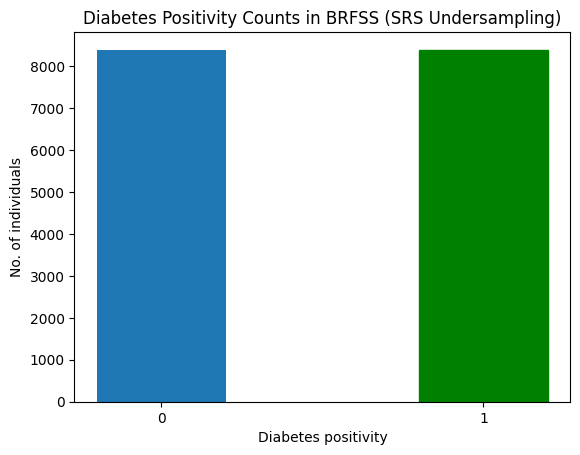

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [ ]:
data_T_y.value_counts()

Y
0    13948
1     1736
Name: count, dtype: int64

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

T_train['Y'].value_counts()

X_T_train_SRS, y_T_train_SRS = SRS_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRS)


1391
11156
13225    0
12868    0
8838     0
15268    0
2830     0
        ..
2163     1
6921     1
9893     1
2897     1
14116    1
Name: Y, Length: 2782, dtype: int64


In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (13428, 12)
y_S_train: (13428,)
X_S_test: (3358, 12)
y_S_test: (3358,)


In [ ]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_392 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.7250 - loss: 0.6226 - val_AUC: 0.7809 - val_loss: 0.5711
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7704 - loss: 0.5710 - val_AUC: 0.8031 - val_loss: 0.5448
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7845 - loss: 0.5600 - val_AUC: 0.8207 - val_loss: 0.5284
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7992 - loss: 0.5477 - val_AUC: 0.8210 - val_loss: 0.5274
Epoch 5/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7994 - loss: 0.5453 - val_AUC: 0.8265 - val_loss: 0.5186
Epoch 6/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8046 - loss: 0.5364 - val_AUC: 0.8279 - val_loss: 0.5113
Epoch 7/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8085 - loss: 0.5332 - val_AUC: 0.8295 - val_loss: 0.5139
Epoch 8/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8167 - loss: 0.5215 - val_AUC: 0.8277 - val_loss: 0.5100
Epoch 9/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

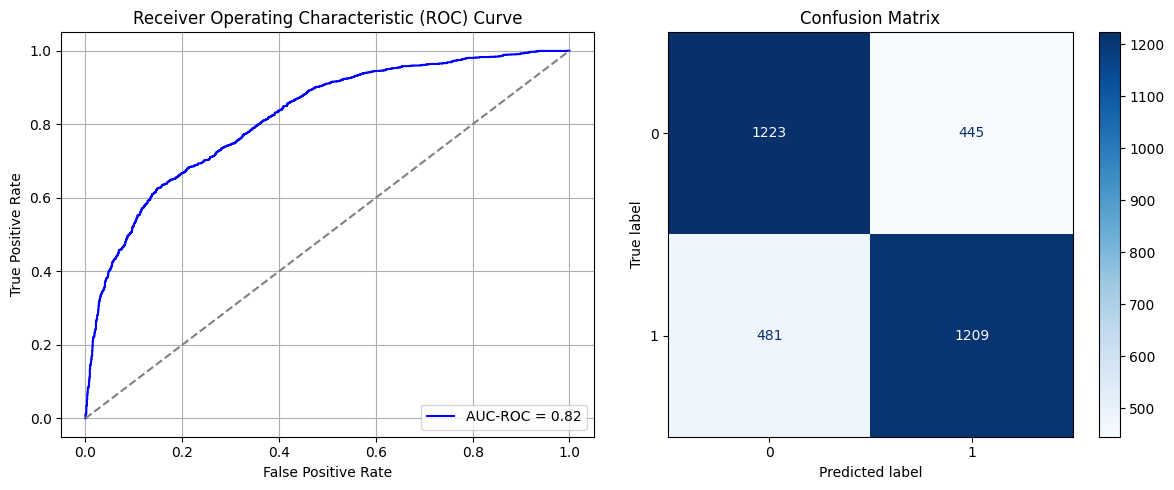

Best threshold based on F1-score: 0.30910563468933105
Time elapsed (performance): 19.14975017100005


<Sequential name=sequential_56, built=True>

In [ ]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.7456480212615755
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      2792
           1       0.19      0.74      0.31       345

    accuracy                           0.63      3137
   macro avg       0.57      0.68      0.53      3137
weighted avg       0.87      0.63      0.70      3137

FPR 0.37929799426934097 TPR: 0.736231884057971 FNR: 0.263768115942029 TNR: 0.620702005730659


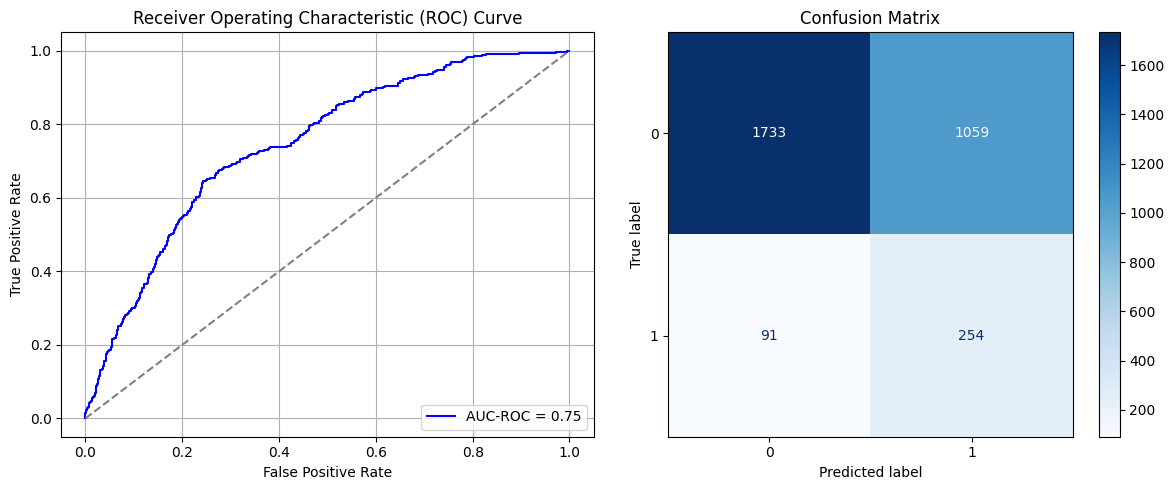

Best threshold based on F1-score: 0.5507749319076538
False Negative Rate: 0.263768115942029
Time elapsed (performance): 1.3059954830000606


In [ ]:
Transductive_TL(model_source_SRS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_399 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6851 - loss: 0.4202 - val_AUC: 0.6295 - val_loss: 0.3539
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.6542 - loss: 0.3205 - val_AUC: 0.7313 - val_loss: 0.3337
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7452 - loss: 0.3083 - val_AUC: 0.7366 - val_loss: 0.3280
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7501 - loss: 0.3024 - val_AUC: 0.7408 - val_loss: 0.3254
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7516 - loss: 0.3053 - val_AUC: 0.7434 - val_loss: 0.3234
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7458 - loss: 0.2974 - val_AUC: 0.7459 - val_loss: 0.3218
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7538 - loss: 0.2961 - val_AUC: 0.7476 - val_loss: 0.3209
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7647 - loss: 0.2989 - val_AUC: 0.7483 - val_loss: 0.3204
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7611 -

(np.float64(0.0035816618911174787), np.float64(0.9449275362318841))

In [ ]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_406 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - AUC: 0.7333 - loss: 0.5900 - val_AUC: 0.0000e+00 - val_loss: 0.7262
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7258 - loss: 0.5880 - val_AUC: 0.0000e+00 - val_loss: 0.7571
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7549 - loss: 0.5654 - val_AUC: 0.0000e+00 - val_loss: 0.7292
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7550 - loss: 0.5606 - val_AUC: 0.0000e+00 - val_loss: 0.7212
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7401 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.7609
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7526 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.7975
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7801 - loss: 0.5374 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7755 - loss: 0.5376 - val_AUC: 0.0000e+00 - val_loss: 0.7093
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.15293696275071633), np.float64(0.48695652173913045))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_427 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_432 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 0.7187 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.6880
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7456 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.7546
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7308 - loss: 0.5762 - val_AUC: 0.0000e+00 - val_loss: 0.7480
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7429 - loss: 0.5604 - val_AUC: 0.0000e+00 - val_loss: 0.7629
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7605 - loss: 0.5472 - val_AUC: 0.0000e+00 - val_loss: 0.7003
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7715 - loss: 0.5493 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7773 - loss: 0.5379 - val_AUC: 0.0000e+00 - val_loss: 0.8259
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7604 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_434 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_435 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - AUC: 0.7353 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.7413
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7256 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7471 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.7861
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7464 - loss: 0.5640 - val_AUC: 0.0000e+00 - val_loss: 0.7201
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7595 - loss: 0.5544 - val_AUC: 0.0000e+00 - val_loss: 0.6951
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7606 - loss: 0.5466 - val_AUC: 0.0000e+00 - val_loss: 0.7525
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7617 - loss: 0.5434 - val_AUC: 0.0000e+00 - val_loss: 0.7488
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7585 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.6850
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_441 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7183 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.6566
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7365 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.7395
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7473 - loss: 0.5662 - val_AUC: 0.0000e+00 - val_loss: 0.7230
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7503 - loss: 0.5643 - val_AUC: 0.0000e+00 - val_loss: 0.7747
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7598 - loss: 0.5500 - val_AUC: 0.0000e+00 - val_loss: 0.7454
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7814 - loss: 0.5341 - val_AUC: 0.0000e+00 - val_loss: 0.7543
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7798 - loss: 0.5342 - val_AUC: 0.0000e+00 - val_loss: 0.7859
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7808 - loss: 0.5398 - val_AUC: 0.0000e+00 - val_loss: 0.7390
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_448 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.7437 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.7154
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7473 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.7162
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7234 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.7522
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7434 - loss: 0.5651 - val_AUC: 0.0000e+00 - val_loss: 0.7350
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7491 - loss: 0.5589 - val_AUC: 0.0000e+00 - val_loss: 0.7881
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7481 - loss: 0.5554 - val_AUC: 0.0000e+00 - val_loss: 0.6943
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7581 - loss: 0.5551 - val_AUC: 0.0000e+00 - val_loss: 0.7343
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7642 - loss: 0.5435 - val_AUC: 0.0000e+00 - val_loss: 0.7181
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_455 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7235 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.7524
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7515 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.7215
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7591 - loss: 0.5577 - val_AUC: 0.0000e+00 - val_loss: 0.6968
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7472 - loss: 0.5562 - val_AUC: 0.0000e+00 - val_loss: 0.7237
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7544 - loss: 0.5595 - val_AUC: 0.0000e+00 - val_loss: 0.7818
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7535 - loss: 0.5586 - val_AUC: 0.0000e+00 - val_loss: 0.7742
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7507 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.7583
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7601 - loss: 0.5444 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_462 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_468 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7459 - loss: 0.5748 - val_AUC: 0.0000e+00 - val_loss: 0.7229
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7255 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.6868
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.7722
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7569 - loss: 0.5469 - val_AUC: 0.0000e+00 - val_loss: 0.7532
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7459 - loss: 0.5625 - val_AUC: 0.0000e+00 - val_loss: 0.7800
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7623 - loss: 0.5593 - val_AUC: 0.0000e+00 - val_loss: 0.7517
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7592 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.6728
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7614 - loss: 0.5498 - val_AUC: 0.0000e+00 - val_loss: 0.6916
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_469 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_475 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - AUC: 0.7375 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.7021
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7527 - loss: 0.5635 - val_AUC: 0.0000e+00 - val_loss: 0.7282
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7524 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8312
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7408 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.7045
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7516 - loss: 0.5595 - val_AUC: 0.0000e+00 - val_loss: 0.7681
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7394 - loss: 0.5746 - val_AUC: 0.0000e+00 - val_loss: 0.8154
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7608 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 0.6449
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7590 - loss: 0.5513 - val_AUC: 0.0000e+00 - val_loss: 0.6987
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_476 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_480 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.7570 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.7738
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7388 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.7919
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7459 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.7629
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7451 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.7273
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7657 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.7439
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7615 - loss: 0.5515 - val_AUC: 0.0000e+00 - val_loss: 0.7766
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7671 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.7980
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7621 - loss: 0.5432 - val_AUC: 0.0000e+00 - val_loss: 0.7941
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_483 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7426 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.7258
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7403 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.6915
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7484 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.7957
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7505 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.6833
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7613 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.7472
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7681 - loss: 0.5406 - val_AUC: 0.0000e+00 - val_loss: 0.6788
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7676 - loss: 0.5445 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7609 - loss: 0.5512 - val_AUC: 0.0000e+00 - val_loss: 0.7162
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_490 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7431 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.7364
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7366 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8082
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7237 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.7633
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7486 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.7773
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7409 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7403
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7598 - loss: 0.5550 - val_AUC: 0.0000e+00 - val_loss: 0.7680
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7598 - loss: 0.5499 - val_AUC: 0.0000e+00 - val_loss: 0.7079
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7647 - loss: 0.5540 - val_AUC: 0.0000e+00 - val_loss: 0.7649
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_497 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7296 - loss: 0.5916 - val_AUC: 0.0000e+00 - val_loss: 0.7726
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7409 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.6942
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7584 - loss: 0.5604 - val_AUC: 0.0000e+00 - val_loss: 0.7645
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7586 - loss: 0.5441 - val_AUC: 0.0000e+00 - val_loss: 0.7590
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7628 - loss: 0.5500 - val_AUC: 0.0000e+00 - val_loss: 0.6856
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7782 - loss: 0.5407 - val_AUC: 0.0000e+00 - val_loss: 0.7337
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7793 - loss: 0.5375 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7732 - loss: 0.5426 - val_AUC: 0.0000e+00 - val_loss: 0.7781
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_504 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 0.7257 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.7149
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7524 - loss: 0.5673 - val_AUC: 0.0000e+00 - val_loss: 0.7581
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7265 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.7610
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7641 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.8204
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7602 - loss: 0.5482 - val_AUC: 0.0000e+00 - val_loss: 0.7644
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7608 - loss: 0.5545 - val_AUC: 0.0000e+00 - val_loss: 0.7738
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7622 - loss: 0.5534 - val_AUC: 0.0000e+00 - val_loss: 0.7560
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7769 - loss: 0.5367 - val_AUC: 0.0000e+00 - val_loss: 0.7414
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_511 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_514 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_515 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_516 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7269 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.7139
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7371 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.7087
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7422 - loss: 0.5704 - val_AUC: 0.0000e+00 - val_loss: 0.7795
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.7803
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7561 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.7714
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7679 - loss: 0.5442 - val_AUC: 0.0000e+00 - val_loss: 0.8040
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7545 - loss: 0.5524 - val_AUC: 0.0000e+00 - val_loss: 0.7299
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7656 - loss: 0.5528 - val_AUC: 0.0000e+00 - val_loss: 0.7815
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_518 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_520 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_521 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_522 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_523 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_524 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7396 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.7111
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7426 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.7441
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7528 - loss: 0.5541 - val_AUC: 0.0000e+00 - val_loss: 0.6793
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7464 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.7310
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7558 - loss: 0.5600 - val_AUC: 0.0000e+00 - val_loss: 0.7748
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7784 - loss: 0.5414 - val_AUC: 0.0000e+00 - val_loss: 0.8092
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7651 - loss: 0.5453 - val_AUC: 0.0000e+00 - val_loss: 0.7482
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7647 - loss: 0.5336 - val_AUC: 0.0000e+00 - val_loss: 0.6757
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_525 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7075 - loss: 0.6111 - val_AUC: 0.0000e+00 - val_loss: 0.7354
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.7308
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7406 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.7570
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7475 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.7697
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7511 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.7440
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7510 - loss: 0.5548 - val_AUC: 0.0000e+00 - val_loss: 0.7774
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7554 - loss: 0.5436 - val_AUC: 0.0000e+00 - val_loss: 0.7115
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7769 - loss: 0.5383 - val_AUC: 0.0000e+00 - val_loss: 0.7681
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_532 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.7379 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.7152
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7528 - loss: 0.5651 - val_AUC: 0.0000e+00 - val_loss: 0.7451
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7221 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.7397
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7464 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.6784
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7573 - loss: 0.5501 - val_AUC: 0.0000e+00 - val_loss: 0.7174
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7804 - loss: 0.5365 - val_AUC: 0.0000e+00 - val_loss: 0.7666
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7701 - loss: 0.5407 - val_AUC: 0.0000e+00 - val_loss: 0.7439
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7578 - loss: 0.5503 - val_AUC: 0.0000e+00 - val_loss: 0.6142
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_539 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_540 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_544 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_545 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7213 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.6673
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7411 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.7651
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7265 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.7979
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7525 - loss: 0.5587 - val_AUC: 0.0000e+00 - val_loss: 0.7879
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7476 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.8521
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7628 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.7145
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7699 - loss: 0.5518 - val_AUC: 0.0000e+00 - val_loss: 0.7957
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7640 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 0.7164
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_546 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_548 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_550 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_552 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7295 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.7402
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7416 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.7166
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7361 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.7609
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7518 - loss: 0.5577 - val_AUC: 0.0000e+00 - val_loss: 0.7590
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7519 - loss: 0.5564 - val_AUC: 0.0000e+00 - val_loss: 0.7722
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7552 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.8074
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7618 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.7093
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7582 - loss: 0.5485 - val_AUC: 0.0000e+00 - val_loss: 0.7384
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_553 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7350 - loss: 0.5853 - val_AUC: 0.0000e+00 - val_loss: 0.7260
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7414 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.7625
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7413 - loss: 0.5674 - val_AUC: 0.0000e+00 - val_loss: 0.7388
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7720 - loss: 0.5492 - val_AUC: 0.0000e+00 - val_loss: 0.8146
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7486 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7671 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.7498
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7662 - loss: 0.5518 - val_AUC: 0.0000e+00 - val_loss: 0.7667
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7798 - loss: 0.5374 - val_AUC: 0.0000e+00 - val_loss: 0.7385
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_565 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.7416 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.7784
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7481 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.7548
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7652 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.7636
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7469 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.7124
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7484 - loss: 0.5592 - val_AUC: 0.0000e+00 - val_loss: 0.7417
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7540 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.7716
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7643 - loss: 0.5406 - val_AUC: 0.0000e+00 - val_loss: 0.7602
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7385 - loss: 0.5645 - val_AUC: 0.0000e+00 - val_loss: 0.6777
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_567 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_568 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_570 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7324 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.7789
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7410 - loss: 0.5719 - val_AUC: 0.0000e+00 - val_loss: 0.7012
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7441 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.7272
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7610 - loss: 0.5491 - val_AUC: 0.0000e+00 - val_loss: 0.7424
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7542 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.6904
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7835 - loss: 0.5376 - val_AUC: 0.0000e+00 - val_loss: 0.7208
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7514 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.8102
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7576 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.7541
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_574 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_575 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_580 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.7301 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.7558
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7427 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.7684
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7409 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8261
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7509 - loss: 0.5558 - val_AUC: 0.0000e+00 - val_loss: 0.7592
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7534 - loss: 0.5587 - val_AUC: 0.0000e+00 - val_loss: 0.7602
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7521 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.7739
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7662 - loss: 0.5470 - val_AUC: 0.0000e+00 - val_loss: 0.8127
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7640 - loss: 0.5451 - val_AUC: 0.0000e+00 - val_loss: 0.7557
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_581 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_584 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_585 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7413 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.7122
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7408 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7422 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.6973
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7463 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.7662
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7430 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.7235
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7635 - loss: 0.5500 - val_AUC: 0.0000e+00 - val_loss: 0.7316
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7549 - loss: 0.5475 - val_AUC: 0.0000e+00 - val_loss: 0.6969
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7717 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.7829
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_588 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_590 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_592 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7144 - loss: 0.5954 - val_AUC: 0.0000e+00 - val_loss: 0.7380
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7393 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.7994
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7443 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.7364
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7480 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.8012
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7563 - loss: 0.5470 - val_AUC: 0.0000e+00 - val_loss: 0.7213
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7742 - loss: 0.5414 - val_AUC: 0.0000e+00 - val_loss: 0.7877
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7641 - loss: 0.5506 - val_AUC: 0.0000e+00 - val_loss: 0.7274
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7514 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.7831
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_595 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_600 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_601 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7288 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.7659
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7466 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.7793
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7450 - loss: 0.5694 - val_AUC: 0.0000e+00 - val_loss: 0.7344
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7572 - loss: 0.5568 - val_AUC: 0.0000e+00 - val_loss: 0.7352
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7637 - loss: 0.5512 - val_AUC: 0.0000e+00 - val_loss: 0.7603
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7626 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.7259
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7610 - loss: 0.5481 - val_AUC: 0.0000e+00 - val_loss: 0.7286
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7745 - loss: 0.5383 - val_AUC: 0.0000e+00 - val_loss: 0.7676
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_602 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_603 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_604 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_605 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_606 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_607 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_608 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7134 - loss: 0.6008 - val_AUC: 0.0000e+00 - val_loss: 0.7096
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7374 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.7612
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7411 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.6847
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7480 - loss: 0.5628 - val_AUC: 0.0000e+00 - val_loss: 0.7832
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7527 - loss: 0.5564 - val_AUC: 0.0000e+00 - val_loss: 0.6821
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7683 - loss: 0.5415 - val_AUC: 0.0000e+00 - val_loss: 0.7148
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7485 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.7822
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7579 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.7017
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_609 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_610 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_611 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_612 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_613 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_614 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_615 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - AUC: 0.7162 - loss: 0.6053 - val_AUC: 0.0000e+00 - val_loss: 0.7354
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7484 - loss: 0.5675 - val_AUC: 0.0000e+00 - val_loss: 0.7534
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7449 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.8059
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7425 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.7493
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7548 - loss: 0.5579 - val_AUC: 0.0000e+00 - val_loss: 0.7311
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7673 - loss: 0.5494 - val_AUC: 0.0000e+00 - val_loss: 0.7193
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7749 - loss: 0.5408 - val_AUC: 0.0000e+00 - val_loss: 0.7711
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7470 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.7068
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_616 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_617 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_618 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_619 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_620 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_621 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_622 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7334 - loss: 0.5912 - val_AUC: 0.0000e+00 - val_loss: 0.7679
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7415 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.7562
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7508 - loss: 0.5710 - val_AUC: 0.0000e+00 - val_loss: 0.7756
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7368 - loss: 0.5647 - val_AUC: 0.0000e+00 - val_loss: 0.7505
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7611 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.8701
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7646 - loss: 0.5486 - val_AUC: 0.0000e+00 - val_loss: 0.7936
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7552 - loss: 0.5530 - val_AUC: 0.0000e+00 - val_loss: 0.6827
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7586 - loss: 0.5475 - val_AUC: 0.0000e+00 - val_loss: 0.6455
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_623 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_624 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_626 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_627 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_628 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_629 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7202 - loss: 0.5952 - val_AUC: 0.0000e+00 - val_loss: 0.7300
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7516 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.7485
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7390 - loss: 0.5700 - val_AUC: 0.0000e+00 - val_loss: 0.7002
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7427 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.7551
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7597 - loss: 0.5545 - val_AUC: 0.0000e+00 - val_loss: 0.7354
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7507 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.7773
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7545 - loss: 0.5503 - val_AUC: 0.0000e+00 - val_loss: 0.7300
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7559 - loss: 0.5550 - val_AUC: 0.0000e+00 - val_loss: 0.7395
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_630 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_631 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_632 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_633 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_636 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7303 - loss: 0.5885 - val_AUC: 0.0000e+00 - val_loss: 0.6938
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7391 - loss: 0.5770 - val_AUC: 0.0000e+00 - val_loss: 0.8108
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7441 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.7844
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7397 - loss: 0.5663 - val_AUC: 0.0000e+00 - val_loss: 0.7992
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7437 - loss: 0.5676 - val_AUC: 0.0000e+00 - val_loss: 0.7209
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7680 - loss: 0.5375 - val_AUC: 0.0000e+00 - val_loss: 0.6765
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7641 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.6866
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7804 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.7142
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_637 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_640 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7496 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.7608
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7400 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.7417
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7510 - loss: 0.5631 - val_AUC: 0.0000e+00 - val_loss: 0.7521
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7299 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.7168
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7494 - loss: 0.5612 - val_AUC: 0.0000e+00 - val_loss: 0.7338
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7527 - loss: 0.5570 - val_AUC: 0.0000e+00 - val_loss: 0.6999
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7612 - loss: 0.5563 - val_AUC: 0.0000e+00 - val_loss: 0.8043
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7795 - loss: 0.5329 - val_AUC: 0.0000e+00 - val_loss: 0.7469
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_644 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_648 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - AUC: 0.7255 - loss: 0.5951 - val_AUC: 0.0000e+00 - val_loss: 0.7453
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7478 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.7369
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7488 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.8597
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7354 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.7471
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7463 - loss: 0.5627 - val_AUC: 0.0000e+00 - val_loss: 0.7191
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7640 - loss: 0.5525 - val_AUC: 0.0000e+00 - val_loss: 0.7386
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7580 - loss: 0.5522 - val_AUC: 0.0000e+00 - val_loss: 0.6971
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7684 - loss: 0.5425 - val_AUC: 0.0000e+00 - val_loss: 0.7558
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_651 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_656 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7098 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.6833
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7413 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.7562
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7389 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.7227
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7521 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.7399
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7617 - loss: 0.5564 - val_AUC: 0.0000e+00 - val_loss: 0.7039
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7626 - loss: 0.5541 - val_AUC: 0.0000e+00 - val_loss: 0.7640
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7628 - loss: 0.5547 - val_AUC: 0.0000e+00 - val_loss: 0.7327
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7620 - loss: 0.5510 - val_AUC: 0.0000e+00 - val_loss: 0.6555
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_658 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_659 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_660 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_664 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7269 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.7524
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7376 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.7109
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7600 - loss: 0.5588 - val_AUC: 0.0000e+00 - val_loss: 0.6952
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7576 - loss: 0.5592 - val_AUC: 0.0000e+00 - val_loss: 0.7933
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7432 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7042
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7549 - loss: 0.5628 - val_AUC: 0.0000e+00 - val_loss: 0.7834
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7691 - loss: 0.5480 - val_AUC: 0.0000e+00 - val_loss: 0.7608
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7739 - loss: 0.5322 - val_AUC: 0.0000e+00 - val_loss: 0.7221
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_665 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_668 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_669 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7181 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_loss: 0.7536
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7220 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.7463
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7374 - loss: 0.5740 - val_AUC: 0.0000e+00 - val_loss: 0.7830
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7383 - loss: 0.5688 - val_AUC: 0.0000e+00 - val_loss: 0.7316
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7469 - loss: 0.5592 - val_AUC: 0.0000e+00 - val_loss: 0.6944
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7763 - loss: 0.5435 - val_AUC: 0.0000e+00 - val_loss: 0.8117
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7605 - loss: 0.5548 - val_AUC: 0.0000e+00 - val_loss: 0.7995
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7611 - loss: 0.5439 - val_AUC: 0.0000e+00 - val_loss: 0.7173
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_673 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_674 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_675 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_676 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_677 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_678 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7353 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.7134
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7266 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.7423
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7438 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.7507
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7597 - loss: 0.5504 - val_AUC: 0.0000e+00 - val_loss: 0.7248
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7644 - loss: 0.5473 - val_AUC: 0.0000e+00 - val_loss: 0.7916
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7672 - loss: 0.5480 - val_AUC: 0.0000e+00 - val_loss: 0.7352
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7705 - loss: 0.5438 - val_AUC: 0.0000e+00 - val_loss: 0.6935
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7846 - loss: 0.5315 - val_AUC: 0.0000e+00 - val_loss: 0.7249
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_679 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_680 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_681 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_682 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7488 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.7293
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7310 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.7540
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7537 - loss: 0.5620 - val_AUC: 0.0000e+00 - val_loss: 0.7919
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7396 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.7827
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7405 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.7527
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7724 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.7901
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7560 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.8371
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7611 - loss: 0.5491 - val_AUC: 0.0000e+00 - val_loss: 0.7348
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_686 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_687 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_688 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_689 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_690 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_691 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_692 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.7279 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.7197
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7055 - loss: 0.6058 - val_AUC: 0.0000e+00 - val_loss: 0.7904
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7498 - loss: 0.5610 - val_AUC: 0.0000e+00 - val_loss: 0.7344
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.8155
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7544 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.8155
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7648 - loss: 0.5487 - val_AUC: 0.0000e+00 - val_loss: 0.7343
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7712 - loss: 0.5455 - val_AUC: 0.0000e+00 - val_loss: 0.7141
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7564 - loss: 0.5452 - val_AUC: 0.0000e+00 - val_loss: 0.7303
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_693 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_694 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_695 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_696 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_697 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.7157 - loss: 0.5961 - val_AUC: 0.0000e+00 - val_loss: 0.6773
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7372 - loss: 0.5830 - val_AUC: 0.0000e+00 - val_loss: 0.7639
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7543 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7730
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7321 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.7797
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7613 - loss: 0.5464 - val_AUC: 0.0000e+00 - val_loss: 0.8008
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7701 - loss: 0.5404 - val_AUC: 0.0000e+00 - val_loss: 0.7339
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7590 - loss: 0.5520 - val_AUC: 0.0000e+00 - val_loss: 0.7448
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7796 - loss: 0.5323 - val_AUC: 0.0000e+00 - val_loss: 0.7163
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_700 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_701 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_702 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_703 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_704 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_705 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_706 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.7284 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.7112
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.7932
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7349 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.7687
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7566 - loss: 0.5550 - val_AUC: 0.0000e+00 - val_loss: 0.7500
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7515 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.7790
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7698 - loss: 0.5482 - val_AUC: 0.0000e+00 - val_loss: 0.8131
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7675 - loss: 0.5408 - val_AUC: 0.0000e+00 - val_loss: 0.7134
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7631 - loss: 0.5439 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_707 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_708 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_709 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_710 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_711 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_712 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_713 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.7121 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_loss: 0.7032
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7402 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.7807
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7336 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.7301
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7379 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.7598
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7415 - loss: 0.5665 - val_AUC: 0.0000e+00 - val_loss: 0.7446
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7665 - loss: 0.5411 - val_AUC: 0.0000e+00 - val_loss: 0.7474
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7559 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.8128
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7564 - loss: 0.5534 - val_AUC: 0.0000e+00 - val_loss: 0.8039
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_714 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_715 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_716 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_717 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_718 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_720 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7298 - loss: 0.5914 - val_AUC: 0.0000e+00 - val_loss: 0.7821
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7322 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.7247
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7519 - loss: 0.5630 - val_AUC: 0.0000e+00 - val_loss: 0.7243
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7542 - loss: 0.5497 - val_AUC: 0.0000e+00 - val_loss: 0.7351
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.7646
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7682 - loss: 0.5427 - val_AUC: 0.0000e+00 - val_loss: 0.7846
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7744 - loss: 0.5382 - val_AUC: 0.0000e+00 - val_loss: 0.7681
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7785 - loss: 0.5383 - val_AUC: 0.0000e+00 - val_loss: 0.7334
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_721 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_724 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_725 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.7295 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.6788
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7460 - loss: 0.5737 - val_AUC: 0.0000e+00 - val_loss: 0.7493
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7594 - loss: 0.5586 - val_AUC: 0.0000e+00 - val_loss: 0.7781
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7655 - loss: 0.5508 - val_AUC: 0.0000e+00 - val_loss: 0.7187
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7464 - loss: 0.5670 - val_AUC: 0.0000e+00 - val_loss: 0.7861
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7747 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 0.7138
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7739 - loss: 0.5433 - val_AUC: 0.0000e+00 - val_loss: 0.7397
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5522 - val_AUC: 0.0000e+00 - val_loss: 0.6886
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_728 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_729 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_730 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_731 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_732 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7395 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.6915
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7358 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.7403
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7374 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.7362
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7364 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.7595
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7564 - loss: 0.5529 - val_AUC: 0.0000e+00 - val_loss: 0.7037
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7667 - loss: 0.5564 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7617 - loss: 0.5519 - val_AUC: 0.0000e+00 - val_loss: 0.7331
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7525 - loss: 0.5563 - val_AUC: 0.0000e+00 - val_loss: 0.7117
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_735 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_738 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_739 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_740 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7457 - loss: 0.5827 - val_AUC: 0.0000e+00 - val_loss: 0.7576
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7371 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.6816
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7578 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.7199
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7466 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.7634
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7558 - loss: 0.5584 - val_AUC: 0.0000e+00 - val_loss: 0.8025
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7523 - loss: 0.5464 - val_AUC: 0.0000e+00 - val_loss: 0.7036
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7702 - loss: 0.5452 - val_AUC: 0.0000e+00 - val_loss: 0.7805
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7723 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.7898
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_742 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_744 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_745 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_746 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_747 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_748 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7182 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.6790
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7336 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.7467
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7491 - loss: 0.5622 - val_AUC: 0.0000e+00 - val_loss: 0.7833
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7513 - loss: 0.5551 - val_AUC: 0.0000e+00 - val_loss: 0.7281
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7578 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.7379
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7507 - loss: 0.5666 - val_AUC: 0.0000e+00 - val_loss: 0.8356
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7565 - loss: 0.5522 - val_AUC: 0.0000e+00 - val_loss: 0.7046
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7713 - loss: 0.5463 - val_AUC: 0.0000e+00 - val_loss: 0.7402
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_752 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_753 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_754 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_755 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.7219 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.7641
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7486 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.7404
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7451 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.8079
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7420 - loss: 0.5724 - val_AUC: 0.0000e+00 - val_loss: 0.7601
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7543 - loss: 0.5561 - val_AUC: 0.0000e+00 - val_loss: 0.7096
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7635 - loss: 0.5485 - val_AUC: 0.0000e+00 - val_loss: 0.8184
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7514 - loss: 0.5598 - val_AUC: 0.0000e+00 - val_loss: 0.7303
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7743 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.7717
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_760 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.7305 - loss: 0.5909 - val_AUC: 0.0000e+00 - val_loss: 0.7408
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7291 - loss: 0.5794 - val_AUC: 0.0000e+00 - val_loss: 0.7177
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7296 - loss: 0.5812 - val_AUC: 0.0000e+00 - val_loss: 0.7912
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7506 - loss: 0.5617 - val_AUC: 0.0000e+00 - val_loss: 0.7353
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7555 - loss: 0.5549 - val_AUC: 0.0000e+00 - val_loss: 0.7156
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7653 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.7389
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7599 - loss: 0.5512 - val_AUC: 0.0000e+00 - val_loss: 0.7223
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7653 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.7689
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_763 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_764 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_765 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_766 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_767 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_768 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.7470 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.7514
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7454 - loss: 0.5668 - val_AUC: 0.0000e+00 - val_loss: 0.7181
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7407 - loss: 0.5632 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7432 - loss: 0.5642 - val_AUC: 0.0000e+00 - val_loss: 0.7537
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7582 - loss: 0.5552 - val_AUC: 0.0000e+00 - val_loss: 0.8257
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7604 - loss: 0.5513 - val_AUC: 0.0000e+00 - val_loss: 0.7498
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7692 - loss: 0.5494 - val_AUC: 0.0000e+00 - val_loss: 0.7834
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7556 - loss: 0.5545 - val_AUC: 0.0000e+00 - val_loss: 0.8039
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_770 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_771 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_772 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_773 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_774 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_775 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_776 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.7220 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.7103
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7479 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.7123
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7273 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.7641
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7473 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.7561
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7574 - loss: 0.5538 - val_AUC: 0.0000e+00 - val_loss: 0.7854
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7728 - loss: 0.5457 - val_AUC: 0.0000e+00 - val_loss: 0.7846
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7583 - loss: 0.5535 - val_AUC: 0.0000e+00 - val_loss: 0.7617
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7696 - loss: 0.5372 - val_AUC: 0.0000e+00 - val_loss: 0.7077
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_Fine_Tuning.csv')

         FPR       FNR
0   0.198066  0.420290
1   0.167622  0.466667
2   0.202364  0.417391
3   0.197708  0.426087
4   0.200215  0.426087
5   0.193768  0.423188
6   0.182307  0.443478
7   0.173711  0.455072
8   0.188037  0.440580
9   0.145774  0.510145
10  0.190544  0.431884
11  0.193410  0.426087
12  0.178725  0.446377
13  0.185530  0.443478
14  0.205587  0.405797
15  0.166547  0.475362
16  0.215258  0.405797
17  0.193052  0.420290
18  0.163324  0.472464
19  0.201648  0.420290
20  0.191619  0.426087
21  0.185172  0.440580
22  0.148281  0.510145
23  0.155086  0.486957
24  0.178009  0.446377
25  0.164398  0.466667
26  0.189828  0.437681
27  0.205229  0.417391
28  0.197708  0.423188
29  0.160100  0.486957
30  0.188395  0.434783
31  0.179799  0.437681
32  0.205946  0.405797
33  0.215616  0.397101
34  0.196633  0.426087
35  0.203438  0.408696
36  0.195201  0.426087
37  0.126791  0.562319
38  0.192693  0.440580
39  0.169771  0.460870
40  0.135745  0.524638
41  0.175860  0.460870
42  0.14971

## Simple Random Sampling with Replacement:

In [ ]:
data_S_full

0      1         2         3         4    5     6    7  \
0      0.301370  0.000  0.044131  0.000000  0.000000  0.0  0.00  0.0   
1      0.452055  0.125  0.048052  0.666667  0.071429  0.2  0.00  0.0   
2      0.287671  0.250  0.137581  0.166667  0.142857  0.0  0.00  0.0   
3      0.493151  0.250  0.150486  0.666667  0.142857  0.2  0.25  0.0   
4      0.479452  0.125  0.133519  0.666667  0.071429  0.2  0.00  0.0   
...         ...    ...       ...       ...       ...  ...   ...  ...   
31932  0.424658  0.500  0.227956  0.166667  0.285714  0.0  0.00  0.0   
31933  0.219178  0.250  0.157583  0.000000  0.214286  0.6  0.00  0.0   
31934  0.287671  0.250  0.245379  0.666667  0.214286  0.2  0.00  0.0   
31935  0.369863  0.250  0.048444  0.166667  0.000000  0.6  0.50  0.0   
31936  0.246575  0.750  0.114919  0.666667  0.071429  0.2  0.00  0.0   

              8    9        10   11  Y2  
0      0.021740  0.0  0.397959  0.0   1  
1      0.000000  0.0  0.122449  0.0   1  
2      0.000000  0.0  0.397959  0.0   0  
3      0.000000  0.0  0.397959  0.0   0  
4      0.000000  0.0  0.448980  0.0   0  
...         ...  ...       ...  ...  ..  
31932  0.000000  0.0  0.397959  0.0   1  
31933  0.000000  0.0  0.397959  0.0   1  
31934  0.000000  0.0  0.500000  0.0   1  
31935  0.054551  0.0  0.397959  0.0   1  
31936  0.000000  0.0  0.602041  0.0   1  

[31937 rows x 13 columns]

In [ ]:
data_T_full

0     1         2         3         4    5     6    7         8  \
0      0.150685  0.25  0.220635  0.666667  0.214286  0.4  0.25  1.0  0.000000   
1      0.273973  0.25  0.184219  0.666667  0.071429  0.4  0.00  1.0  0.000000   
2      0.438356  0.25  0.100061  1.000000  0.285714  0.0  0.25  1.0  0.000000   
3      0.191781  0.25  0.022661  0.000000  0.214286  0.0  0.00  1.0  0.140841   
4      0.082192  0.25  0.074410  0.000000  0.000000  0.6  0.00  1.0  0.000000   
...         ...   ...       ...       ...       ...  ...   ...  ...       ...   
15679  0.136986  0.25  0.282830  0.000000  0.357143  0.0  0.00  1.0  0.000000   
15680  0.520548  0.25  0.143676  0.333333  1.000000  0.0  0.00  1.0  0.000000   
15681  0.287671  0.25  0.159164  0.000000  0.000000  0.8  0.25  1.0  0.000000   
15682  0.109589  0.25  0.229138  0.000000  0.285714  0.6  0.00  1.0  0.000000   
15683  0.301370  0.25  0.137428  0.166667  0.214286  0.0  0.00  1.0  0.000000   

         9        10       11  Y  
0      0.0  0.397959  0.02439  0  
1      0.0  0.397959  0.00000  0  
2      0.0  0.153061  0.04878  0  
3      0.0  0.500000  0.00000  1  
4      0.0  0.295918  0.00000  0  
...    ...       ...      ... ..  
15679  0.0  0.448980  0.00000  0  
15680  0.0  0.316327  0.00000  0  
15681  0.0  0.397959  0.00000  0  
15682  0.0  0.397959  0.00000  0  
15683  0.0  0.357143  0.00000  0  

[15684 rows x 13 columns]

In [ ]:
X_S_SRSwR, y_S_SRSwR = SRSwR_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(X_S_SRSwR)

8393
23544
              0     1         2         3         4    5    6    7         8  \
27075  0.246575  0.25  0.124254  0.666667  0.285714  0.2  0.5  0.0  0.000000   
21342  0.136986  0.25  0.061801  0.166667  0.000000  0.0  0.0  0.0  0.000000   
24073  0.041096  0.25  0.029213  0.000000  0.357143  0.6  0.0  0.0  0.000000   
29303  0.520548  0.25  0.223146  0.000000  0.071429  0.0  0.0  0.0  0.000000   
20865  0.027397  0.25  0.075759  0.000000  0.357143  0.6  0.0  0.0  0.000000   
...         ...   ...       ...       ...       ...  ...  ...  ...       ...   
31932  0.424658  0.50  0.227956  0.166667  0.285714  0.0  0.0  0.0  0.000000   
31933  0.219178  0.25  0.157583  0.000000  0.214286  0.6  0.0  0.0  0.000000   
31934  0.287671  0.25  0.245379  0.666667  0.214286  0.2  0.0  0.0  0.000000   
31935  0.369863  0.25  0.048444  0.166667  0.000000  0.6  0.5  0.0  0.054551   
31936  0.246575  0.75  0.114919  0.666667  0.071429  0.2  0.0  0.0  0.000000   

         9        10        

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
print(y_T_train_SRSwR)

1391
11156
440      0
9066     0
10720    0
13186    0
6979     0
        ..
2163     1
6921     1
9893     1
2897     1
14116    1
Name: Y, Length: 2782, dtype: int64


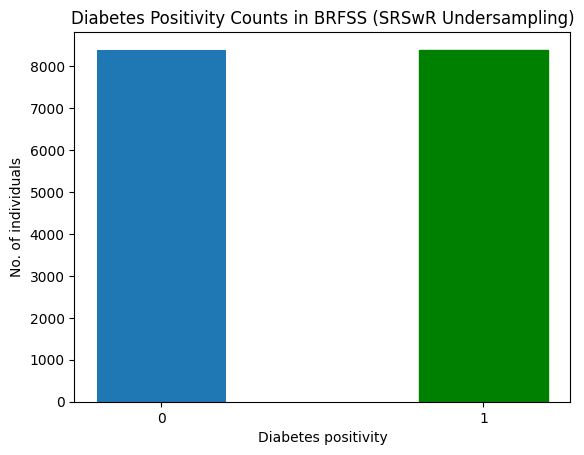

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (13428, 12)
y_S_train: (13428,)
X_S_test: (3358, 12)
y_S_test: (3358,)


In [ ]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_777 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_783 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.6781 - loss: 0.6434 - val_AUC: 0.7671 - val_loss: 0.5779
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7526 - loss: 0.5875 - val_AUC: 0.7933 - val_loss: 0.5549
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7785 - loss: 0.5655 - val_AUC: 0.7959 - val_loss: 0.5603
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7780 - loss: 0.5679 - val_AUC: 0.8070 - val_loss: 0.5505
Epoch 5/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7923 - loss: 0.5528 - val_AUC: 0.8120 - val_loss: 0.5332
Epoch 6/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7950 - loss: 0.5466 - val_AUC: 0.8200 - val_loss: 0.5202
Epoch 7/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8070 - loss: 0.5328 - val_AUC: 0.8198 - val_loss: 0.5296
Epoch 8/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8041 - loss: 0.5368 - val_AUC: 0.8240 - val_loss: 0.5154
Epoch 9/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AU

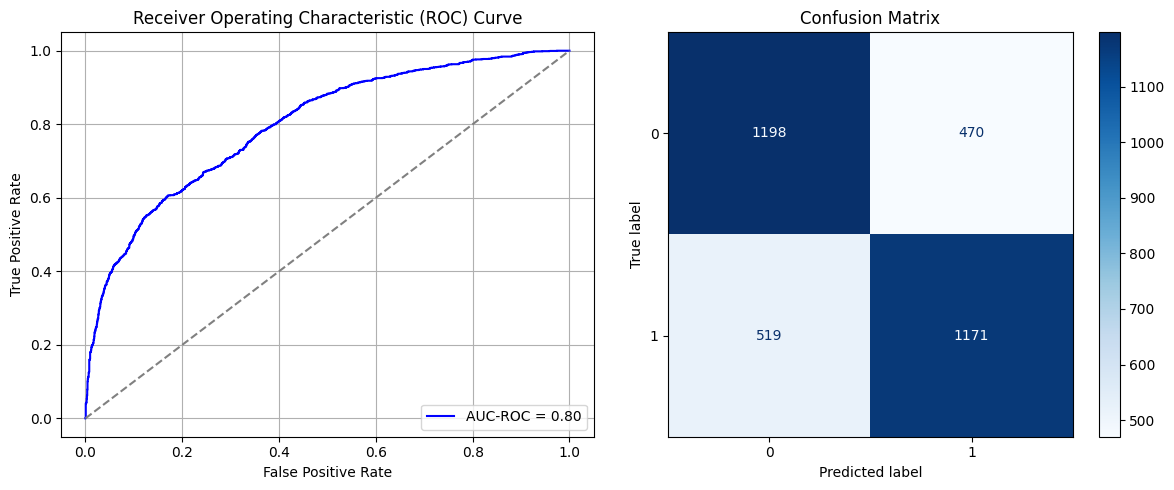

<ipython-input-46-93669339d7ff>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9858306050300598
Time elapsed (performance): 18.52258175499992


<Sequential name=sequential_111, built=True>

In [ ]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AUC-ROC: 0.6598241352103318
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2792
           1       0.14      0.22      0.17       345

    accuracy                           0.77      3137
   macro avg       0.52      0.53      0.52      3137
weighted avg       0.81      0.77      0.79      3137

FPR 0.15938395415472778 TPR: 0.21739130434782605 FNR: 0.782608695652174 TNR: 0.8406160458452723


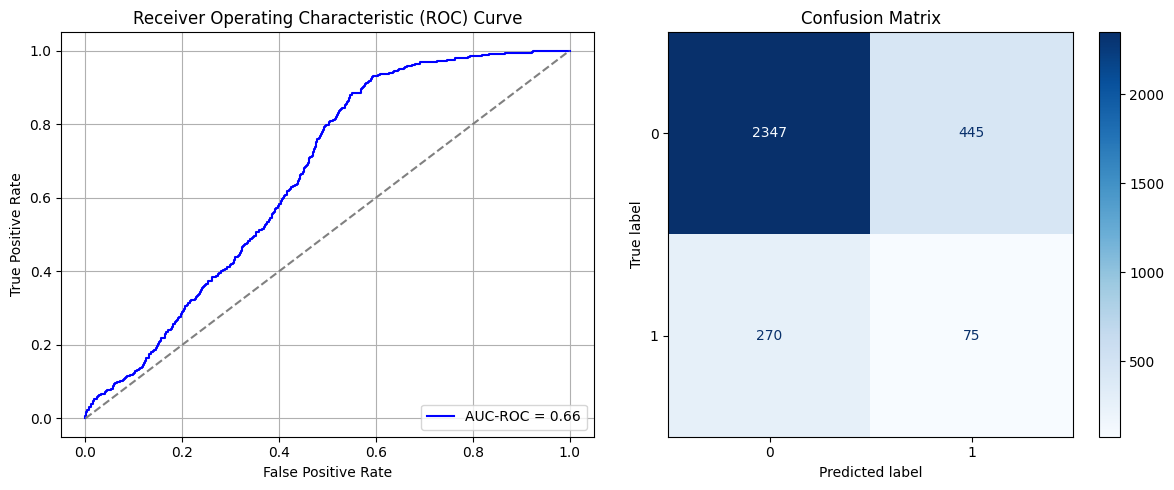

Best threshold based on F1-score: 0.2622983157634735
False Negative Rate: 0.782608695652174
Time elapsed (performance): 1.1615838620000432


In [ ]:
Transductive_TL(model_source_SRSwR, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_784 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_785 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_786 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_787 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_788 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_789 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_790 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.6935 - loss: 0.3367 - val_AUC: 0.7693 - val_loss: 0.3151
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7951 - loss: 0.2950 - val_AUC: 0.7935 - val_loss: 0.3032
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8179 - loss: 0.2742 - val_AUC: 0.8218 - val_loss: 0.2914
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8441 - loss: 0.2662 - val_AUC: 0.8330 - val_loss: 0.2835
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8466 - loss: 0.2514 - val_AUC: 0.8374 - val_loss: 0.2791
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8436 - loss: 0.2667 - val_AUC: 0.8445 - val_loss: 0.2752
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8521 - loss: 0.2522 - val_AUC: 0.8496 - val_loss: 0.2720
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8565 - loss: 0.2449 - val_AUC: 0.8525 - val_loss: 0.2699
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8650 -

(np.float64(0.018266475644699142), np.float64(0.736231884057971))

In [ ]:
fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_791 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_792 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_793 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_794 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_795 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_796 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_797 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.6691 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_loss: 0.7509
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7276 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.8631
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7842 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.7548
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7937 - loss: 0.5220 - val_AUC: 0.0000e+00 - val_loss: 0.6842
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8005 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.7447
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8077 - loss: 0.5141 - val_AUC: 0.0000e+00 - val_loss: 0.7739
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8168 - loss: 0.4988 - val_AUC: 0.0000e+00 - val_loss: 0.6552
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8167 - loss: 0.5021 - val_AUC: 0.0000e+00 - val_loss: 0.7571
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.15257879656160458), np.float64(0.3159420289855073))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    # X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train.iloc[:,-1])
    fpr, fnr = fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_819 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_820 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_821 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_822 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_823 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_824 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_825 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 0.6515 - loss: 0.6169 - val_AUC: 0.0000e+00 - val_loss: 0.8842
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7179 - loss: 0.5691 - val_AUC: 0.0000e+00 - val_loss: 0.8026
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7946 - loss: 0.5297 - val_AUC: 0.0000e+00 - val_loss: 0.7828
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8065 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.7840
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7980 - loss: 0.5208 - val_AUC: 0.0000e+00 - val_loss: 0.6440
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8173 - loss: 0.5108 - val_AUC: 0.0000e+00 - val_loss: 0.7087
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8132 - loss: 0.5119 - val_AUC: 0.0000e+00 - val_loss: 0.7286
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8249 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_826 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_827 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_828 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_829 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_830 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_831 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_832 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - AUC: 0.6566 - loss: 0.6153 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7280 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8674
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7694 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.7988
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7847 - loss: 0.5349 - val_AUC: 0.0000e+00 - val_loss: 0.7329
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8211 - loss: 0.5051 - val_AUC: 0.0000e+00 - val_loss: 0.6724
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8114 - loss: 0.5074 - val_AUC: 0.0000e+00 - val_loss: 0.6108
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8287 - loss: 0.4906 - val_AUC: 0.0000e+00 - val_loss: 0.6820
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8220 - loss: 0.4988 - val_AUC: 0.0000e+00 - val_loss: 0.6429
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_833 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_834 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_835 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_836 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_837 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_838 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_839 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6790 - loss: 0.5960 - val_AUC: 0.0000e+00 - val_loss: 0.8319
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7158 - loss: 0.5852 - val_AUC: 0.0000e+00 - val_loss: 0.8553
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7782 - loss: 0.5436 - val_AUC: 0.0000e+00 - val_loss: 0.7696
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7853 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.7026
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7988 - loss: 0.5198 - val_AUC: 0.0000e+00 - val_loss: 0.7315
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8044 - loss: 0.5160 - val_AUC: 0.0000e+00 - val_loss: 0.6634
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8070 - loss: 0.5123 - val_AUC: 0.0000e+00 - val_loss: 0.6591
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8148 - loss: 0.5048 - val_AUC: 0.0000e+00 - val_loss: 0.7357
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_840 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_841 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_842 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_843 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_844 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_846 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - AUC: 0.6795 - loss: 0.6026 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7400 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.7544
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7551 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.7938
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7886 - loss: 0.5339 - val_AUC: 0.0000e+00 - val_loss: 0.7215
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8077 - loss: 0.5124 - val_AUC: 0.0000e+00 - val_loss: 0.7805
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8148 - loss: 0.4998 - val_AUC: 0.0000e+00 - val_loss: 0.6108
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8196 - loss: 0.4992 - val_AUC: 0.0000e+00 - val_loss: 0.6423
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8326 - loss: 0.4853 - val_AUC: 0.0000e+00 - val_loss: 0.6092
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_847 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_848 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_851 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_852 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_853 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.6725 - loss: 0.6086 - val_AUC: 0.0000e+00 - val_loss: 0.8748
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7297 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.7475
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7741 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.7269
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7877 - loss: 0.5351 - val_AUC: 0.0000e+00 - val_loss: 0.7108
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8069 - loss: 0.5140 - val_AUC: 0.0000e+00 - val_loss: 0.7663
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7977 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.7030
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8058 - loss: 0.5134 - val_AUC: 0.0000e+00 - val_loss: 0.6984
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8205 - loss: 0.4961 - val_AUC: 0.0000e+00 - val_loss: 0.5926
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_854 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_856 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_860 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6662 - loss: 0.6140 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7362 - loss: 0.5629 - val_AUC: 0.0000e+00 - val_loss: 0.8205
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7767 - loss: 0.5427 - val_AUC: 0.0000e+00 - val_loss: 0.7649
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7933 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.7115
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7941 - loss: 0.5313 - val_AUC: 0.0000e+00 - val_loss: 0.6758
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8111 - loss: 0.5074 - val_AUC: 0.0000e+00 - val_loss: 0.6579
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8145 - loss: 0.5044 - val_AUC: 0.0000e+00 - val_loss: 0.6623
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8242 - loss: 0.4973 - val_AUC: 0.0000e+00 - val_loss: 0.5974
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_861 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_862 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_863 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_864 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_865 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_866 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_867 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6577 - loss: 0.6012 - val_AUC: 0.0000e+00 - val_loss: 0.8225
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7314 - loss: 0.5639 - val_AUC: 0.0000e+00 - val_loss: 0.7990
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7691 - loss: 0.5581 - val_AUC: 0.0000e+00 - val_loss: 0.8248
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8063 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.7777
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8025 - loss: 0.5238 - val_AUC: 0.0000e+00 - val_loss: 0.7209
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8049 - loss: 0.5176 - val_AUC: 0.0000e+00 - val_loss: 0.7078
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8142 - loss: 0.5012 - val_AUC: 0.0000e+00 - val_loss: 0.6843
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8219 - loss: 0.5005 - val_AUC: 0.0000e+00 - val_loss: 0.7449
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_868 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_869 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_870 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_871 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_872 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_873 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_874 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6666 - loss: 0.6118 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7196 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.7489
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7896 - loss: 0.5371 - val_AUC: 0.0000e+00 - val_loss: 0.7326
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7984 - loss: 0.5254 - val_AUC: 0.0000e+00 - val_loss: 0.7468
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7974 - loss: 0.5208 - val_AUC: 0.0000e+00 - val_loss: 0.7508
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8046 - loss: 0.5202 - val_AUC: 0.0000e+00 - val_loss: 0.7310
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8102 - loss: 0.5156 - val_AUC: 0.0000e+00 - val_loss: 0.7298
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8170 - loss: 0.5052 - val_AUC: 0.0000e+00 - val_loss: 0.5406
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_875 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_876 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_877 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_878 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_879 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_880 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_881 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6707 - loss: 0.6135 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7415 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.8145
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7689 - loss: 0.5529 - val_AUC: 0.0000e+00 - val_loss: 0.8414
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7789 - loss: 0.5436 - val_AUC: 0.0000e+00 - val_loss: 0.6376
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8194 - loss: 0.5049 - val_AUC: 0.0000e+00 - val_loss: 0.7648
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7975 - loss: 0.5243 - val_AUC: 0.0000e+00 - val_loss: 0.8051
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7968 - loss: 0.5156 - val_AUC: 0.0000e+00 - val_loss: 0.6726
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8281 - loss: 0.4908 - val_AUC: 0.0000e+00 - val_loss: 0.6569
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_882 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_883 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_884 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_885 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_886 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_887 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_888 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.6553 - loss: 0.6122 - val_AUC: 0.0000e+00 - val_loss: 0.8201
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7207 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.8218
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7827 - loss: 0.5368 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7998 - loss: 0.5327 - val_AUC: 0.0000e+00 - val_loss: 0.7331
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7976 - loss: 0.5255 - val_AUC: 0.0000e+00 - val_loss: 0.7667
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8127 - loss: 0.5013 - val_AUC: 0.0000e+00 - val_loss: 0.6865
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8133 - loss: 0.5009 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8242 - loss: 0.4943 - val_AUC: 0.0000e+00 - val_loss: 0.7505
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_889 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_890 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_891 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_892 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_893 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_894 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_895 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6663 - loss: 0.6049 - val_AUC: 0.0000e+00 - val_loss: 0.8611
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7168 - loss: 0.5809 - val_AUC: 0.0000e+00 - val_loss: 0.8437
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7669 - loss: 0.5404 - val_AUC: 0.0000e+00 - val_loss: 0.7364
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7961 - loss: 0.5273 - val_AUC: 0.0000e+00 - val_loss: 0.6976
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7915 - loss: 0.5265 - val_AUC: 0.0000e+00 - val_loss: 0.7389
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8003 - loss: 0.5209 - val_AUC: 0.0000e+00 - val_loss: 0.7197
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8271 - loss: 0.4918 - val_AUC: 0.0000e+00 - val_loss: 0.6934
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8045 - loss: 0.5115 - val_AUC: 0.0000e+00 - val_loss: 0.7519
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_896 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_897 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_898 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_899 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_900 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_901 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_902 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6704 - loss: 0.6042 - val_AUC: 0.0000e+00 - val_loss: 0.8519
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7209 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.7508
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7742 - loss: 0.5399 - val_AUC: 0.0000e+00 - val_loss: 0.7941
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7885 - loss: 0.5351 - val_AUC: 0.0000e+00 - val_loss: 0.7835
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8002 - loss: 0.5193 - val_AUC: 0.0000e+00 - val_loss: 0.7013
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8162 - loss: 0.5057 - val_AUC: 0.0000e+00 - val_loss: 0.6239
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8183 - loss: 0.5037 - val_AUC: 0.0000e+00 - val_loss: 0.7236
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8307 - loss: 0.4955 - val_AUC: 0.0000e+00 - val_loss: 0.7843
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_903 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_904 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6832 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7369 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.8359
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7626 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.7652
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7953 - loss: 0.5236 - val_AUC: 0.0000e+00 - val_loss: 0.7823
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8230 - loss: 0.5005 - val_AUC: 0.0000e+00 - val_loss: 0.6665
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7952 - loss: 0.5243 - val_AUC: 0.0000e+00 - val_loss: 0.5996
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8012 - loss: 0.5181 - val_AUC: 0.0000e+00 - val_loss: 0.5809
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8149 - loss: 0.5012 - val_AUC: 0.0000e+00 - val_loss: 0.6645
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_910 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_914 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_915 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_916 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6522 - loss: 0.6129 - val_AUC: 0.0000e+00 - val_loss: 0.8424
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7232 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.7655
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7628 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.7324
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7988 - loss: 0.5249 - val_AUC: 0.0000e+00 - val_loss: 0.7118
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7964 - loss: 0.5196 - val_AUC: 0.0000e+00 - val_loss: 0.7315
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8166 - loss: 0.5007 - val_AUC: 0.0000e+00 - val_loss: 0.7513
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8037 - loss: 0.5106 - val_AUC: 0.0000e+00 - val_loss: 0.6450
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8164 - loss: 0.5022 - val_AUC: 0.0000e+00 - val_loss: 0.7202
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_917 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_918 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_919 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_920 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_921 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_922 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_923 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - AUC: 0.6624 - loss: 0.6077 - val_AUC: 0.0000e+00 - val_loss: 0.8055
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7335 - loss: 0.5657 - val_AUC: 0.0000e+00 - val_loss: 0.7856
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7629 - loss: 0.5577 - val_AUC: 0.0000e+00 - val_loss: 0.8704
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7834 - loss: 0.5408 - val_AUC: 0.0000e+00 - val_loss: 0.6952
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7964 - loss: 0.5282 - val_AUC: 0.0000e+00 - val_loss: 0.7685
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8127 - loss: 0.5091 - val_AUC: 0.0000e+00 - val_loss: 0.7148
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8107 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.6372
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8234 - loss: 0.4947 - val_AUC: 0.0000e+00 - val_loss: 0.6535
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_924 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_925 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_926 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_927 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_928 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_929 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_930 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6467 - loss: 0.6135 - val_AUC: 0.0000e+00 - val_loss: 0.8354
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7366 - loss: 0.5686 - val_AUC: 0.0000e+00 - val_loss: 0.8082
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7789 - loss: 0.5494 - val_AUC: 0.0000e+00 - val_loss: 0.8252
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7948 - loss: 0.5366 - val_AUC: 0.0000e+00 - val_loss: 0.6618
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7916 - loss: 0.5296 - val_AUC: 0.0000e+00 - val_loss: 0.6741
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8052 - loss: 0.5067 - val_AUC: 0.0000e+00 - val_loss: 0.6394
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8058 - loss: 0.5055 - val_AUC: 0.0000e+00 - val_loss: 0.6226
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8220 - loss: 0.4949 - val_AUC: 0.0000e+00 - val_loss: 0.7510
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_931 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_932 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_934 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_935 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_936 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_937 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6669 - loss: 0.6096 - val_AUC: 0.0000e+00 - val_loss: 0.9117
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7469 - loss: 0.5629 - val_AUC: 0.0000e+00 - val_loss: 0.8649
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7769 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.7355
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7966 - loss: 0.5216 - val_AUC: 0.0000e+00 - val_loss: 0.6741
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8090 - loss: 0.5103 - val_AUC: 0.0000e+00 - val_loss: 0.7384
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8201 - loss: 0.4962 - val_AUC: 0.0000e+00 - val_loss: 0.7278
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8114 - loss: 0.5041 - val_AUC: 0.0000e+00 - val_loss: 0.6322
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8120 - loss: 0.5095 - val_AUC: 0.0000e+00 - val_loss: 0.7127
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_938 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_939 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_940 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_941 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_942 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_943 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_944 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.6484 - loss: 0.6143 - val_AUC: 0.0000e+00 - val_loss: 0.8104
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7300 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.7691
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7740 - loss: 0.5524 - val_AUC: 0.0000e+00 - val_loss: 0.8091
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7962 - loss: 0.5333 - val_AUC: 0.0000e+00 - val_loss: 0.8012
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8100 - loss: 0.5123 - val_AUC: 0.0000e+00 - val_loss: 0.6968
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7928 - loss: 0.5258 - val_AUC: 0.0000e+00 - val_loss: 0.7562
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8300 - loss: 0.4786 - val_AUC: 0.0000e+00 - val_loss: 0.6434
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8195 - loss: 0.4991 - val_AUC: 0.0000e+00 - val_loss: 0.7378
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_945 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_946 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_947 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_948 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_949 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_950 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_951 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.6748 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7389 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7911 - loss: 0.5331 - val_AUC: 0.0000e+00 - val_loss: 0.7690
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7915 - loss: 0.5257 - val_AUC: 0.0000e+00 - val_loss: 0.7656
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8108 - loss: 0.5154 - val_AUC: 0.0000e+00 - val_loss: 0.7069
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8096 - loss: 0.5136 - val_AUC: 0.0000e+00 - val_loss: 0.6395
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8185 - loss: 0.5007 - val_AUC: 0.0000e+00 - val_loss: 0.6831
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8114 - loss: 0.5096 - val_AUC: 0.0000e+00 - val_loss: 0.6498
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_952 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_954 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_955 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_956 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_957 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_958 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6757 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_loss: 0.8327
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7327 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.8380
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7775 - loss: 0.5451 - val_AUC: 0.0000e+00 - val_loss: 0.7300
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7969 - loss: 0.5196 - val_AUC: 0.0000e+00 - val_loss: 0.7401
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8055 - loss: 0.5170 - val_AUC: 0.0000e+00 - val_loss: 0.6929
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8044 - loss: 0.5137 - val_AUC: 0.0000e+00 - val_loss: 0.7219
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8189 - loss: 0.4989 - val_AUC: 0.0000e+00 - val_loss: 0.7558
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8042 - loss: 0.5064 - val_AUC: 0.0000e+00 - val_loss: 0.6047
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_959 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_960 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_961 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_962 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_963 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6452 - loss: 0.6191 - val_AUC: 0.0000e+00 - val_loss: 0.8571
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7300 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8293
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7582 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.7687
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7959 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.8050
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8023 - loss: 0.5236 - val_AUC: 0.0000e+00 - val_loss: 0.6664
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8076 - loss: 0.5078 - val_AUC: 0.0000e+00 - val_loss: 0.6920
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8269 - loss: 0.4871 - val_AUC: 0.0000e+00 - val_loss: 0.7757
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8192 - loss: 0.4934 - val_AUC: 0.0000e+00 - val_loss: 0.6044
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_966 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_967 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_968 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_969 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_970 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_971 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_972 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6844 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8131
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7451 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.7808
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7817 - loss: 0.5357 - val_AUC: 0.0000e+00 - val_loss: 0.7610
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7977 - loss: 0.5290 - val_AUC: 0.0000e+00 - val_loss: 0.6873
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7951 - loss: 0.5285 - val_AUC: 0.0000e+00 - val_loss: 0.7880
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8088 - loss: 0.5096 - val_AUC: 0.0000e+00 - val_loss: 0.6844
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8337 - loss: 0.4826 - val_AUC: 0.0000e+00 - val_loss: 0.6733
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8359 - loss: 0.4732 - val_AUC: 0.0000e+00 - val_loss: 0.6660
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_973 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_975 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_979 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.6539 - loss: 0.6100 - val_AUC: 0.0000e+00 - val_loss: 0.8331
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7347 - loss: 0.5681 - val_AUC: 0.0000e+00 - val_loss: 0.8888
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7709 - loss: 0.5396 - val_AUC: 0.0000e+00 - val_loss: 0.7106
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7885 - loss: 0.5247 - val_AUC: 0.0000e+00 - val_loss: 0.6990
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7896 - loss: 0.5262 - val_AUC: 0.0000e+00 - val_loss: 0.7345
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8097 - loss: 0.5038 - val_AUC: 0.0000e+00 - val_loss: 0.6166
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8178 - loss: 0.4991 - val_AUC: 0.0000e+00 - val_loss: 0.7540
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8198 - loss: 0.4999 - val_AUC: 0.0000e+00 - val_loss: 0.6580
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_980 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_983 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6639 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_loss: 0.8615
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7405 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.7749
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7621 - loss: 0.5450 - val_AUC: 0.0000e+00 - val_loss: 0.7212
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7951 - loss: 0.5311 - val_AUC: 0.0000e+00 - val_loss: 0.6410
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7913 - loss: 0.5234 - val_AUC: 0.0000e+00 - val_loss: 0.7212
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8143 - loss: 0.4935 - val_AUC: 0.0000e+00 - val_loss: 0.7064
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8219 - loss: 0.4998 - val_AUC: 0.0000e+00 - val_loss: 0.6883
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8207 - loss: 0.4998 - val_AUC: 0.0000e+00 - val_loss: 0.6340
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_987 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_991 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6844 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.8565
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7296 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8249
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7879 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 0.7219
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7997 - loss: 0.5345 - val_AUC: 0.0000e+00 - val_loss: 0.6790
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8125 - loss: 0.4964 - val_AUC: 0.0000e+00 - val_loss: 0.6290
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7987 - loss: 0.5210 - val_AUC: 0.0000e+00 - val_loss: 0.7280
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8030 - loss: 0.5125 - val_AUC: 0.0000e+00 - val_loss: 0.6472
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8331 - loss: 0.4864 - val_AUC: 0.0000e+00 - val_loss: 0.6558
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_994 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_995 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_999 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 0.6683 - loss: 0.6026 - val_AUC: 0.0000e+00 - val_loss: 0.8184
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7211 - loss: 0.5769 - val_AUC: 0.0000e+00 - val_loss: 0.7797
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7785 - loss: 0.5455 - val_AUC: 0.0000e+00 - val_loss: 0.7966
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8050 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.7211
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8052 - loss: 0.5190 - val_AUC: 0.0000e+00 - val_loss: 0.8010
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7995 - loss: 0.5105 - val_AUC: 0.0000e+00 - val_loss: 0.6187
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8229 - loss: 0.4948 - val_AUC: 0.0000e+00 - val_loss: 0.6112
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8103 - loss: 0.5030 - val_AUC: 0.0000e+00 - val_loss: 0.7559
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1001 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1003 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1004 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1005 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1006 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1007 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6594 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.8180
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7320 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.7963
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7742 - loss: 0.5375 - val_AUC: 0.0000e+00 - val_loss: 0.7801
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7981 - loss: 0.5261 - val_AUC: 0.0000e+00 - val_loss: 0.7356
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8077 - loss: 0.5085 - val_AUC: 0.0000e+00 - val_loss: 0.7034
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8130 - loss: 0.5049 - val_AUC: 0.0000e+00 - val_loss: 0.6732
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8309 - loss: 0.4891 - val_AUC: 0.0000e+00 - val_loss: 0.6155
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8294 - loss: 0.4922 - val_AUC: 0.0000e+00 - val_loss: 0.6961
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1008 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1012 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1014 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6853 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.8058
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7426 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.7948
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8031 - loss: 0.5247 - val_AUC: 0.0000e+00 - val_loss: 0.7818
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7915 - loss: 0.5319 - val_AUC: 0.0000e+00 - val_loss: 0.7479
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8161 - loss: 0.4954 - val_AUC: 0.0000e+00 - val_loss: 0.6656
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8046 - loss: 0.5128 - val_AUC: 0.0000e+00 - val_loss: 0.6005
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8173 - loss: 0.5064 - val_AUC: 0.0000e+00 - val_loss: 0.6799
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8153 - loss: 0.4953 - val_AUC: 0.0000e+00 - val_loss: 0.6327
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1015 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1016 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1017 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1019 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1020 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1021 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 0.6683 - loss: 0.6080 - val_AUC: 0.0000e+00 - val_loss: 0.9014
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7367 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.7923
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7817 - loss: 0.5497 - val_AUC: 0.0000e+00 - val_loss: 0.8226
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7959 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.6662
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8152 - loss: 0.5027 - val_AUC: 0.0000e+00 - val_loss: 0.7423
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8042 - loss: 0.5119 - val_AUC: 0.0000e+00 - val_loss: 0.7155
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8110 - loss: 0.5127 - val_AUC: 0.0000e+00 - val_loss: 0.6865
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8192 - loss: 0.5011 - val_AUC: 0.0000e+00 - val_loss: 0.6876
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1022 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1023 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1025 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1026 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1027 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1028 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - AUC: 0.6645 - loss: 0.6095 - val_AUC: 0.0000e+00 - val_loss: 0.8493
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7328 - loss: 0.5702 - val_AUC: 0.0000e+00 - val_loss: 0.8353
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7749 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 0.7902
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7944 - loss: 0.5339 - val_AUC: 0.0000e+00 - val_loss: 0.8034
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7963 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.6859
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8055 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.7013
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8158 - loss: 0.5011 - val_AUC: 0.0000e+00 - val_loss: 0.6727
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8101 - loss: 0.5031 - val_AUC: 0.0000e+00 - val_loss: 0.6430
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1029 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1032 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1033 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1034 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1035 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - AUC: 0.6348 - loss: 0.6191 - val_AUC: 0.0000e+00 - val_loss: 0.8332
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7197 - loss: 0.5786 - val_AUC: 0.0000e+00 - val_loss: 0.8020
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7695 - loss: 0.5598 - val_AUC: 0.0000e+00 - val_loss: 0.8039
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8016 - loss: 0.5118 - val_AUC: 0.0000e+00 - val_loss: 0.6474
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7831 - loss: 0.5416 - val_AUC: 0.0000e+00 - val_loss: 0.7616
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8111 - loss: 0.5118 - val_AUC: 0.0000e+00 - val_loss: 0.7087
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8190 - loss: 0.4991 - val_AUC: 0.0000e+00 - val_loss: 0.7269
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8210 - loss: 0.4929 - val_AUC: 0.0000e+00 - val_loss: 0.7038
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1036 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1037 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1038 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1039 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1040 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1041 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1042 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6603 - loss: 0.6122 - val_AUC: 0.0000e+00 - val_loss: 0.8790
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7508 - loss: 0.5585 - val_AUC: 0.0000e+00 - val_loss: 0.7674
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7894 - loss: 0.5435 - val_AUC: 0.0000e+00 - val_loss: 0.8304
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7861 - loss: 0.5393 - val_AUC: 0.0000e+00 - val_loss: 0.7499
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8007 - loss: 0.5259 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7926 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.6510
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8268 - loss: 0.4905 - val_AUC: 0.0000e+00 - val_loss: 0.6996
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8293 - loss: 0.4874 - val_AUC: 0.0000e+00 - val_loss: 0.7299
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1043 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1044 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1045 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1046 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1047 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1048 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1049 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6713 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_loss: 0.8677
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7315 - loss: 0.5667 - val_AUC: 0.0000e+00 - val_loss: 0.8275
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7567 - loss: 0.5570 - val_AUC: 0.0000e+00 - val_loss: 0.8029
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7872 - loss: 0.5370 - val_AUC: 0.0000e+00 - val_loss: 0.7679
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7988 - loss: 0.5130 - val_AUC: 0.0000e+00 - val_loss: 0.6319
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7942 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.6552
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8058 - loss: 0.5083 - val_AUC: 0.0000e+00 - val_loss: 0.6477
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8173 - loss: 0.5012 - val_AUC: 0.0000e+00 - val_loss: 0.6451
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1050 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1051 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1052 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1053 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1054 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1055 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1056 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6664 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7308 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.7359
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7700 - loss: 0.5423 - val_AUC: 0.0000e+00 - val_loss: 0.6595
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7813 - loss: 0.5349 - val_AUC: 0.0000e+00 - val_loss: 0.6671
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8154 - loss: 0.5018 - val_AUC: 0.0000e+00 - val_loss: 0.6581
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8240 - loss: 0.5035 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8159 - loss: 0.5106 - val_AUC: 0.0000e+00 - val_loss: 0.6759
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8346 - loss: 0.4876 - val_AUC: 0.0000e+00 - val_loss: 0.6739
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1057 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1058 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1059 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1060 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1061 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1062 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1063 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6847 - loss: 0.5953 - val_AUC: 0.0000e+00 - val_loss: 0.8839
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7190 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8062
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7729 - loss: 0.5434 - val_AUC: 0.0000e+00 - val_loss: 0.7487
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7948 - loss: 0.5253 - val_AUC: 0.0000e+00 - val_loss: 0.8425
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8040 - loss: 0.5295 - val_AUC: 0.0000e+00 - val_loss: 0.8317
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8160 - loss: 0.5061 - val_AUC: 0.0000e+00 - val_loss: 0.7138
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8336 - loss: 0.4843 - val_AUC: 0.0000e+00 - val_loss: 0.7446
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8105 - loss: 0.5143 - val_AUC: 0.0000e+00 - val_loss: 0.6730
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1064 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1065 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1066 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1067 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1068 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1069 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1070 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - AUC: 0.6525 - loss: 0.6159 - val_AUC: 0.0000e+00 - val_loss: 0.8071
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7246 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8638
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7760 - loss: 0.5497 - val_AUC: 0.0000e+00 - val_loss: 0.7837
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7763 - loss: 0.5449 - val_AUC: 0.0000e+00 - val_loss: 0.6750
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8135 - loss: 0.5046 - val_AUC: 0.0000e+00 - val_loss: 0.7613
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8256 - loss: 0.4882 - val_AUC: 0.0000e+00 - val_loss: 0.6375
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8159 - loss: 0.5039 - val_AUC: 0.0000e+00 - val_loss: 0.6438
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8285 - loss: 0.4899 - val_AUC: 0.0000e+00 - val_loss: 0.7032
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1071 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1072 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1073 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1074 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1075 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1076 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1077 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6540 - loss: 0.6208 - val_AUC: 0.0000e+00 - val_loss: 0.8742
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7281 - loss: 0.5732 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7740 - loss: 0.5467 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7937 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.7339
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8032 - loss: 0.5160 - val_AUC: 0.0000e+00 - val_loss: 0.6561
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8148 - loss: 0.5006 - val_AUC: 0.0000e+00 - val_loss: 0.5815
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8067 - loss: 0.5186 - val_AUC: 0.0000e+00 - val_loss: 0.6169
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8257 - loss: 0.4898 - val_AUC: 0.0000e+00 - val_loss: 0.6316
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1078 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1079 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1080 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1081 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1082 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1083 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1084 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6574 - loss: 0.6077 - val_AUC: 0.0000e+00 - val_loss: 0.8766
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7404 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.7716
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7640 - loss: 0.5587 - val_AUC: 0.0000e+00 - val_loss: 0.7542
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7931 - loss: 0.5352 - val_AUC: 0.0000e+00 - val_loss: 0.7012
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7914 - loss: 0.5299 - val_AUC: 0.0000e+00 - val_loss: 0.6873
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7902 - loss: 0.5327 - val_AUC: 0.0000e+00 - val_loss: 0.6998
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8213 - loss: 0.4976 - val_AUC: 0.0000e+00 - val_loss: 0.6597
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8380 - loss: 0.4767 - val_AUC: 0.0000e+00 - val_loss: 0.6644
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1085 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1086 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1087 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1088 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1089 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1090 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1091 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6571 - loss: 0.6101 - val_AUC: 0.0000e+00 - val_loss: 0.8709
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7111 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.7819
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7696 - loss: 0.5539 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8013 - loss: 0.5299 - val_AUC: 0.0000e+00 - val_loss: 0.7493
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7788 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.6925
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8033 - loss: 0.5108 - val_AUC: 0.0000e+00 - val_loss: 0.6495
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8253 - loss: 0.4979 - val_AUC: 0.0000e+00 - val_loss: 0.6687
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8219 - loss: 0.5000 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1093 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1094 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1095 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1096 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1098 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 0.6579 - loss: 0.6106 - val_AUC: 0.0000e+00 - val_loss: 0.8561
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7224 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8284
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7779 - loss: 0.5439 - val_AUC: 0.0000e+00 - val_loss: 0.8013
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7880 - loss: 0.5322 - val_AUC: 0.0000e+00 - val_loss: 0.7284
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8187 - loss: 0.5092 - val_AUC: 0.0000e+00 - val_loss: 0.7225
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8045 - loss: 0.5109 - val_AUC: 0.0000e+00 - val_loss: 0.6475
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8048 - loss: 0.5167 - val_AUC: 0.0000e+00 - val_loss: 0.6865
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8160 - loss: 0.4995 - val_AUC: 0.0000e+00 - val_loss: 0.6333
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1099 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1100 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1101 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1102 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1103 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1104 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1105 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6704 - loss: 0.6066 - val_AUC: 0.0000e+00 - val_loss: 0.8379
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7220 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8030
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7948 - loss: 0.5330 - val_AUC: 0.0000e+00 - val_loss: 0.7503
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7815 - loss: 0.5349 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8038 - loss: 0.5119 - val_AUC: 0.0000e+00 - val_loss: 0.7571
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8034 - loss: 0.5197 - val_AUC: 0.0000e+00 - val_loss: 0.7363
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8093 - loss: 0.5027 - val_AUC: 0.0000e+00 - val_loss: 0.6619
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8119 - loss: 0.5067 - val_AUC: 0.0000e+00 - val_loss: 0.5629
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1106 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1107 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1108 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1109 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1110 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1111 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1112 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6767 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8210
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7297 - loss: 0.5742 - val_AUC: 0.0000e+00 - val_loss: 0.7858
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7753 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.6955
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7979 - loss: 0.5243 - val_AUC: 0.0000e+00 - val_loss: 0.6969
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7938 - loss: 0.5251 - val_AUC: 0.0000e+00 - val_loss: 0.7157
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7946 - loss: 0.5287 - val_AUC: 0.0000e+00 - val_loss: 0.7229
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8100 - loss: 0.5082 - val_AUC: 0.0000e+00 - val_loss: 0.7040
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8207 - loss: 0.4975 - val_AUC: 0.0000e+00 - val_loss: 0.5821
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1113 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1114 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1115 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1116 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1117 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1118 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1119 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6724 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8354
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7271 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.8163
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7611 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.7404
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7874 - loss: 0.5284 - val_AUC: 0.0000e+00 - val_loss: 0.7709
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8082 - loss: 0.5101 - val_AUC: 0.0000e+00 - val_loss: 0.6885
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8068 - loss: 0.5132 - val_AUC: 0.0000e+00 - val_loss: 0.7082
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8147 - loss: 0.4991 - val_AUC: 0.0000e+00 - val_loss: 0.6727
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8386 - loss: 0.4774 - val_AUC: 0.0000e+00 - val_loss: 0.7051
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1120 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1121 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1122 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1123 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1124 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1125 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1126 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6567 - loss: 0.6062 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7386 - loss: 0.5660 - val_AUC: 0.0000e+00 - val_loss: 0.8110
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7794 - loss: 0.5437 - val_AUC: 0.0000e+00 - val_loss: 0.7970
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7937 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.7684
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8032 - loss: 0.5209 - val_AUC: 0.0000e+00 - val_loss: 0.7535
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8019 - loss: 0.5223 - val_AUC: 0.0000e+00 - val_loss: 0.7155
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8169 - loss: 0.5042 - val_AUC: 0.0000e+00 - val_loss: 0.6904
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8129 - loss: 0.5112 - val_AUC: 0.0000e+00 - val_loss: 0.7748
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1127 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1128 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1129 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1130 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1131 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1132 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1133 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6699 - loss: 0.6006 - val_AUC: 0.0000e+00 - val_loss: 0.8599
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7096 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8116
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7796 - loss: 0.5432 - val_AUC: 0.0000e+00 - val_loss: 0.7295
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7885 - loss: 0.5319 - val_AUC: 0.0000e+00 - val_loss: 0.7040
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8001 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.7145
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8115 - loss: 0.5048 - val_AUC: 0.0000e+00 - val_loss: 0.6596
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8048 - loss: 0.5124 - val_AUC: 0.0000e+00 - val_loss: 0.6534
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8215 - loss: 0.4989 - val_AUC: 0.0000e+00 - val_loss: 0.6525
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1134 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1135 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1136 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1137 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1138 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1139 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1140 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6634 - loss: 0.6090 - val_AUC: 0.0000e+00 - val_loss: 0.8745
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7015 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8179
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7768 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.7637
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7916 - loss: 0.5307 - val_AUC: 0.0000e+00 - val_loss: 0.7336
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7984 - loss: 0.5200 - val_AUC: 0.0000e+00 - val_loss: 0.7111
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8004 - loss: 0.5215 - val_AUC: 0.0000e+00 - val_loss: 0.6742
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8110 - loss: 0.5066 - val_AUC: 0.0000e+00 - val_loss: 0.6466
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8207 - loss: 0.4976 - val_AUC: 0.0000e+00 - val_loss: 0.6860
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1141 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1143 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1144 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1145 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1146 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1147 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6660 - loss: 0.6078 - val_AUC: 0.0000e+00 - val_loss: 0.8956
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7239 - loss: 0.5761 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7584 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.8278
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7858 - loss: 0.5334 - val_AUC: 0.0000e+00 - val_loss: 0.6873
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7986 - loss: 0.5201 - val_AUC: 0.0000e+00 - val_loss: 0.6855
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7959 - loss: 0.5323 - val_AUC: 0.0000e+00 - val_loss: 0.6868
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8083 - loss: 0.5106 - val_AUC: 0.0000e+00 - val_loss: 0.7658
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8144 - loss: 0.5023 - val_AUC: 0.0000e+00 - val_loss: 0.6296
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1148 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1149 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1150 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1151 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1152 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1153 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1154 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6527 - loss: 0.6144 - val_AUC: 0.0000e+00 - val_loss: 0.8438
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.8147
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7538 - loss: 0.5535 - val_AUC: 0.0000e+00 - val_loss: 0.7343
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7783 - loss: 0.5392 - val_AUC: 0.0000e+00 - val_loss: 0.6686
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7830 - loss: 0.5389 - val_AUC: 0.0000e+00 - val_loss: 0.7416
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8036 - loss: 0.5116 - val_AUC: 0.0000e+00 - val_loss: 0.7036
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8227 - loss: 0.4937 - val_AUC: 0.0000e+00 - val_loss: 0.7877
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8296 - loss: 0.4902 - val_AUC: 0.0000e+00 - val_loss: 0.6868
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1155 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1156 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1157 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1158 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1159 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1160 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1161 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6553 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7286 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.7963
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7605 - loss: 0.5640 - val_AUC: 0.0000e+00 - val_loss: 0.8101
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7915 - loss: 0.5264 - val_AUC: 0.0000e+00 - val_loss: 0.6296
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8170 - loss: 0.5147 - val_AUC: 0.0000e+00 - val_loss: 0.8004
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8246 - loss: 0.4900 - val_AUC: 0.0000e+00 - val_loss: 0.6751
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8100 - loss: 0.5103 - val_AUC: 0.0000e+00 - val_loss: 0.6198
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8117 - loss: 0.5094 - val_AUC: 0.0000e+00 - val_loss: 0.6719
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1162 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1163 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1164 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1165 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1166 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1167 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1168 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6664 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.8799
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7379 - loss: 0.5741 - val_AUC: 0.0000e+00 - val_loss: 0.8392
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7733 - loss: 0.5456 - val_AUC: 0.0000e+00 - val_loss: 0.7666
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7928 - loss: 0.5318 - val_AUC: 0.0000e+00 - val_loss: 0.7516
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8032 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.7308
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8098 - loss: 0.5041 - val_AUC: 0.0000e+00 - val_loss: 0.6815
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8258 - loss: 0.4920 - val_AUC: 0.0000e+00 - val_loss: 0.6995
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8209 - loss: 0.4980 - val_AUC: 0.0000e+00 - val_loss: 0.6669
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRSwR_Fine_Tuning.csv')

         FPR       FNR
0   0.137178  0.371014
1   0.156519  0.310145
2   0.144341  0.350725
3   0.145057  0.344928
4   0.117837  0.428986
5   0.147564  0.327536
6   0.160817  0.307246
7   0.141117  0.359420
8   0.165831  0.304348
9   0.145415  0.342029
10  0.146132  0.342029
11  0.146848  0.336232
12  0.143983  0.347826
13  0.166189  0.301449
14  0.147923  0.318841
15  0.180158  0.278261
16  0.183739  0.284058
17  0.142908  0.342029
18  0.160100  0.310145
19  0.132163  0.385507
20  0.158309  0.310145
21  0.138968  0.368116
22  0.152221  0.321739
23  0.164398  0.307246
24  0.132163  0.391304
25  0.169771  0.295652
26  0.137178  0.365217
27  0.152579  0.318841
28  0.133954  0.376812
29  0.162249  0.307246
30  0.157951  0.313043
31  0.135029  0.371014
32  0.146490  0.362319
33  0.174069  0.289855
34  0.145774  0.344928
35  0.154728  0.310145
36  0.170487  0.298551
37  0.164040  0.315942
38  0.166905  0.301449
39  0.164756  0.304348
40  0.145774  0.315942
41  0.159026  0.313043
42  0.13610

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [ ]:
X_S_Sy, y_S_Sy = systematic_undersampler(data_S_full, data_S_full.iloc[:,-1])
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_undersampler(T_train, T_train.iloc[:, -1])
print(y_T_train_Sy)


8393
23544
2.8051948051948052
1
[0, 2, 5, 8, 11, 14, 16, 19, 22, 25, 28, 30, 33, 36, 39, 42, 44, 47, 50, 53, 56, 58, 61, 64, 67, 70, 72, 75, 78, 81, 84, 86, 89, 92, 95, 98, 100, 103, 106, 109, 112, 115, 117, 120, 123, 126, 129, 131, 134, 137, 140, 143, 145, 148, 151, 154, 157, 159, 162, 165, 168, 171, 173, 176, 179, 182, 185, 187, 190, 193, 196, 199, 201, 204, 207, 210, 213, 216, 218, 221, 224, 227, 230, 232, 235, 238, 241, 244, 246, 249, 252, 255, 258, 260, 263, 266, 269, 272, 274, 277, 280, 283, 286, 288, 291, 294, 297, 300, 302, 305, 308, 311, 314, 316, 319, 322, 325, 328, 331, 333, 336, 339, 342, 345, 347, 350, 353, 356, 359, 361, 364, 367, 370, 373, 375, 378, 381, 384, 387, 389, 392, 395, 398, 401, 403, 406, 409, 412, 415, 417, 420, 423, 426, 429, 432, 434, 437, 440, 443, 446, 448, 451, 454, 457, 460, 462, 465, 468, 471, 474, 476, 479, 482, 485, 488, 490, 493, 496, 499, 502, 504, 507, 510, 513, 516, 518, 521, 524, 527, 530, 532, 535, 538, 541, 544, 547, 549, 552, 555, 558, 561, 56

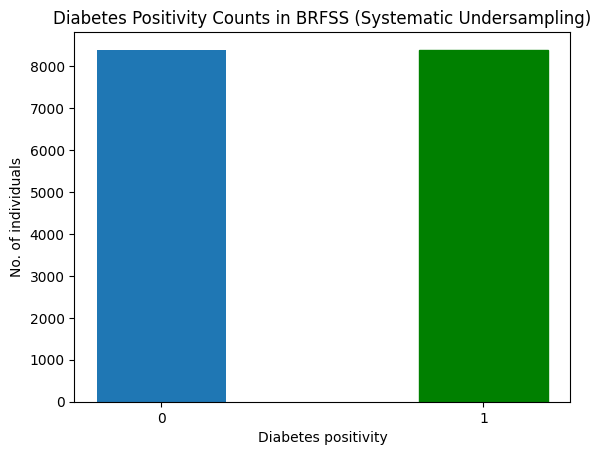

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (13428, 12)
y_S_train: (13428,)
X_S_test: (3358, 12)
y_S_test: (3358,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1169 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1170 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1171 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1172 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1173 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1174 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1175 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - AUC: 0.7054 - loss: 0.6330 - val_AUC: 0.7687 - val_loss: 0.5717
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7782 - loss: 0.5649 - val_AUC: 0.8007 - val_loss: 0.5515
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7986 - loss: 0.5466 - val_AUC: 0.7979 - val_loss: 0.5522
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8010 - loss: 0.5431 - val_AUC: 0.8010 - val_loss: 0.5577
Epoch 5/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8060 - loss: 0.5372 - val_AUC: 0.8059 - val_loss: 0.5374
Epoch 6/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8148 - loss: 0.5262 - val_AUC: 0.8105 - val_loss: 0.5368
Epoch 7/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8172 - loss: 0.5208 - val_AUC: 0.8076 - val_loss: 0.5601
Epoch 8/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8133 - loss: 0.5250 - val_AUC: 0.8151 - val_loss: 0.5267
Epoch 9/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - A

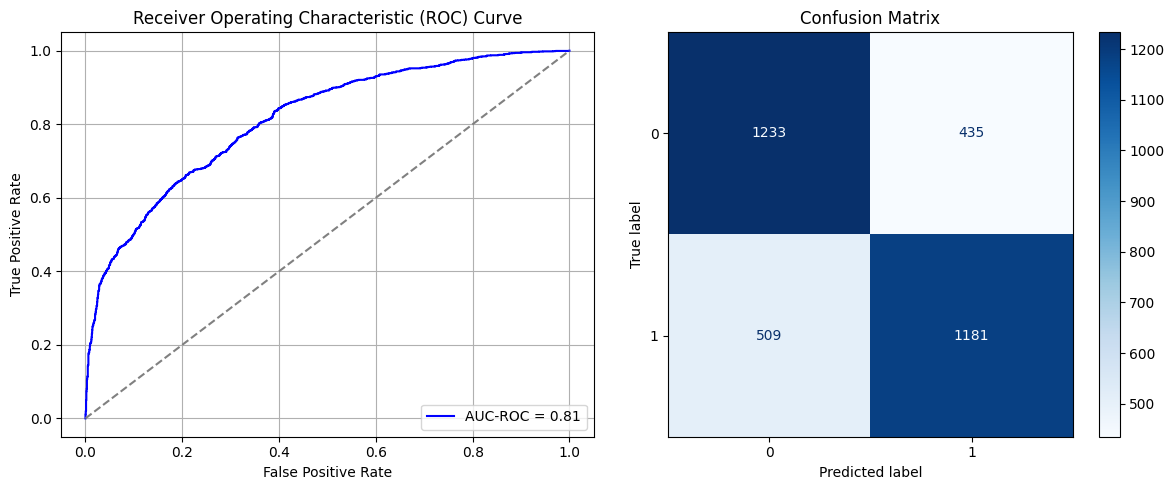

Best threshold based on F1-score: 0.3648473918437958
Time elapsed (performance): 20.481121978000374


<Sequential name=sequential_167, built=True>

In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.580498110543582
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2792
           1       0.23      0.12      0.16       345

    accuracy                           0.86      3137
   macro avg       0.57      0.54      0.54      3137
weighted avg       0.82      0.86      0.84      3137

FPR 0.049068767908309455 TPR: 0.12173913043478257 FNR: 0.8782608695652174 TNR: 0.9509312320916905


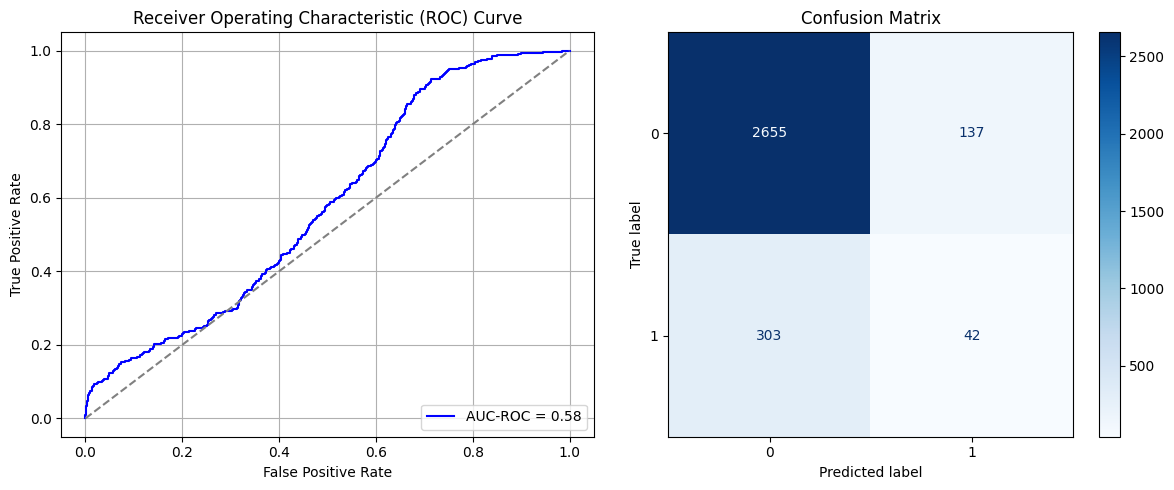

Best threshold based on F1-score: 0.10963694006204605
False Negative Rate: 0.8782608695652174
Time elapsed (performance): 0.9736994830000185


In [ ]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1176 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1177 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1178 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1179 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1180 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1181 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1182 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6304 - loss: 0.3386 - val_AUC: 0.6873 - val_loss: 0.3393
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7241 - loss: 0.3156 - val_AUC: 0.7446 - val_loss: 0.3238
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7689 - loss: 0.2985 - val_AUC: 0.7655 - val_loss: 0.3150
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7775 - loss: 0.2894 - val_AUC: 0.7775 - val_loss: 0.3086
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7896 - loss: 0.2871 - val_AUC: 0.7754 - val_loss: 0.3069
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7936 - loss: 0.2801 - val_AUC: 0.7830 - val_loss: 0.3033
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7922 - loss: 0.2887 - val_AUC: 0.7859 - val_loss: 0.3033
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7982 - loss: 0.2822 - val_AUC: 0.7933 - val_loss: 0.2974
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8004 -

(np.float64(0.004297994269340974), np.float64(0.9130434782608695))

In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1183 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1184 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1185 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1186 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1187 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1188 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1189 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6030 - loss: 0.6543 - val_AUC: 0.0000e+00 - val_loss: 0.9287
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6192 - loss: 0.6231 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6729 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8743
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7109 - loss: 0.5919 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7271 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.8366
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7483 - loss: 0.5688 - val_AUC: 0.0000e+00 - val_loss: 0.7995
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7622 - loss: 0.5683 - val_AUC: 0.0000e+00 - val_loss: 0.8786
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7616 - loss: 0.5578 - val_AUC: 0.0000e+00 - val_loss: 0.8423
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

(np.float64(0.08739255014326648), np.float64(0.5739130434782609))

In [ ]:
times = 50


FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']


# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1204 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1205 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1206 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1207 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1208 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1209 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1210 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6129 - loss: 0.6625 - val_AUC: 0.0000e+00 - val_loss: 0.8968
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6275 - loss: 0.6253 - val_AUC: 0.0000e+00 - val_loss: 0.9387
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6689 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.8742
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6963 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.8917
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7364 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8264
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.7989
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7505 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.7944
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7384 - loss: 0.5695 - val_AUC: 0.0000e+00 - val_loss: 0.8300
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1211 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1212 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1213 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1214 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1215 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1216 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1217 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - AUC: 0.5970 - loss: 0.6668 - val_AUC: 0.0000e+00 - val_loss: 0.9326
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6085 - loss: 0.6253 - val_AUC: 0.0000e+00 - val_loss: 0.8779
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6695 - loss: 0.5957 - val_AUC: 0.0000e+00 - val_loss: 0.8427
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7107 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8290
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7426 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8340
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7564 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.8912
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7488 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.7522
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7612 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.8204
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1218 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1219 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1220 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1221 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1222 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1223 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1224 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.5760 - loss: 0.6813 - val_AUC: 0.0000e+00 - val_loss: 0.8561
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6263 - loss: 0.6133 - val_AUC: 0.0000e+00 - val_loss: 0.9054
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6715 - loss: 0.5901 - val_AUC: 0.0000e+00 - val_loss: 0.8305
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7226 - loss: 0.5799 - val_AUC: 0.0000e+00 - val_loss: 0.8338
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7506 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8405
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7592 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.7707
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7746 - loss: 0.5579 - val_AUC: 0.0000e+00 - val_loss: 0.7693
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7815 - loss: 0.5488 - val_AUC: 0.0000e+00 - val_loss: 0.7828
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1225 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1226 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1227 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1228 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1229 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1230 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1231 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6108 - loss: 0.6844 - val_AUC: 0.0000e+00 - val_loss: 0.9919
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6424 - loss: 0.6153 - val_AUC: 0.0000e+00 - val_loss: 0.8832
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6630 - loss: 0.6102 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6896 - loss: 0.5883 - val_AUC: 0.0000e+00 - val_loss: 0.8344
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7222 - loss: 0.5884 - val_AUC: 0.0000e+00 - val_loss: 0.8006
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7515 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8796
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7564 - loss: 0.5651 - val_AUC: 0.0000e+00 - val_loss: 0.7964
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7738 - loss: 0.5483 - val_AUC: 0.0000e+00 - val_loss: 0.7524
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1232 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1233 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1234 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1235 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1236 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1237 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1238 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5935 - loss: 0.6572 - val_AUC: 0.0000e+00 - val_loss: 0.8942
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6497 - loss: 0.6082 - val_AUC: 0.0000e+00 - val_loss: 0.9071
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6597 - loss: 0.6055 - val_AUC: 0.0000e+00 - val_loss: 0.8537
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7045 - loss: 0.5958 - val_AUC: 0.0000e+00 - val_loss: 0.8198
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7373 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8088
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7347 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8043
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7589 - loss: 0.5635 - val_AUC: 0.0000e+00 - val_loss: 0.8396
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7500 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.7441
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1239 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1240 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1241 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1242 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1243 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1244 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1245 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6149 - loss: 0.6560 - val_AUC: 0.0000e+00 - val_loss: 0.9353
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6383 - loss: 0.6134 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6584 - loss: 0.6043 - val_AUC: 0.0000e+00 - val_loss: 0.8434
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7030 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_loss: 0.8187
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7392 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8082
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7662 - loss: 0.5581 - val_AUC: 0.0000e+00 - val_loss: 0.7597
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7536 - loss: 0.5586 - val_AUC: 0.0000e+00 - val_loss: 0.7708
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7585 - loss: 0.5671 - val_AUC: 0.0000e+00 - val_loss: 0.9454
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1246 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1247 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1248 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1249 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1250 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1251 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1252 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.5957 - loss: 0.6785 - val_AUC: 0.0000e+00 - val_loss: 0.9376
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6182 - loss: 0.6232 - val_AUC: 0.0000e+00 - val_loss: 0.9052
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6713 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.9022
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7035 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.8412
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7430 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.7808
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7418 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8243
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7648 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.8128
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7712 - loss: 0.5598 - val_AUC: 0.0000e+00 - val_loss: 0.7802
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1253 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1254 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1255 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1256 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1257 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1258 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1259 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6047 - loss: 0.6625 - val_AUC: 0.0000e+00 - val_loss: 0.9116
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6285 - loss: 0.6159 - val_AUC: 0.0000e+00 - val_loss: 0.9092
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6701 - loss: 0.5888 - val_AUC: 0.0000e+00 - val_loss: 0.8138
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6959 - loss: 0.5947 - val_AUC: 0.0000e+00 - val_loss: 0.8527
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7317 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8391
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7559 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.8305
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7686 - loss: 0.5634 - val_AUC: 0.0000e+00 - val_loss: 0.8353
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7643 - loss: 0.5569 - val_AUC: 0.0000e+00 - val_loss: 0.7847
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1260 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1261 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1262 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1263 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1264 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1265 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1266 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5874 - loss: 0.6787 - val_AUC: 0.0000e+00 - val_loss: 0.9648
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6177 - loss: 0.6233 - val_AUC: 0.0000e+00 - val_loss: 0.9480
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6670 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8967
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7013 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.8862
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7345 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8228
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7381 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8024
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7650 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.8085
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7776 - loss: 0.5608 - val_AUC: 0.0000e+00 - val_loss: 0.8141
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1267 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1268 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1269 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1270 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1271 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1272 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1273 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.5883 - loss: 0.6781 - val_AUC: 0.0000e+00 - val_loss: 0.9486
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6307 - loss: 0.6126 - val_AUC: 0.0000e+00 - val_loss: 0.8629
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6737 - loss: 0.6099 - val_AUC: 0.0000e+00 - val_loss: 0.9356
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7277 - loss: 0.5832 - val_AUC: 0.0000e+00 - val_loss: 0.8471
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7436 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7631 - loss: 0.5645 - val_AUC: 0.0000e+00 - val_loss: 0.7702
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7533 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.7945
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7751 - loss: 0.5572 - val_AUC: 0.0000e+00 - val_loss: 0.7639
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1274 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1275 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1276 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1277 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1278 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1279 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1280 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6000 - loss: 0.6779 - val_AUC: 0.0000e+00 - val_loss: 0.9462
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6295 - loss: 0.6118 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6636 - loss: 0.6034 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7147 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7425 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8307
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7508 - loss: 0.5819 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7766 - loss: 0.5582 - val_AUC: 0.0000e+00 - val_loss: 0.7783
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7760 - loss: 0.5562 - val_AUC: 0.0000e+00 - val_loss: 0.7980
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1281 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1282 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1283 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1284 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1285 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1286 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1287 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6069 - loss: 0.6611 - val_AUC: 0.0000e+00 - val_loss: 0.8940
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6269 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.9391
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6792 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.8788
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7045 - loss: 0.6064 - val_AUC: 0.0000e+00 - val_loss: 0.8866
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7195 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8273
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7485 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8585
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7548 - loss: 0.5569 - val_AUC: 0.0000e+00 - val_loss: 0.7222
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7691 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.7712
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1288 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1289 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1290 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1291 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1292 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1293 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1294 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6065 - loss: 0.6557 - val_AUC: 0.0000e+00 - val_loss: 0.8945
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6219 - loss: 0.6239 - val_AUC: 0.0000e+00 - val_loss: 0.9228
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6657 - loss: 0.5955 - val_AUC: 0.0000e+00 - val_loss: 0.8054
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7084 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7384 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8827
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7388 - loss: 0.5782 - val_AUC: 0.0000e+00 - val_loss: 0.8272
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7648 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.7434
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7748 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.7745
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1295 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1296 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1297 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1298 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1299 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1300 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1301 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6013 - loss: 0.6760 - val_AUC: 0.0000e+00 - val_loss: 0.9936
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6353 - loss: 0.6150 - val_AUC: 0.0000e+00 - val_loss: 0.9115
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6794 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7168 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8365
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8270
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7378 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.7497
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7565 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.8232
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7816 - loss: 0.5469 - val_AUC: 0.0000e+00 - val_loss: 0.7494
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1302 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1303 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1304 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1305 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1306 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1307 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1308 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6133 - loss: 0.6700 - val_AUC: 0.0000e+00 - val_loss: 0.9894
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6271 - loss: 0.6171 - val_AUC: 0.0000e+00 - val_loss: 0.8959
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6618 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8301
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7033 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.8536
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7282 - loss: 0.5886 - val_AUC: 0.0000e+00 - val_loss: 0.8850
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7410 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8070
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7592 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8114
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7707 - loss: 0.5476 - val_AUC: 0.0000e+00 - val_loss: 0.7682
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1309 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1310 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1311 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1312 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1313 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1314 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1315 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.5872 - loss: 0.6725 - val_AUC: 0.0000e+00 - val_loss: 0.9797
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6346 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.8740
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6829 - loss: 0.5971 - val_AUC: 0.0000e+00 - val_loss: 0.9154
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7112 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.8729
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7302 - loss: 0.5857 - val_AUC: 0.0000e+00 - val_loss: 0.7772
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7538 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.8416
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7598 - loss: 0.5672 - val_AUC: 0.0000e+00 - val_loss: 0.8352
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7611 - loss: 0.5699 - val_AUC: 0.0000e+00 - val_loss: 0.7715
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1316 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1317 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1318 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1319 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1320 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1321 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1322 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - AUC: 0.6078 - loss: 0.6701 - val_AUC: 0.0000e+00 - val_loss: 1.0035
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6401 - loss: 0.6097 - val_AUC: 0.0000e+00 - val_loss: 0.9089
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6601 - loss: 0.6129 - val_AUC: 0.0000e+00 - val_loss: 0.8590
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7188 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8733
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7232 - loss: 0.5825 - val_AUC: 0.0000e+00 - val_loss: 0.8616
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7593 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8521
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7572 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.8130
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7779 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.7862
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1323 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1324 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1325 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1326 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1327 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1328 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1329 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6143 - loss: 0.6638 - val_AUC: 0.0000e+00 - val_loss: 0.9773
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6398 - loss: 0.6040 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6644 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_loss: 0.8464
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6956 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.8143
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7161 - loss: 0.5789 - val_AUC: 0.0000e+00 - val_loss: 0.8414
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.8383
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7604 - loss: 0.5610 - val_AUC: 0.0000e+00 - val_loss: 0.7637
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7711 - loss: 0.5586 - val_AUC: 0.0000e+00 - val_loss: 0.7617
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1330 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1331 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1332 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1333 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1334 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1335 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1336 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6093 - loss: 0.6646 - val_AUC: 0.0000e+00 - val_loss: 0.9503
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6328 - loss: 0.6185 - val_AUC: 0.0000e+00 - val_loss: 0.8826
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6732 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_loss: 0.8548
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6986 - loss: 0.5906 - val_AUC: 0.0000e+00 - val_loss: 0.7806
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7230 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7455 - loss: 0.5834 - val_AUC: 0.0000e+00 - val_loss: 0.7832
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7593 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.7797
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7755 - loss: 0.5520 - val_AUC: 0.0000e+00 - val_loss: 0.7732
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1337 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1338 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1339 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1340 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1341 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1342 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1343 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.6099 - loss: 0.6490 - val_AUC: 0.0000e+00 - val_loss: 0.8854
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6435 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_loss: 0.8425
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6697 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_loss: 0.8388
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7145 - loss: 0.5942 - val_AUC: 0.0000e+00 - val_loss: 0.8587
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7428 - loss: 0.5814 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7635 - loss: 0.5655 - val_AUC: 0.0000e+00 - val_loss: 0.8589
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7569 - loss: 0.5712 - val_AUC: 0.0000e+00 - val_loss: 0.8425
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7728 - loss: 0.5592 - val_AUC: 0.0000e+00 - val_loss: 0.8784
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1344 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1345 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1346 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1347 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1348 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1349 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1350 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6108 - loss: 0.6660 - val_AUC: 0.0000e+00 - val_loss: 0.9366
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6339 - loss: 0.6269 - val_AUC: 0.0000e+00 - val_loss: 0.9529
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6632 - loss: 0.6099 - val_AUC: 0.0000e+00 - val_loss: 0.8833
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6969 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.8435
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7191 - loss: 0.6007 - val_AUC: 0.0000e+00 - val_loss: 0.8827
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5727 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7379 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8053
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7739 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.8544
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1351 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1352 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1353 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1354 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1355 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1356 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1357 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5903 - loss: 0.6773 - val_AUC: 0.0000e+00 - val_loss: 0.9026
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6270 - loss: 0.6155 - val_AUC: 0.0000e+00 - val_loss: 0.8992
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6536 - loss: 0.6161 - val_AUC: 0.0000e+00 - val_loss: 0.8630
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6920 - loss: 0.5875 - val_AUC: 0.0000e+00 - val_loss: 0.8162
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7512 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.8944
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7544 - loss: 0.5656 - val_AUC: 0.0000e+00 - val_loss: 0.8329
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7624 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.7739
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7575 - loss: 0.5672 - val_AUC: 0.0000e+00 - val_loss: 0.7567
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1358 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1359 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1360 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1361 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1362 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1363 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1364 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.5884 - loss: 0.6779 - val_AUC: 0.0000e+00 - val_loss: 0.9352
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6267 - loss: 0.6197 - val_AUC: 0.0000e+00 - val_loss: 0.9433
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6778 - loss: 0.6019 - val_AUC: 0.0000e+00 - val_loss: 0.9621
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7165 - loss: 0.5946 - val_AUC: 0.0000e+00 - val_loss: 0.9148
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7317 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.7881
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7567 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.8612
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7696 - loss: 0.5658 - val_AUC: 0.0000e+00 - val_loss: 0.8476
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7632 - loss: 0.5543 - val_AUC: 0.0000e+00 - val_loss: 0.8260
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1365 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1366 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1367 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1368 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1369 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1370 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1371 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 0.5702 - loss: 0.6864 - val_AUC: 0.0000e+00 - val_loss: 0.9534
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6370 - loss: 0.6100 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6586 - loss: 0.6014 - val_AUC: 0.0000e+00 - val_loss: 0.8710
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6934 - loss: 0.6012 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7365 - loss: 0.5777 - val_AUC: 0.0000e+00 - val_loss: 0.8951
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7523 - loss: 0.5760 - val_AUC: 0.0000e+00 - val_loss: 0.7917
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7615 - loss: 0.5646 - val_AUC: 0.0000e+00 - val_loss: 0.8258
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7627 - loss: 0.5626 - val_AUC: 0.0000e+00 - val_loss: 0.7969
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1372 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1373 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1374 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1375 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1376 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1377 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1378 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5737 - loss: 0.6751 - val_AUC: 0.0000e+00 - val_loss: 0.9150
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6534 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_loss: 0.8317
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6737 - loss: 0.6057 - val_AUC: 0.0000e+00 - val_loss: 0.8651
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6931 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_loss: 0.8117
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7361 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8238
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7541 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8399
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7555 - loss: 0.5765 - val_AUC: 0.0000e+00 - val_loss: 0.7914
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7830 - loss: 0.5441 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1379 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1380 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1381 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1382 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1383 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1384 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1385 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6151 - loss: 0.6569 - val_AUC: 0.0000e+00 - val_loss: 0.9342
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6420 - loss: 0.6105 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6712 - loss: 0.5926 - val_AUC: 0.0000e+00 - val_loss: 0.8314
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7070 - loss: 0.5865 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7239 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.9083
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7467 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.8303
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7544 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.7064
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7676 - loss: 0.5589 - val_AUC: 0.0000e+00 - val_loss: 0.7824
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1386 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1387 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1388 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1389 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1390 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1391 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1392 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.5904 - loss: 0.6701 - val_AUC: 0.0000e+00 - val_loss: 0.9510
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6415 - loss: 0.6121 - val_AUC: 0.0000e+00 - val_loss: 0.8441
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6701 - loss: 0.5945 - val_AUC: 0.0000e+00 - val_loss: 0.8583
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7058 - loss: 0.5839 - val_AUC: 0.0000e+00 - val_loss: 0.8524
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7337 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8600
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7486 - loss: 0.5723 - val_AUC: 0.0000e+00 - val_loss: 0.8041
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7560 - loss: 0.5614 - val_AUC: 0.0000e+00 - val_loss: 0.8044
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7758 - loss: 0.5480 - val_AUC: 0.0000e+00 - val_loss: 0.8215
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1393 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1394 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1395 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1396 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1397 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1398 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1399 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5962 - loss: 0.6617 - val_AUC: 0.0000e+00 - val_loss: 0.9112
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6157 - loss: 0.6192 - val_AUC: 0.0000e+00 - val_loss: 0.9193
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6725 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_loss: 0.8953
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7097 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7257 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8365
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7629 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.9310
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7582 - loss: 0.5743 - val_AUC: 0.0000e+00 - val_loss: 0.8034
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7634 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.7150
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1400 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1401 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1402 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1403 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1404 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1405 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1406 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6096 - loss: 0.6573 - val_AUC: 0.0000e+00 - val_loss: 0.9810
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6373 - loss: 0.6190 - val_AUC: 0.0000e+00 - val_loss: 0.9442
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6484 - loss: 0.6021 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7100 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.8696
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7356 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8649
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7475 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.8346
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7602 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.7885
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7837 - loss: 0.5496 - val_AUC: 0.0000e+00 - val_loss: 0.7079
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1407 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1408 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1409 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1410 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1411 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1412 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1413 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6111 - loss: 0.6596 - val_AUC: 0.0000e+00 - val_loss: 0.9186
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6257 - loss: 0.6176 - val_AUC: 0.0000e+00 - val_loss: 0.8800
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6624 - loss: 0.6010 - val_AUC: 0.0000e+00 - val_loss: 0.9007
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7050 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.8569
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7539 - loss: 0.5730 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7279 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8180
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7661 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.7957
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7668 - loss: 0.5545 - val_AUC: 0.0000e+00 - val_loss: 0.7826
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1414 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1415 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1416 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1417 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1418 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1419 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1420 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5875 - loss: 0.6778 - val_AUC: 0.0000e+00 - val_loss: 0.9163
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6335 - loss: 0.6157 - val_AUC: 0.0000e+00 - val_loss: 0.9291
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6666 - loss: 0.6022 - val_AUC: 0.0000e+00 - val_loss: 0.8792
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7257 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8245
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7377 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8031
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7537 - loss: 0.5816 - val_AUC: 0.0000e+00 - val_loss: 0.8600
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7487 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8632
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7686 - loss: 0.5508 - val_AUC: 0.0000e+00 - val_loss: 0.7814
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1421 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1422 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1423 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1424 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1425 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1426 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1427 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - AUC: 0.6073 - loss: 0.6543 - val_AUC: 0.0000e+00 - val_loss: 0.9293
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6195 - loss: 0.6111 - val_AUC: 0.0000e+00 - val_loss: 0.8222
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6590 - loss: 0.6110 - val_AUC: 0.0000e+00 - val_loss: 0.9151
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6984 - loss: 0.5948 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7222 - loss: 0.5922 - val_AUC: 0.0000e+00 - val_loss: 0.8467
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7421 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8471
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7533 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.8245
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7524 - loss: 0.5734 - val_AUC: 0.0000e+00 - val_loss: 0.8462
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1428 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1429 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1430 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1431 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1432 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1433 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1434 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5915 - loss: 0.6762 - val_AUC: 0.0000e+00 - val_loss: 0.9710
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6193 - loss: 0.6220 - val_AUC: 0.0000e+00 - val_loss: 0.9362
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6590 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8699
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7014 - loss: 0.5847 - val_AUC: 0.0000e+00 - val_loss: 0.8259
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7201 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8035
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7396 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.8185
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7589 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.8353
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7731 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.7983
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1435 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1436 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1437 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1438 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1439 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1440 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1441 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5838 - loss: 0.6823 - val_AUC: 0.0000e+00 - val_loss: 0.9605
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6205 - loss: 0.6240 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6702 - loss: 0.6029 - val_AUC: 0.0000e+00 - val_loss: 0.9141
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7125 - loss: 0.5903 - val_AUC: 0.0000e+00 - val_loss: 0.8082
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7332 - loss: 0.5795 - val_AUC: 0.0000e+00 - val_loss: 0.8182
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7569 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.7862
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7670 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.8607
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7697 - loss: 0.5425 - val_AUC: 0.0000e+00 - val_loss: 0.7600
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1442 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1443 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1444 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1445 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1446 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1447 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1448 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5875 - loss: 0.6913 - val_AUC: 0.0000e+00 - val_loss: 1.0101
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6141 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.9625
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6544 - loss: 0.6138 - val_AUC: 0.0000e+00 - val_loss: 0.8819
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6845 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.8568
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7102 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8003
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7473 - loss: 0.5776 - val_AUC: 0.0000e+00 - val_loss: 0.8354
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7722 - loss: 0.5571 - val_AUC: 0.0000e+00 - val_loss: 0.8736
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7507 - loss: 0.5689 - val_AUC: 0.0000e+00 - val_loss: 0.8438
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1449 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1450 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1451 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1452 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1453 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1454 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1455 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - AUC: 0.6076 - loss: 0.6644 - val_AUC: 0.0000e+00 - val_loss: 0.9113
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6294 - loss: 0.6228 - val_AUC: 0.0000e+00 - val_loss: 0.9171
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6633 - loss: 0.5959 - val_AUC: 0.0000e+00 - val_loss: 0.8256
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7172 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.8871
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7371 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.8096
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7642 - loss: 0.5582 - val_AUC: 0.0000e+00 - val_loss: 0.7776
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7585 - loss: 0.5688 - val_AUC: 0.0000e+00 - val_loss: 0.8204
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7795 - loss: 0.5564 - val_AUC: 0.0000e+00 - val_loss: 0.7620
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1456 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1457 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1458 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1459 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1460 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1461 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1462 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.5912 - loss: 0.6745 - val_AUC: 0.0000e+00 - val_loss: 0.9320
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6295 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.9676
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6705 - loss: 0.5938 - val_AUC: 0.0000e+00 - val_loss: 0.8256
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7120 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.8119
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7386 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8558
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7471 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.8454
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7676 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.8070
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7675 - loss: 0.5511 - val_AUC: 0.0000e+00 - val_loss: 0.7532
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1463 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1464 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1465 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1466 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1467 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1468 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1469 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5895 - loss: 0.6763 - val_AUC: 0.0000e+00 - val_loss: 0.9299
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6204 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.8814
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6668 - loss: 0.6058 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6942 - loss: 0.6034 - val_AUC: 0.0000e+00 - val_loss: 0.7943
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7162 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7460 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.8150
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7544 - loss: 0.5751 - val_AUC: 0.0000e+00 - val_loss: 0.8111
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7817 - loss: 0.5543 - val_AUC: 0.0000e+00 - val_loss: 0.7809
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1470 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1471 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1472 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1473 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1474 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1475 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1476 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 0.5981 - loss: 0.6777 - val_AUC: 0.0000e+00 - val_loss: 0.9128
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6347 - loss: 0.6141 - val_AUC: 0.0000e+00 - val_loss: 0.8762
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6774 - loss: 0.6025 - val_AUC: 0.0000e+00 - val_loss: 0.8548
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7085 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8502
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7192 - loss: 0.5869 - val_AUC: 0.0000e+00 - val_loss: 0.8957
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5654 - val_AUC: 0.0000e+00 - val_loss: 0.7426
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7511 - loss: 0.5707 - val_AUC: 0.0000e+00 - val_loss: 0.7925
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7597 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.7318
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1477 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1478 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1479 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1480 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1481 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1482 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1483 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - AUC: 0.5937 - loss: 0.6860 - val_AUC: 0.0000e+00 - val_loss: 0.9188
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6281 - loss: 0.6173 - val_AUC: 0.0000e+00 - val_loss: 0.9609
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6599 - loss: 0.6119 - val_AUC: 0.0000e+00 - val_loss: 0.8373
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7045 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.9123
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7281 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8328
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7710 - loss: 0.5618 - val_AUC: 0.0000e+00 - val_loss: 0.7666
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7535 - loss: 0.5698 - val_AUC: 0.0000e+00 - val_loss: 0.8210
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7610 - loss: 0.5618 - val_AUC: 0.0000e+00 - val_loss: 0.7640
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1484 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1485 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1486 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1487 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1488 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1489 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1490 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6013 - loss: 0.6592 - val_AUC: 0.0000e+00 - val_loss: 0.9429
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6142 - loss: 0.6262 - val_AUC: 0.0000e+00 - val_loss: 0.8943
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6568 - loss: 0.6073 - val_AUC: 0.0000e+00 - val_loss: 0.8732
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7022 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_loss: 0.9017
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7221 - loss: 0.5868 - val_AUC: 0.0000e+00 - val_loss: 0.8627
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7465 - loss: 0.5774 - val_AUC: 0.0000e+00 - val_loss: 0.7879
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7545 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.8321
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7545 - loss: 0.5662 - val_AUC: 0.0000e+00 - val_loss: 0.8224
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1491 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1492 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1493 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1494 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1495 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1496 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1497 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6080 - loss: 0.6603 - val_AUC: 0.0000e+00 - val_loss: 0.9605
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6551 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6494 - loss: 0.6005 - val_AUC: 0.0000e+00 - val_loss: 0.8384
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6911 - loss: 0.6047 - val_AUC: 0.0000e+00 - val_loss: 0.8772
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7296 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.7970
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7405 - loss: 0.5729 - val_AUC: 0.0000e+00 - val_loss: 0.8141
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7548 - loss: 0.5504 - val_AUC: 0.0000e+00 - val_loss: 0.6961
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7744 - loss: 0.5552 - val_AUC: 0.0000e+00 - val_loss: 0.7216
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1498 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1499 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1500 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1501 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1502 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1503 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1504 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6067 - loss: 0.6524 - val_AUC: 0.0000e+00 - val_loss: 0.9028
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6252 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.8828
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6618 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.8542
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6955 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_loss: 0.8527
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7361 - loss: 0.5713 - val_AUC: 0.0000e+00 - val_loss: 0.8431
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7361 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.7848
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7567 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8194
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7666 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.8677
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1505 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1506 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1507 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1508 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1509 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1510 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1511 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5932 - loss: 0.6594 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6386 - loss: 0.6080 - val_AUC: 0.0000e+00 - val_loss: 0.8908
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6629 - loss: 0.6043 - val_AUC: 0.0000e+00 - val_loss: 0.9058
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7261 - loss: 0.5879 - val_AUC: 0.0000e+00 - val_loss: 0.8819
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7313 - loss: 0.5766 - val_AUC: 0.0000e+00 - val_loss: 0.7997
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7384 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7690 - loss: 0.5607 - val_AUC: 0.0000e+00 - val_loss: 0.8258
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7666 - loss: 0.5605 - val_AUC: 0.0000e+00 - val_loss: 0.7925
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1512 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1513 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1514 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1515 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1516 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1517 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1518 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.5754 - loss: 0.7043 - val_AUC: 0.0000e+00 - val_loss: 0.9681
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6258 - loss: 0.6317 - val_AUC: 0.0000e+00 - val_loss: 0.9965
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6710 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_loss: 0.8214
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7012 - loss: 0.5893 - val_AUC: 0.0000e+00 - val_loss: 0.8210
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7365 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.8333
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7501 - loss: 0.5690 - val_AUC: 0.0000e+00 - val_loss: 0.8455
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7619 - loss: 0.5736 - val_AUC: 0.0000e+00 - val_loss: 0.7429
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7757 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.7954
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1519 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1520 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1521 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1522 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1523 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1524 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1525 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.5958 - loss: 0.6649 - val_AUC: 0.0000e+00 - val_loss: 0.9440
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6508 - loss: 0.6001 - val_AUC: 0.0000e+00 - val_loss: 0.8957
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6424 - loss: 0.6112 - val_AUC: 0.0000e+00 - val_loss: 0.8862
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7109 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8585
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7441 - loss: 0.5717 - val_AUC: 0.0000e+00 - val_loss: 0.7953
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7582 - loss: 0.5773 - val_AUC: 0.0000e+00 - val_loss: 0.8457
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7833 - loss: 0.5621 - val_AUC: 0.0000e+00 - val_loss: 0.8170
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7873 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.7930
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1526 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1527 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1528 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1529 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1530 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1531 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1532 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - AUC: 0.5791 - loss: 0.6897 - val_AUC: 0.0000e+00 - val_loss: 0.9547
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6274 - loss: 0.6223 - val_AUC: 0.0000e+00 - val_loss: 0.9152
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6581 - loss: 0.6117 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6994 - loss: 0.5950 - val_AUC: 0.0000e+00 - val_loss: 0.8882
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7279 - loss: 0.5866 - val_AUC: 0.0000e+00 - val_loss: 0.8300
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7736 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.7429
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7678 - loss: 0.5596 - val_AUC: 0.0000e+00 - val_loss: 0.7959
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7711 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7914
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1533 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1534 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1535 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1536 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1537 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1538 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1539 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6121 - loss: 0.6514 - val_AUC: 0.0000e+00 - val_loss: 0.9031
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6544 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_loss: 0.8623
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6667 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_loss: 0.8342
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7086 - loss: 0.5892 - val_AUC: 0.0000e+00 - val_loss: 0.8237
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7431 - loss: 0.5714 - val_AUC: 0.0000e+00 - val_loss: 0.7794
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7430 - loss: 0.5802 - val_AUC: 0.0000e+00 - val_loss: 0.8562
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7524 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.9033
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7727 - loss: 0.5548 - val_AUC: 0.0000e+00 - val_loss: 0.7848
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_220"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1540 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1541 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1542 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1543 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1544 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1545 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1546 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.5983 - loss: 0.6847 - val_AUC: 0.0000e+00 - val_loss: 0.9478
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6265 - loss: 0.6155 - val_AUC: 0.0000e+00 - val_loss: 0.9142
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6821 - loss: 0.5956 - val_AUC: 0.0000e+00 - val_loss: 0.8960
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7141 - loss: 0.5939 - val_AUC: 0.0000e+00 - val_loss: 0.8572
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7456 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.8043
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7577 - loss: 0.5693 - val_AUC: 0.0000e+00 - val_loss: 0.8413
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7672 - loss: 0.5619 - val_AUC: 0.0000e+00 - val_loss: 0.8725
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7806 - loss: 0.5422 - val_AUC: 0.0000e+00 - val_loss: 0.7379
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1547 (Dense)              │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1548 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1549 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1550 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1551 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1552 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1553 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5700 - loss: 0.6881 - val_AUC: 0.0000e+00 - val_loss: 0.9218
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6340 - loss: 0.6101 - val_AUC: 0.0000e+00 - val_loss: 0.9016
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6810 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.8518
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7073 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8037
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7302 - loss: 0.5918 - val_AUC: 0.0000e+00 - val_loss: 0.8816
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7439 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8354
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7676 - loss: 0.5650 - val_AUC: 0.0000e+00 - val_loss: 0.7585
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7640 - loss: 0.5579 - val_AUC: 0.0000e+00 - val_loss: 0.7927
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_Fine_Tuning.csv')

         FPR       FNR
0   0.085244  0.582609
1   0.116404  0.504348
2   0.098138  0.527536
3   0.114255  0.481159
4   0.148281  0.457971
5   0.114255  0.486957
6   0.064112  0.655072
7   0.131447  0.463768
8   0.097063  0.527536
9   0.136103  0.457971
10  0.111032  0.521739
11  0.102077  0.524638
12  0.117837  0.489855
13  0.154728  0.437681
14  0.082378  0.579710
15  0.047278  0.727536
16  0.131447  0.489855
17  0.090258  0.547826
18  0.083453  0.565217
19  0.077364  0.588406
20  0.068410  0.626087
21  0.092407  0.539130
22  0.143625  0.472464
23  0.122135  0.492754
24  0.130731  0.446377
25  0.092049  0.550725
26  0.112464  0.510145
27  0.058381  0.686957
28  0.090616  0.544928
29  0.097063  0.530435
30  0.112464  0.501449
31  0.095272  0.530435
32  0.112106  0.498551
33  0.085244  0.582609
34  0.100287  0.524638
35  0.117120  0.492754
36  0.125000  0.472464
37  0.138610  0.455072
38  0.070917  0.623188
39  0.082020  0.559420
40  0.139685  0.455072
41  0.105301  0.530435
42  0.10565

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [ ]:
X_S_Sy, y_S_Sy = multi_systematic_undersampler(data_S_full, data_S_full.iloc[:,-1], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = multi_systematic_undersampler(T_train, T_train.iloc[:,-1], 10)
print(y_T_train_Sy)

8393
23544
2.8051948051948052
[2, 4, 7, 10, 13, 16, 18, 21, 24, 27, 30, 32, 35, 38, 41, 44, 46, 49, 52, 55, 58, 60, 63, 66, 69, 72, 74, 77, 80, 83, 86, 88, 91, 94, 97, 100, 102, 105, 108, 111, 114, 117, 119, 122, 125, 128, 131, 133, 136, 139, 142, 145, 147, 150, 153, 156, 159, 161, 164, 167, 170, 173, 175, 178, 181, 184, 187, 189, 192, 195, 198, 201, 203, 206, 209, 212, 215, 218, 220, 223, 226, 229, 232, 234, 237, 240, 243, 246, 248, 251, 254, 257, 260, 262, 265, 268, 271, 274, 276, 279, 282, 285, 288, 290, 293, 296, 299, 302, 304, 307, 310, 313, 316, 318, 321, 324, 327, 330, 333, 335, 338, 341, 344, 347, 349, 352, 355, 358, 361, 363, 366, 369, 372, 375, 377, 380, 383, 386, 389, 391, 394, 397, 400, 403, 405, 408, 411, 414, 417, 419, 422, 425, 428, 431, 434, 436, 439, 442, 445, 448, 450, 453, 456, 459, 462, 464, 467, 470, 473, 476, 478, 481, 484, 487, 490, 492, 495, 498, 501, 504, 506, 509, 512, 515, 518, 520, 523, 526, 529, 532, 534, 537, 540, 543, 546, 549, 551, 554, 557, 560, 563, 56

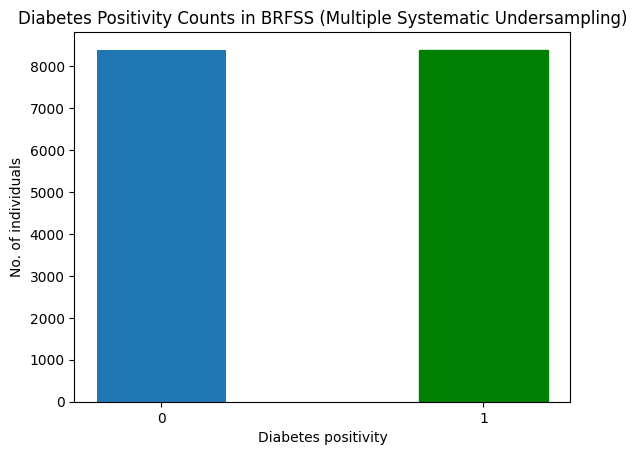

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (13426, 12)
y_S_train: (13426,)
X_S_test: (3357, 12)
y_S_test: (3357,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - AUC: 0.7127 - loss: 0.6289 - val_AUC: 0.7680 - val_loss: 0.5748
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7683 - loss: 0.5726 - val_AUC: 0.7950 - val_loss: 0.5548
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7950 - loss: 0.5515 - val_AUC: 0.8066 - val_loss: 0.5412
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8036 - loss: 0.5395 - val_AUC: 0.8119 - val_loss: 0.5334
Epoch 5/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8061 - loss: 0.5367 - val_AUC: 0.8083 - val_loss: 0.5514
Epoch 6/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8205 - loss: 0.5198 - val_AUC: 0.8222 - val_loss: 0.5219
Epoch 7/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8207 - loss: 0.5192 - val_AUC: 0.8238 - val_loss: 0.5153
Epoch 8/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8293 - loss: 0.5072 - val_AUC: 0.8240 - val_loss: 0.5206
Epoch 9/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - A

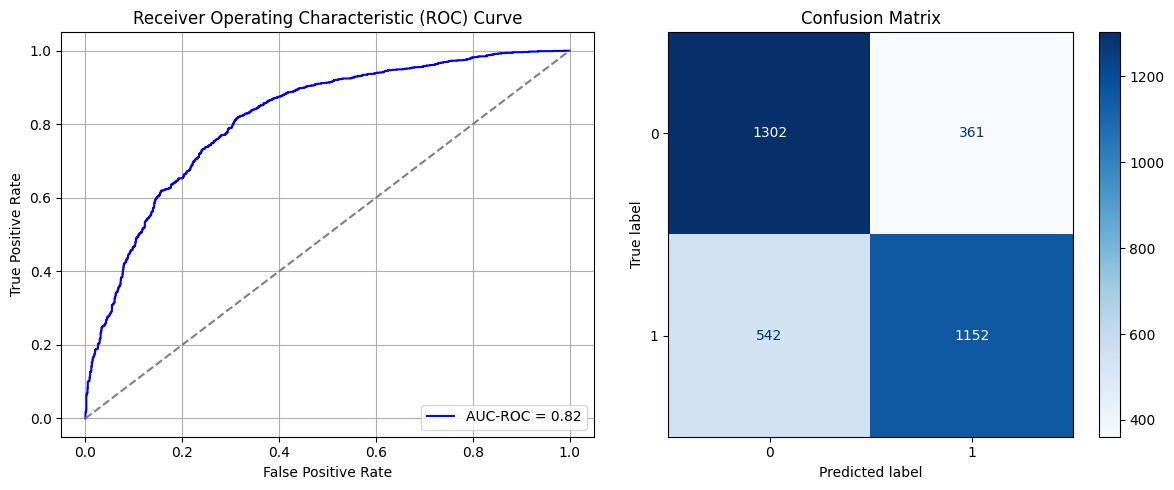

Best threshold based on F1-score: 0.20707391202449799
Time elapsed (performance): 21.17254647199934


<Sequential name=sequential, built=True>

In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.6542606204061294
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      2792
           1       0.17      0.51      0.26       345

    accuracy                           0.67      3137
   macro avg       0.54      0.60      0.52      3137
weighted avg       0.84      0.67      0.73      3137

FPR 0.30945558739255014 TPR: 0.5130434782608695 FNR: 0.48695652173913045 TNR: 0.6905444126074498


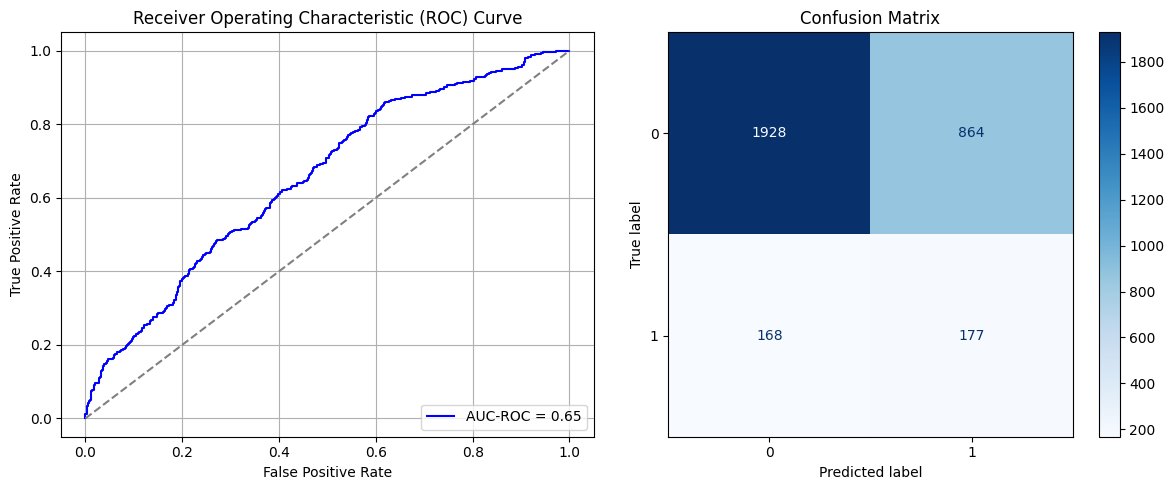

Best threshold based on F1-score: 0.5440340042114258
False Negative Rate: 0.48695652173913045
Time elapsed (performance): 1.2640762299997732


In [ ]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6509 - loss: 0.3818 - val_AUC: 0.7170 - val_loss: 0.3344
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7638 - loss: 0.2935 - val_AUC: 0.7840 - val_loss: 0.3077
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8040 - loss: 0.2796 - val_AUC: 0.7957 - val_loss: 0.3009
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8033 - loss: 0.2688 - val_AUC: 0.8078 - val_loss: 0.2962
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8163 - loss: 0.2661 - val_AUC: 0.8180 - val_loss: 0.3094
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8234 - loss: 0.2622 - val_AUC: 0.8182 - val_loss: 0.2907
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8250 - loss: 0.2763 - val_AUC: 0.8228 - val_loss: 0.2935
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8227 - loss: 0.2787 - val_AUC: 0.8229 - val_loss: 0.2915
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8306 

(np.float64(0.014326647564469915), np.float64(0.8260869565217391))

In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6523 - loss: 0.7022 - val_AUC: 0.0000e+00 - val_loss: 0.9583
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7153 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_loss: 0.9001
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7556 - loss: 0.5718 - val_AUC: 0.0000e+00 - val_loss: 0.8042
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8009 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.8671
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8048 - loss: 0.5309 - val_AUC: 0.0000e+00 - val_loss: 0.8413
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8071 - loss: 0.5218 - val_AUC: 0.0000e+00 - val_loss: 0.7549
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8282 - loss: 0.5068 - val_AUC: 0.0000e+00 - val_loss: 0.6895
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8157 - loss: 0.5165 - val_AUC: 0.0000e+00 - val_loss: 0.6349
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

(np.float64(0.12213467048710602), np.float64(0.3884057971014493))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.6640 - loss: 0.6840 - val_AUC: 0.0000e+00 - val_loss: 0.9420
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6923 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8419
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7679 - loss: 0.5659 - val_AUC: 0.0000e+00 - val_loss: 0.8952
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7713 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.8117
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8004 - loss: 0.5372 - val_AUC: 0.0000e+00 - val_loss: 0.7532
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7976 - loss: 0.5407 - val_AUC: 0.0000e+00 - val_loss: 0.8653
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8119 - loss: 0.5187 - val_AUC: 0.0000e+00 - val_loss: 0.7247
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8153 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6458 - loss: 0.7030 - val_AUC: 0.0000e+00 - val_loss: 0.9688
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7015 - loss: 0.6087 - val_AUC: 0.0000e+00 - val_loss: 0.8364
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7593 - loss: 0.5725 - val_AUC: 0.0000e+00 - val_loss: 0.7768
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7733 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.7510
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8002 - loss: 0.5333 - val_AUC: 0.0000e+00 - val_loss: 0.6654
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8083 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.6650
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8252 - loss: 0.5107 - val_AUC: 0.0000e+00 - val_loss: 0.7170
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8253 - loss: 0.5066 - val_AUC: 0.0000e+00 - val_loss: 0.6703
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6289 - loss: 0.7224 - val_AUC: 0.0000e+00 - val_loss: 0.9122
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7078 - loss: 0.6020 - val_AUC: 0.0000e+00 - val_loss: 0.7990
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7433 - loss: 0.5791 - val_AUC: 0.0000e+00 - val_loss: 0.7394
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7673 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.6850
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7878 - loss: 0.5462 - val_AUC: 0.0000e+00 - val_loss: 0.7422
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8073 - loss: 0.5189 - val_AUC: 0.0000e+00 - val_loss: 0.7977
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8215 - loss: 0.5144 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8010 - loss: 0.5334 - val_AUC: 0.0000e+00 - val_loss: 0.6894
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.6477 - loss: 0.7080 - val_AUC: 0.0000e+00 - val_loss: 1.0573
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7091 - loss: 0.6070 - val_AUC: 0.0000e+00 - val_loss: 0.8910
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7617 - loss: 0.5715 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7775 - loss: 0.5634 - val_AUC: 0.0000e+00 - val_loss: 0.8302
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7956 - loss: 0.5373 - val_AUC: 0.0000e+00 - val_loss: 0.6969
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8176 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.6482
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8051 - loss: 0.5288 - val_AUC: 0.0000e+00 - val_loss: 0.8346
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8031 - loss: 0.5238 - val_AUC: 0.0000e+00 - val_loss: 0.7365
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6490 - loss: 0.7053 - val_AUC: 0.0000e+00 - val_loss: 0.9252
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7080 - loss: 0.5933 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7585 - loss: 0.5672 - val_AUC: 0.0000e+00 - val_loss: 0.8325
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7900 - loss: 0.5526 - val_AUC: 0.0000e+00 - val_loss: 0.7682
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7935 - loss: 0.5510 - val_AUC: 0.0000e+00 - val_loss: 0.7764
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8087 - loss: 0.5271 - val_AUC: 0.0000e+00 - val_loss: 0.7530
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8196 - loss: 0.5205 - val_AUC: 0.0000e+00 - val_loss: 0.7119
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8199 - loss: 0.5085 - val_AUC: 0.0000e+00 - val_loss: 0.6388
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.6538 - loss: 0.7013 - val_AUC: 0.0000e+00 - val_loss: 0.9485
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6992 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.8167
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7597 - loss: 0.5701 - val_AUC: 0.0000e+00 - val_loss: 0.7826
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7593 - loss: 0.5638 - val_AUC: 0.0000e+00 - val_loss: 0.9059
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8044 - loss: 0.5356 - val_AUC: 0.0000e+00 - val_loss: 0.7810
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8199 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.6956
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8278 - loss: 0.5128 - val_AUC: 0.0000e+00 - val_loss: 0.7580
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8182 - loss: 0.5202 - val_AUC: 0.0000e+00 - val_loss: 0.7906
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6337 - loss: 0.7168 - val_AUC: 0.0000e+00 - val_loss: 0.8504
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6825 - loss: 0.6085 - val_AUC: 0.0000e+00 - val_loss: 0.8333
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7680 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_loss: 0.7945
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7731 - loss: 0.5569 - val_AUC: 0.0000e+00 - val_loss: 0.8268
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7862 - loss: 0.5554 - val_AUC: 0.0000e+00 - val_loss: 0.7663
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7939 - loss: 0.5454 - val_AUC: 0.0000e+00 - val_loss: 0.6975
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8121 - loss: 0.5163 - val_AUC: 0.0000e+00 - val_loss: 0.7145
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8159 - loss: 0.5074 - val_AUC: 0.0000e+00 - val_loss: 0.7171
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6443 - loss: 0.7171 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7050 - loss: 0.6040 - val_AUC: 0.0000e+00 - val_loss: 0.9710
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7639 - loss: 0.5653 - val_AUC: 0.0000e+00 - val_loss: 0.7888
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8019 - loss: 0.5425 - val_AUC: 0.0000e+00 - val_loss: 0.7377
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8005 - loss: 0.5389 - val_AUC: 0.0000e+00 - val_loss: 0.8256
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8018 - loss: 0.5406 - val_AUC: 0.0000e+00 - val_loss: 0.7773
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8044 - loss: 0.5293 - val_AUC: 0.0000e+00 - val_loss: 0.7730
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8265 - loss: 0.5051 - val_AUC: 0.0000e+00 - val_loss: 0.6678
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - AUC: 0.6417 - loss: 0.7153 - val_AUC: 0.0000e+00 - val_loss: 0.9788
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7120 - loss: 0.5935 - val_AUC: 0.0000e+00 - val_loss: 0.8458
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7553 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.7889
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7712 - loss: 0.5627 - val_AUC: 0.0000e+00 - val_loss: 0.7281
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7897 - loss: 0.5509 - val_AUC: 0.0000e+00 - val_loss: 0.7085
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7967 - loss: 0.5387 - val_AUC: 0.0000e+00 - val_loss: 0.7383
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8091 - loss: 0.5174 - val_AUC: 0.0000e+00 - val_loss: 0.7203
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8154 - loss: 0.5133 - val_AUC: 0.0000e+00 - val_loss: 0.6558
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6439 - loss: 0.7050 - val_AUC: 0.0000e+00 - val_loss: 0.9489
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7045 - loss: 0.5898 - val_AUC: 0.0000e+00 - val_loss: 0.7382
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7591 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8177
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7717 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.8014
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7964 - loss: 0.5517 - val_AUC: 0.0000e+00 - val_loss: 0.8345
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8091 - loss: 0.5284 - val_AUC: 0.0000e+00 - val_loss: 0.7422
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8023 - loss: 0.5329 - val_AUC: 0.0000e+00 - val_loss: 0.8769
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8234 - loss: 0.5134 - val_AUC: 0.0000e+00 - val_loss: 0.6954
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6469 - loss: 0.7060 - val_AUC: 0.0000e+00 - val_loss: 0.8579
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6928 - loss: 0.6036 - val_AUC: 0.0000e+00 - val_loss: 0.8951
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7487 - loss: 0.5758 - val_AUC: 0.0000e+00 - val_loss: 0.8281
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7806 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.8473
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8082 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.7450
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8112 - loss: 0.5331 - val_AUC: 0.0000e+00 - val_loss: 0.9014
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7939 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.6701
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8230 - loss: 0.5182 - val_AUC: 0.0000e+00 - val_loss: 0.7214
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.6430 - loss: 0.7135 - val_AUC: 0.0000e+00 - val_loss: 0.9563
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6926 - loss: 0.6096 - val_AUC: 0.0000e+00 - val_loss: 1.0480
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7411 - loss: 0.5756 - val_AUC: 0.0000e+00 - val_loss: 0.8094
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7845 - loss: 0.5507 - val_AUC: 0.0000e+00 - val_loss: 0.8666
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7867 - loss: 0.5563 - val_AUC: 0.0000e+00 - val_loss: 0.7646
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7948 - loss: 0.5444 - val_AUC: 0.0000e+00 - val_loss: 0.7740
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8139 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.7610
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8301 - loss: 0.5057 - val_AUC: 0.0000e+00 - val_loss: 0.7740
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - AUC: 0.6512 - loss: 0.6885 - val_AUC: 0.0000e+00 - val_loss: 0.8763
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6958 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.8695
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7531 - loss: 0.5753 - val_AUC: 0.0000e+00 - val_loss: 0.8444
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7923 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.7811
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7966 - loss: 0.5468 - val_AUC: 0.0000e+00 - val_loss: 0.9026
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8117 - loss: 0.5349 - val_AUC: 0.0000e+00 - val_loss: 0.8382
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8280 - loss: 0.5062 - val_AUC: 0.0000e+00 - val_loss: 0.7375
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8206 - loss: 0.5053 - val_AUC: 0.0000e+00 - val_loss: 0.6714
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6483 - loss: 0.7062 - val_AUC: 0.0000e+00 - val_loss: 0.9756
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6931 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_loss: 0.7869
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7416 - loss: 0.5703 - val_AUC: 0.0000e+00 - val_loss: 0.7732
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7831 - loss: 0.5543 - val_AUC: 0.0000e+00 - val_loss: 0.7916
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8033 - loss: 0.5384 - val_AUC: 0.0000e+00 - val_loss: 0.7979
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8022 - loss: 0.5423 - val_AUC: 0.0000e+00 - val_loss: 0.8070
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8192 - loss: 0.5123 - val_AUC: 0.0000e+00 - val_loss: 0.6352
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8131 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.7000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - AUC: 0.6531 - loss: 0.6994 - val_AUC: 0.0000e+00 - val_loss: 0.8598
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7278 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.8764
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7625 - loss: 0.5680 - val_AUC: 0.0000e+00 - val_loss: 0.7662
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7749 - loss: 0.5609 - val_AUC: 0.0000e+00 - val_loss: 0.8593
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7872 - loss: 0.5499 - val_AUC: 0.0000e+00 - val_loss: 0.7421
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7954 - loss: 0.5435 - val_AUC: 0.0000e+00 - val_loss: 0.7381
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8090 - loss: 0.5247 - val_AUC: 0.0000e+00 - val_loss: 0.6800
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8229 - loss: 0.5069 - val_AUC: 0.0000e+00 - val_loss: 0.7932
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6710 - loss: 0.6787 - val_AUC: 0.0000e+00 - val_loss: 0.8585
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7142 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.7924
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7591 - loss: 0.5649 - val_AUC: 0.0000e+00 - val_loss: 0.7143
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7816 - loss: 0.5559 - val_AUC: 0.0000e+00 - val_loss: 0.6826
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8023 - loss: 0.5418 - val_AUC: 0.0000e+00 - val_loss: 0.7318
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8031 - loss: 0.5259 - val_AUC: 0.0000e+00 - val_loss: 0.7474
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8154 - loss: 0.5190 - val_AUC: 0.0000e+00 - val_loss: 0.7401
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8395 - loss: 0.4826 - val_AUC: 0.0000e+00 - val_loss: 0.6850
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6709 - loss: 0.6737 - val_AUC: 0.0000e+00 - val_loss: 0.9381
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6849 - loss: 0.6076 - val_AUC: 0.0000e+00 - val_loss: 0.7716
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7594 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.8275
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7839 - loss: 0.5555 - val_AUC: 0.0000e+00 - val_loss: 0.8250
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7881 - loss: 0.5430 - val_AUC: 0.0000e+00 - val_loss: 0.9198
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7928 - loss: 0.5383 - val_AUC: 0.0000e+00 - val_loss: 0.7245
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8196 - loss: 0.5081 - val_AUC: 0.0000e+00 - val_loss: 0.8095
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8188 - loss: 0.5127 - val_AUC: 0.0000e+00 - val_loss: 0.7302
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6669 - loss: 0.6817 - val_AUC: 0.0000e+00 - val_loss: 0.9084
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6855 - loss: 0.6129 - val_AUC: 0.0000e+00 - val_loss: 0.8824
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7602 - loss: 0.5644 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7907 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.8585
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8020 - loss: 0.5362 - val_AUC: 0.0000e+00 - val_loss: 0.7370
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8057 - loss: 0.5300 - val_AUC: 0.0000e+00 - val_loss: 0.7476
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8059 - loss: 0.5228 - val_AUC: 0.0000e+00 - val_loss: 0.7587
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8054 - loss: 0.5219 - val_AUC: 0.0000e+00 - val_loss: 0.7286
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_161 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.6541 - loss: 0.6867 - val_AUC: 0.0000e+00 - val_loss: 0.8575
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7271 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8424
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7580 - loss: 0.5733 - val_AUC: 0.0000e+00 - val_loss: 0.8230
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7720 - loss: 0.5508 - val_AUC: 0.0000e+00 - val_loss: 0.7992
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8036 - loss: 0.5344 - val_AUC: 0.0000e+00 - val_loss: 0.7794
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7972 - loss: 0.5345 - val_AUC: 0.0000e+00 - val_loss: 0.7306
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8070 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.7187
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8078 - loss: 0.5338 - val_AUC: 0.0000e+00 - val_loss: 0.7614
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6611 - loss: 0.6869 - val_AUC: 0.0000e+00 - val_loss: 0.8571
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6934 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_loss: 0.7784
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7499 - loss: 0.5722 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7762 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.8804
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7973 - loss: 0.5413 - val_AUC: 0.0000e+00 - val_loss: 0.7860
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8056 - loss: 0.5320 - val_AUC: 0.0000e+00 - val_loss: 0.7895
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8039 - loss: 0.5207 - val_AUC: 0.0000e+00 - val_loss: 0.7578
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8152 - loss: 0.5209 - val_AUC: 0.0000e+00 - val_loss: 0.7541
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6268 - loss: 0.7220 - val_AUC: 0.0000e+00 - val_loss: 0.8673
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6800 - loss: 0.6134 - val_AUC: 0.0000e+00 - val_loss: 0.7472
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7427 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.7688
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7707 - loss: 0.5652 - val_AUC: 0.0000e+00 - val_loss: 0.7998
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7956 - loss: 0.5421 - val_AUC: 0.0000e+00 - val_loss: 0.8440
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8122 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.8388
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8184 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.6732
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8060 - loss: 0.5265 - val_AUC: 0.0000e+00 - val_loss: 0.6367
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 0.6430 - loss: 0.7166 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7001 - loss: 0.6098 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7486 - loss: 0.5771 - val_AUC: 0.0000e+00 - val_loss: 0.7645
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7852 - loss: 0.5501 - val_AUC: 0.0000e+00 - val_loss: 0.8045
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8024 - loss: 0.5383 - val_AUC: 0.0000e+00 - val_loss: 0.7300
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8243 - loss: 0.5230 - val_AUC: 0.0000e+00 - val_loss: 0.7580
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8062 - loss: 0.5329 - val_AUC: 0.0000e+00 - val_loss: 0.8914
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8056 - loss: 0.5274 - val_AUC: 0.0000e+00 - val_loss: 0.7468
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6860 - loss: 0.6590 - val_AUC: 0.0000e+00 - val_loss: 0.9277
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6832 - loss: 0.6136 - val_AUC: 0.0000e+00 - val_loss: 0.8119
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7652 - loss: 0.5676 - val_AUC: 0.0000e+00 - val_loss: 0.8266
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7879 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.8272
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7944 - loss: 0.5389 - val_AUC: 0.0000e+00 - val_loss: 0.6466
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7916 - loss: 0.5469 - val_AUC: 0.0000e+00 - val_loss: 0.8075
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8059 - loss: 0.5229 - val_AUC: 0.0000e+00 - val_loss: 0.7815
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8175 - loss: 0.5056 - val_AUC: 0.0000e+00 - val_loss: 0.6946
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 0.6418 - loss: 0.7182 - val_AUC: 0.0000e+00 - val_loss: 1.0205
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6867 - loss: 0.6029 - val_AUC: 0.0000e+00 - val_loss: 0.8812
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7409 - loss: 0.5798 - val_AUC: 0.0000e+00 - val_loss: 0.7675
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.7859 - loss: 0.5489 - val_AUC: 0.0000e+00 - val_loss: 0.8446
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7922 - loss: 0.5371 - val_AUC: 0.0000e+00 - val_loss: 0.8095
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7791 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.6873
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8150 - loss: 0.5177 - val_AUC: 0.0000e+00 - val_loss: 0.7069
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8070 - loss: 0.5213 - val_AUC: 0.0000e+00 - val_loss: 0.6971
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6723 - loss: 0.6857 - val_AUC: 0.0000e+00 - val_loss: 0.8999
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7112 - loss: 0.5925 - val_AUC: 0.0000e+00 - val_loss: 0.8136
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7363 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.7919
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7784 - loss: 0.5590 - val_AUC: 0.0000e+00 - val_loss: 0.7576
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7903 - loss: 0.5469 - val_AUC: 0.0000e+00 - val_loss: 0.7468
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8055 - loss: 0.5339 - val_AUC: 0.0000e+00 - val_loss: 0.7713
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8268 - loss: 0.5020 - val_AUC: 0.0000e+00 - val_loss: 0.6575
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8216 - loss: 0.5021 - val_AUC: 0.0000e+00 - val_loss: 0.7591
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6452 - loss: 0.7124 - val_AUC: 0.0000e+00 - val_loss: 0.9603
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7090 - loss: 0.5861 - val_AUC: 0.0000e+00 - val_loss: 0.7966
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7590 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7843 - loss: 0.5584 - val_AUC: 0.0000e+00 - val_loss: 0.7418
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7943 - loss: 0.5392 - val_AUC: 0.0000e+00 - val_loss: 0.7316
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8050 - loss: 0.5267 - val_AUC: 0.0000e+00 - val_loss: 0.6889
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8228 - loss: 0.5077 - val_AUC: 0.0000e+00 - val_loss: 0.6442
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8101 - loss: 0.5185 - val_AUC: 0.0000e+00 - val_loss: 0.5501
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6473 - loss: 0.7046 - val_AUC: 0.0000e+00 - val_loss: 0.9457
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6942 - loss: 0.6038 - val_AUC: 0.0000e+00 - val_loss: 0.8609
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7632 - loss: 0.5708 - val_AUC: 0.0000e+00 - val_loss: 0.8082
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7777 - loss: 0.5589 - val_AUC: 0.0000e+00 - val_loss: 0.6813
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8038 - loss: 0.5384 - val_AUC: 0.0000e+00 - val_loss: 0.7437
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8006 - loss: 0.5290 - val_AUC: 0.0000e+00 - val_loss: 0.7717
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8102 - loss: 0.5201 - val_AUC: 0.0000e+00 - val_loss: 0.7681
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8245 - loss: 0.5026 - val_AUC: 0.0000e+00 - val_loss: 0.9322
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 0.6598 - loss: 0.6881 - val_AUC: 0.0000e+00 - val_loss: 0.9321
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7010 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_loss: 0.8063
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7366 - loss: 0.5843 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7776 - loss: 0.5581 - val_AUC: 0.0000e+00 - val_loss: 0.7929
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7955 - loss: 0.5321 - val_AUC: 0.0000e+00 - val_loss: 0.7668
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8189 - loss: 0.5201 - val_AUC: 0.0000e+00 - val_loss: 0.8256
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8158 - loss: 0.5187 - val_AUC: 0.0000e+00 - val_loss: 0.6563
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8051 - loss: 0.5195 - val_AUC: 0.0000e+00 - val_loss: 0.7604
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.6444 - loss: 0.7138 - val_AUC: 0.0000e+00 - val_loss: 0.9337
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6884 - loss: 0.6035 - val_AUC: 0.0000e+00 - val_loss: 0.8042
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7414 - loss: 0.5842 - val_AUC: 0.0000e+00 - val_loss: 0.8240
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7858 - loss: 0.5568 - val_AUC: 0.0000e+00 - val_loss: 0.8928
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8075 - loss: 0.5327 - val_AUC: 0.0000e+00 - val_loss: 0.7499
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8174 - loss: 0.5218 - val_AUC: 0.0000e+00 - val_loss: 0.7477
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8274 - loss: 0.5024 - val_AUC: 0.0000e+00 - val_loss: 0.6485
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8197 - loss: 0.5062 - val_AUC: 0.0000e+00 - val_loss: 0.7423
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6529 - loss: 0.6933 - val_AUC: 0.0000e+00 - val_loss: 0.8365
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6929 - loss: 0.6081 - val_AUC: 0.0000e+00 - val_loss: 0.7719
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7606 - loss: 0.5607 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7785 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.7348
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7893 - loss: 0.5444 - val_AUC: 0.0000e+00 - val_loss: 0.7009
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8089 - loss: 0.5178 - val_AUC: 0.0000e+00 - val_loss: 0.6978
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8238 - loss: 0.5045 - val_AUC: 0.0000e+00 - val_loss: 0.6989
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8156 - loss: 0.5202 - val_AUC: 0.0000e+00 - val_loss: 0.7104
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6489 - loss: 0.7146 - val_AUC: 0.0000e+00 - val_loss: 0.9141
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7030 - loss: 0.6005 - val_AUC: 0.0000e+00 - val_loss: 0.8656
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7506 - loss: 0.5750 - val_AUC: 0.0000e+00 - val_loss: 0.9380
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7666 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.7209
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7991 - loss: 0.5402 - val_AUC: 0.0000e+00 - val_loss: 0.7325
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8128 - loss: 0.5195 - val_AUC: 0.0000e+00 - val_loss: 0.7394
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8209 - loss: 0.5092 - val_AUC: 0.0000e+00 - val_loss: 0.6602
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8136 - loss: 0.5209 - val_AUC: 0.0000e+00 - val_loss: 0.5948
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - AUC: 0.6595 - loss: 0.6960 - val_AUC: 0.0000e+00 - val_loss: 0.9872
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6867 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_loss: 0.8484
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7595 - loss: 0.5711 - val_AUC: 0.0000e+00 - val_loss: 0.8845
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7801 - loss: 0.5505 - val_AUC: 0.0000e+00 - val_loss: 0.6704
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7969 - loss: 0.5397 - val_AUC: 0.0000e+00 - val_loss: 0.7004
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8091 - loss: 0.5267 - val_AUC: 0.0000e+00 - val_loss: 0.8347
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8152 - loss: 0.5240 - val_AUC: 0.0000e+00 - val_loss: 0.8069
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8271 - loss: 0.5057 - val_AUC: 0.0000e+00 - val_loss: 0.7912
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_259 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.6357 - loss: 0.7215 - val_AUC: 0.0000e+00 - val_loss: 0.8741
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6917 - loss: 0.6105 - val_AUC: 0.0000e+00 - val_loss: 0.8731
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7465 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.7120
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7721 - loss: 0.5706 - val_AUC: 0.0000e+00 - val_loss: 0.9527
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7933 - loss: 0.5392 - val_AUC: 0.0000e+00 - val_loss: 0.7376
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8009 - loss: 0.5318 - val_AUC: 0.0000e+00 - val_loss: 0.6741
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8322 - loss: 0.5007 - val_AUC: 0.0000e+00 - val_loss: 0.7823
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8377 - loss: 0.4991 - val_AUC: 0.0000e+00 - val_loss: 0.8012
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6396 - loss: 0.7112 - val_AUC: 0.0000e+00 - val_loss: 0.8843
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6885 - loss: 0.6083 - val_AUC: 0.0000e+00 - val_loss: 0.7935
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7529 - loss: 0.5641 - val_AUC: 0.0000e+00 - val_loss: 0.8146
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7705 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.7948
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8117 - loss: 0.5228 - val_AUC: 0.0000e+00 - val_loss: 0.6517
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8090 - loss: 0.5331 - val_AUC: 0.0000e+00 - val_loss: 0.8124
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8157 - loss: 0.5171 - val_AUC: 0.0000e+00 - val_loss: 0.8106
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8158 - loss: 0.5086 - val_AUC: 0.0000e+00 - val_loss: 0.7003
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6596 - loss: 0.6934 - val_AUC: 0.0000e+00 - val_loss: 0.8195
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6939 - loss: 0.6015 - val_AUC: 0.0000e+00 - val_loss: 0.8049
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7459 - loss: 0.5824 - val_AUC: 0.0000e+00 - val_loss: 0.8451
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7807 - loss: 0.5548 - val_AUC: 0.0000e+00 - val_loss: 0.7967
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7997 - loss: 0.5426 - val_AUC: 0.0000e+00 - val_loss: 0.8965
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8109 - loss: 0.5276 - val_AUC: 0.0000e+00 - val_loss: 0.7060
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8134 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.6922
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8132 - loss: 0.5277 - val_AUC: 0.0000e+00 - val_loss: 0.6721
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.6427 - loss: 0.7048 - val_AUC: 0.0000e+00 - val_loss: 0.9894
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7129 - loss: 0.5889 - val_AUC: 0.0000e+00 - val_loss: 0.9365
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7461 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.7692
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7764 - loss: 0.5602 - val_AUC: 0.0000e+00 - val_loss: 0.7845
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7921 - loss: 0.5460 - val_AUC: 0.0000e+00 - val_loss: 0.7008
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8087 - loss: 0.5329 - val_AUC: 0.0000e+00 - val_loss: 0.7298
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8121 - loss: 0.5268 - val_AUC: 0.0000e+00 - val_loss: 0.6852
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8152 - loss: 0.5044 - val_AUC: 0.0000e+00 - val_loss: 0.6763
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6493 - loss: 0.6983 - val_AUC: 0.0000e+00 - val_loss: 0.7804
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6837 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_loss: 0.8301
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7235 - loss: 0.5867 - val_AUC: 0.0000e+00 - val_loss: 0.8141
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7704 - loss: 0.5603 - val_AUC: 0.0000e+00 - val_loss: 0.7979
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8055 - loss: 0.5341 - val_AUC: 0.0000e+00 - val_loss: 0.8169
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7917 - loss: 0.5441 - val_AUC: 0.0000e+00 - val_loss: 0.7536
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8020 - loss: 0.5260 - val_AUC: 0.0000e+00 - val_loss: 0.6998
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8009 - loss: 0.5299 - val_AUC: 0.0000e+00 - val_loss: 0.6587
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 0.6502 - loss: 0.7021 - val_AUC: 0.0000e+00 - val_loss: 0.8875
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6829 - loss: 0.6126 - val_AUC: 0.0000e+00 - val_loss: 0.9638
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7430 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.7680
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7838 - loss: 0.5532 - val_AUC: 0.0000e+00 - val_loss: 0.8245
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7859 - loss: 0.5396 - val_AUC: 0.0000e+00 - val_loss: 0.7327
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7943 - loss: 0.5448 - val_AUC: 0.0000e+00 - val_loss: 0.7755
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8242 - loss: 0.5098 - val_AUC: 0.0000e+00 - val_loss: 0.7818
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8178 - loss: 0.5131 - val_AUC: 0.0000e+00 - val_loss: 0.6982
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - AUC: 0.6391 - loss: 0.7095 - val_AUC: 0.0000e+00 - val_loss: 0.9187
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7117 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_loss: 0.8515
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7485 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.7545
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7751 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.8727
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8003 - loss: 0.5335 - val_AUC: 0.0000e+00 - val_loss: 0.6709
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8079 - loss: 0.5339 - val_AUC: 0.0000e+00 - val_loss: 0.8073
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8088 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.6684
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8274 - loss: 0.5073 - val_AUC: 0.0000e+00 - val_loss: 0.7751
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.6373 - loss: 0.7013 - val_AUC: 0.0000e+00 - val_loss: 0.8351
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6982 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_loss: 0.7813
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7615 - loss: 0.5757 - val_AUC: 0.0000e+00 - val_loss: 0.7846
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7867 - loss: 0.5552 - val_AUC: 0.0000e+00 - val_loss: 0.8537
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7911 - loss: 0.5447 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8092 - loss: 0.5274 - val_AUC: 0.0000e+00 - val_loss: 0.7727
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8142 - loss: 0.5082 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8216 - loss: 0.5137 - val_AUC: 0.0000e+00 - val_loss: 0.9335
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6176 - loss: 0.7311 - val_AUC: 0.0000e+00 - val_loss: 0.8758
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6795 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_loss: 0.8283
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7347 - loss: 0.5862 - val_AUC: 0.0000e+00 - val_loss: 0.9116
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7772 - loss: 0.5581 - val_AUC: 0.0000e+00 - val_loss: 0.8049
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7995 - loss: 0.5420 - val_AUC: 0.0000e+00 - val_loss: 0.7638
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8128 - loss: 0.5247 - val_AUC: 0.0000e+00 - val_loss: 0.8023
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8222 - loss: 0.5086 - val_AUC: 0.0000e+00 - val_loss: 0.7133
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8295 - loss: 0.5044 - val_AUC: 0.0000e+00 - val_loss: 0.7688
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - AUC: 0.6451 - loss: 0.7039 - val_AUC: 0.0000e+00 - val_loss: 0.8739
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7042 - loss: 0.5924 - val_AUC: 0.0000e+00 - val_loss: 0.9710
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7441 - loss: 0.5845 - val_AUC: 0.0000e+00 - val_loss: 0.8472
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7894 - loss: 0.5419 - val_AUC: 0.0000e+00 - val_loss: 0.8232
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7940 - loss: 0.5390 - val_AUC: 0.0000e+00 - val_loss: 0.6690
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7982 - loss: 0.5338 - val_AUC: 0.0000e+00 - val_loss: 0.8097
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8026 - loss: 0.5281 - val_AUC: 0.0000e+00 - val_loss: 0.6904
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8198 - loss: 0.5084 - val_AUC: 0.0000e+00 - val_loss: 0.7172
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_329 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6427 - loss: 0.7199 - val_AUC: 0.0000e+00 - val_loss: 0.9684
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.6805 - loss: 0.6062 - val_AUC: 0.0000e+00 - val_loss: 0.8732
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7464 - loss: 0.5745 - val_AUC: 0.0000e+00 - val_loss: 0.7848
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7910 - loss: 0.5483 - val_AUC: 0.0000e+00 - val_loss: 0.7381
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8045 - loss: 0.5376 - val_AUC: 0.0000e+00 - val_loss: 0.9209
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8083 - loss: 0.5265 - val_AUC: 0.0000e+00 - val_loss: 0.6039
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7932 - loss: 0.5318 - val_AUC: 0.0000e+00 - val_loss: 0.7586
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8276 - loss: 0.5022 - val_AUC: 0.0000e+00 - val_loss: 0.7908
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6632 - loss: 0.6897 - val_AUC: 0.0000e+00 - val_loss: 0.9004
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7217 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.7482
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7697 - loss: 0.5682 - val_AUC: 0.0000e+00 - val_loss: 0.9503
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7773 - loss: 0.5623 - val_AUC: 0.0000e+00 - val_loss: 0.8066
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8025 - loss: 0.5358 - val_AUC: 0.0000e+00 - val_loss: 0.7431
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8017 - loss: 0.5289 - val_AUC: 0.0000e+00 - val_loss: 0.7637
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8081 - loss: 0.5263 - val_AUC: 0.0000e+00 - val_loss: 0.7971
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8102 - loss: 0.5170 - val_AUC: 0.0000e+00 - val_loss: 0.6820
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - AUC: 0.6312 - loss: 0.7161 - val_AUC: 0.0000e+00 - val_loss: 0.8532
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7030 - loss: 0.5981 - val_AUC: 0.0000e+00 - val_loss: 0.8168
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7489 - loss: 0.5747 - val_AUC: 0.0000e+00 - val_loss: 0.8085
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7958 - loss: 0.5386 - val_AUC: 0.0000e+00 - val_loss: 0.7328
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7963 - loss: 0.5443 - val_AUC: 0.0000e+00 - val_loss: 0.8174
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7966 - loss: 0.5349 - val_AUC: 0.0000e+00 - val_loss: 0.7705
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7978 - loss: 0.5276 - val_AUC: 0.0000e+00 - val_loss: 0.6922
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8242 - loss: 0.5094 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - AUC: 0.6682 - loss: 0.6810 - val_AUC: 0.0000e+00 - val_loss: 1.0025
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6949 - loss: 0.6033 - val_AUC: 0.0000e+00 - val_loss: 0.8096
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7411 - loss: 0.5826 - val_AUC: 0.0000e+00 - val_loss: 0.7663
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7799 - loss: 0.5525 - val_AUC: 0.0000e+00 - val_loss: 0.8749
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7944 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.8452
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8073 - loss: 0.5317 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8186 - loss: 0.5133 - val_AUC: 0.0000e+00 - val_loss: 0.6796
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8083 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.8185
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - AUC: 0.6697 - loss: 0.6738 - val_AUC: 0.0000e+00 - val_loss: 0.8598
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7096 - loss: 0.5936 - val_AUC: 0.0000e+00 - val_loss: 0.8473
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7576 - loss: 0.5664 - val_AUC: 0.0000e+00 - val_loss: 0.7872
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7944 - loss: 0.5428 - val_AUC: 0.0000e+00 - val_loss: 0.6540
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7995 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.7662
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8070 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.7886
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8283 - loss: 0.5104 - val_AUC: 0.0000e+00 - val_loss: 0.8774
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8175 - loss: 0.5150 - val_AUC: 0.0000e+00 - val_loss: 0.6684
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.6422 - loss: 0.7159 - val_AUC: 0.0000e+00 - val_loss: 0.8662
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6797 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.9202
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7390 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8511
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7729 - loss: 0.5519 - val_AUC: 0.0000e+00 - val_loss: 0.6972
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8056 - loss: 0.5295 - val_AUC: 0.0000e+00 - val_loss: 0.7355
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8218 - loss: 0.5149 - val_AUC: 0.0000e+00 - val_loss: 0.6982
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7964 - loss: 0.5239 - val_AUC: 0.0000e+00 - val_loss: 0.9254
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8125 - loss: 0.5189 - val_AUC: 0.0000e+00 - val_loss: 0.6641
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - AUC: 0.6456 - loss: 0.6935 - val_AUC: 0.0000e+00 - val_loss: 0.8794
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7088 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.8164
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7546 - loss: 0.5775 - val_AUC: 0.0000e+00 - val_loss: 0.8550
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7614 - loss: 0.5685 - val_AUC: 0.0000e+00 - val_loss: 0.7485
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8061 - loss: 0.5352 - val_AUC: 0.0000e+00 - val_loss: 0.7641
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8024 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.6920
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8046 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.6941
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8129 - loss: 0.5176 - val_AUC: 0.0000e+00 - val_loss: 0.8058
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_378 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.6409 - loss: 0.7116 - val_AUC: 0.0000e+00 - val_loss: 1.0476
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7064 - loss: 0.5904 - val_AUC: 0.0000e+00 - val_loss: 0.8891
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7802 - loss: 0.5633 - val_AUC: 0.0000e+00 - val_loss: 0.7578
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7838 - loss: 0.5561 - val_AUC: 0.0000e+00 - val_loss: 0.8118
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7913 - loss: 0.5421 - val_AUC: 0.0000e+00 - val_loss: 0.8218
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7832 - loss: 0.5466 - val_AUC: 0.0000e+00 - val_loss: 0.7403
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8032 - loss: 0.5281 - val_AUC: 0.0000e+00 - val_loss: 0.8716
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8212 - loss: 0.5010 - val_AUC: 0.0000e+00 - val_loss: 0.7119
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_multi_Fine_Tuning.csv')

         FPR       FNR
0   0.129298  0.373913
1   0.112464  0.391304
2   0.092765  0.437681
3   0.176576  0.304348
4   0.120344  0.388406
5   0.139327  0.350725
6   0.125358  0.379710
7   0.116046  0.394203
8   0.108883  0.402899
9   0.094556  0.428986
10  0.140043  0.353623
11  0.146490  0.330435
12  0.119628  0.388406
13  0.183023  0.301449
14  0.105659  0.408696
15  0.140401  0.342029
16  0.165473  0.310145
17  0.152579  0.321739
18  0.107808  0.400000
19  0.116404  0.394203
20  0.132521  0.373913
21  0.183381  0.298551
22  0.117120  0.394203
23  0.104585  0.411594
24  0.131089  0.373913
25  0.108166  0.400000
26  0.142550  0.336232
27  0.170129  0.304348
28  0.094198  0.428986
29  0.178009  0.301449
30  0.149355  0.336232
31  0.100645  0.420290
32  0.135387  0.368116
33  0.146490  0.339130
34  0.135745  0.362319
35  0.113539  0.394203
36  0.132521  0.373913
37  0.133238  0.371014
38  0.135745  0.365217
39  0.189470  0.298551
40  0.125358  0.385507
41  0.136819  0.353623
42  0.13502

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
X_S_SRS, y_S_SRS = SRSwR_oversampler(data_S_full, data_S_full.iloc[:, -1])
print(y_S_SRS)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRSwR_oversampler(T_train, T_train.iloc[:, -1])
print(y_T_train_SRS)

8393
23544
2        0
3        0
4        0
6        0
8        0
        ..
31314    1
5624     1
14979    1
22390    1
10216    1
Name: Y2, Length: 47088, dtype: int64
1391
11156
14490    0
4908     0
11461    0
2455     0
13540    0
        ..
15527    1
3887     1
3236     1
1163     1
11956    1
Name: Y, Length: 22312, dtype: int64


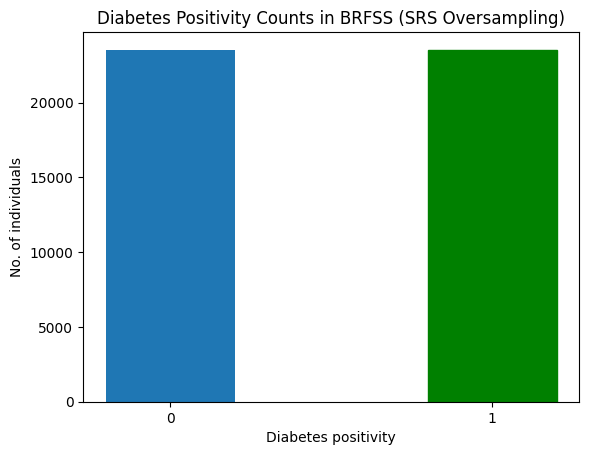

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [ ]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_385 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_390 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - AUC: 0.7370 - loss: 0.6012 - val_AUC: 0.8083 - val_loss: 0.5431
Epoch 2/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8016 - loss: 0.5431 - val_AUC: 0.8153 - val_loss: 0.5306
Epoch 3/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8101 - loss: 0.5291 - val_AUC: 0.8277 - val_loss: 0.5078
Epoch 4/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8222 - loss: 0.5126 - val_AUC: 0.8332 - val_loss: 0.4977
Epoch 5/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8375 - loss: 0.4931 - val_AUC: 0.8429 - val_loss: 0.5023
Epoch 6/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8458 - loss: 0.4837 - val_AUC: 0.8542 - val_loss: 0.4761
Epoch 7/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8545 - loss: 0.4729 - val_AUC: 0.8554 - val_loss: 0.4772
Epoch 8/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8640 - loss: 0.4584 - val_AUC: 0.8643 - val_loss: 0.4636
Epoch 9/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - 

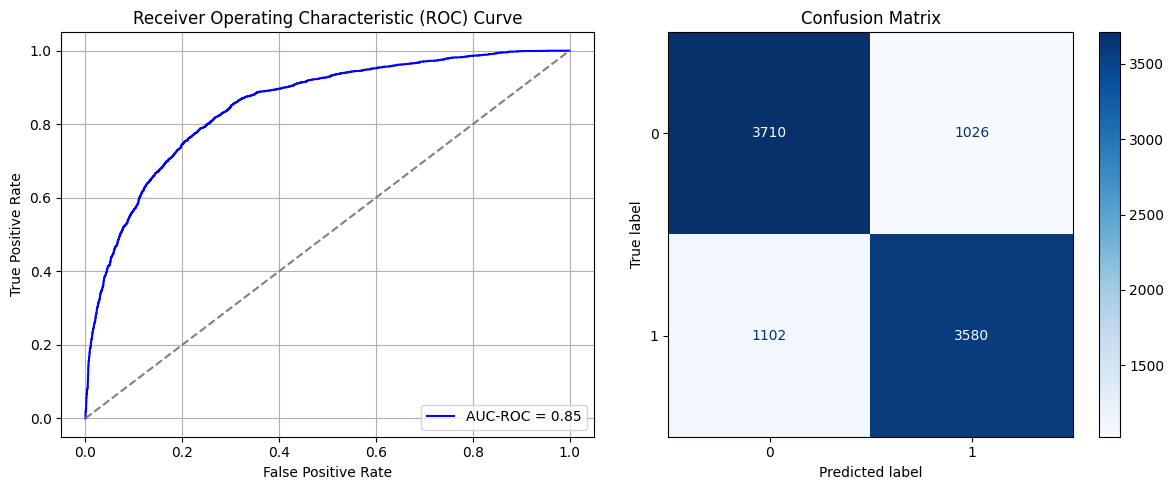

Best threshold based on F1-score: 0.41430994868278503
Time elapsed (performance): 58.44613739400029


<Sequential name=sequential_55, built=True>

In [ ]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.7556984759769114
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2792
           1       0.25      0.52      0.34       345

    accuracy                           0.78      3137
   macro avg       0.59      0.66      0.60      3137
weighted avg       0.86      0.78      0.81      3137

FPR 0.18875358166189113 TPR: 0.5159420289855072 FNR: 0.48405797101449277 TNR: 0.8112464183381088


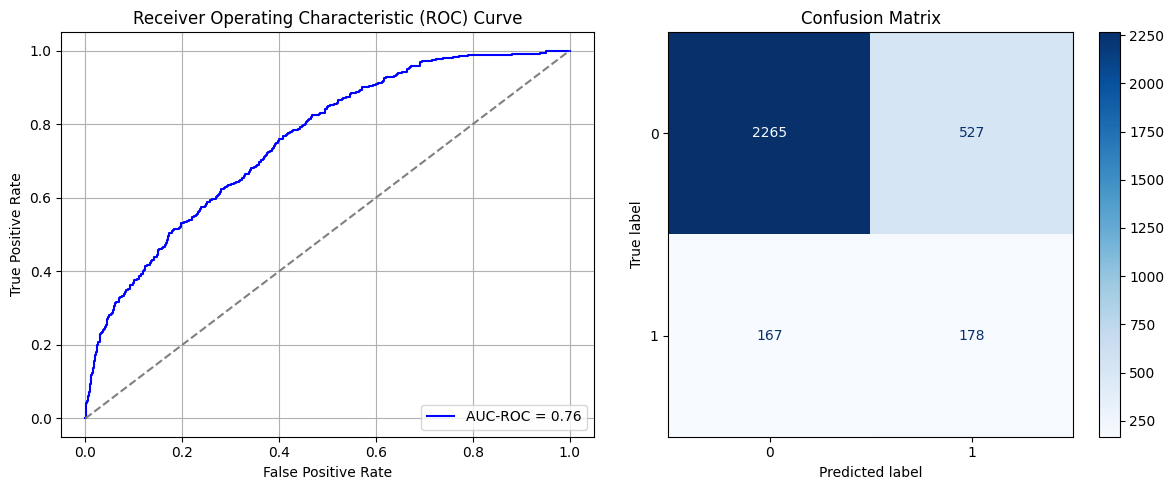

Best threshold based on F1-score: 0.9847748875617981
False Negative Rate: 0.48405797101449277
Time elapsed (performance): 0.7545564880001621


<ipython-input-33-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
Transductive_TL(model_source_SRS_ROS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_392 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.7353 - loss: 0.3218 - val_AUC: 0.7590 - val_loss: 0.3214
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7936 - loss: 0.2831 - val_AUC: 0.7770 - val_loss: 0.3125
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8144 - loss: 0.2686 - val_AUC: 0.7860 - val_loss: 0.3054
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8204 - loss: 0.2712 - val_AUC: 0.7922 - val_loss: 0.3021
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8260 - loss: 0.2671 - val_AUC: 0.7962 - val_loss: 0.2992
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8136 - loss: 0.2746 - val_AUC: 0.8019 - val_loss: 0.2980
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8278 - loss: 0.2718 - val_AUC: 0.8047 - val_loss: 0.2954
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8277 - loss: 0.2635 - val_AUC: 0.8085 - val_loss: 0.2925
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8420 -

(np.float64(0.01325214899713467), np.float64(0.8434782608695652))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_413 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - AUC: 0.7755 - loss: 0.5477 - val_AUC: 0.0000e+00 - val_loss: 0.7960
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8114 - loss: 0.5053 - val_AUC: 0.0000e+00 - val_loss: 0.7046
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8294 - loss: 0.4883 - val_AUC: 0.0000e+00 - val_loss: 0.6828
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8386 - loss: 0.4767 - val_AUC: 0.0000e+00 - val_loss: 0.7296
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8422 - loss: 0.4701 - val_AUC: 0.0000e+00 - val_loss: 0.7682
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8486 - loss: 0.4611 - val_AUC: 0.0000e+00 - val_loss: 0.6313
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8536 - loss: 0.4556 - val_AUC: 0.0000e+00 - val_loss: 0.6526
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7731 - loss: 0.5606 - val_AUC: 0.0000e+00 - val_loss: 0.7265
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8134 - loss: 0.5045 - val_AUC: 0.0000e+00 - val_loss: 0.7037
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8276 - loss: 0.4884 - val_AUC: 0.0000e+00 - val_loss: 0.7694
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8408 - loss: 0.4716 - val_AUC: 0.0000e+00 - val_loss: 0.6195
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8453 - loss: 0.4674 - val_AUC: 0.0000e+00 - val_loss: 0.7463
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8490 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.6698
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8491 - loss: 0.4630 - val_AUC: 0.0000e+00 - val_loss: 0.6297
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8580 - loss: 0.4503 - val_AUC: 0.0000e+00 - val_loss: 0.6712
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_427 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_432 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7718 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.7103
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8139 - loss: 0.5057 - val_AUC: 0.0000e+00 - val_loss: 0.6582
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8285 - loss: 0.4883 - val_AUC: 0.0000e+00 - val_loss: 0.5940
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8413 - loss: 0.4711 - val_AUC: 0.0000e+00 - val_loss: 0.6007
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8458 - loss: 0.4668 - val_AUC: 0.0000e+00 - val_loss: 0.6515
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8541 - loss: 0.4545 - val_AUC: 0.0000e+00 - val_loss: 0.6781
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8507 - loss: 0.4582 - val_AUC: 0.0000e+00 - val_loss: 0.5291
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8529 - loss: 0.4586 - val_AUC: 0.0000e+00 - val_loss: 0.5920
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_434 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_435 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7743 - loss: 0.5547 - val_AUC: 0.0000e+00 - val_loss: 0.6622
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8193 - loss: 0.5017 - val_AUC: 0.0000e+00 - val_loss: 0.6836
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8308 - loss: 0.4856 - val_AUC: 0.0000e+00 - val_loss: 0.5854
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8376 - loss: 0.4755 - val_AUC: 0.0000e+00 - val_loss: 0.7475
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8384 - loss: 0.4764 - val_AUC: 0.0000e+00 - val_loss: 0.6071
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8459 - loss: 0.4653 - val_AUC: 0.0000e+00 - val_loss: 0.5665
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8588 - loss: 0.4498 - val_AUC: 0.0000e+00 - val_loss: 0.5970
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8538 - loss: 0.4552 - val_AUC: 0.0000e+00 - val_loss: 0.6200
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_441 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_444 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7759 - loss: 0.5493 - val_AUC: 0.0000e+00 - val_loss: 0.6893
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8171 - loss: 0.5044 - val_AUC: 0.0000e+00 - val_loss: 0.7542
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8279 - loss: 0.4915 - val_AUC: 0.0000e+00 - val_loss: 0.7470
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8358 - loss: 0.4797 - val_AUC: 0.0000e+00 - val_loss: 0.6706
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8379 - loss: 0.4717 - val_AUC: 0.0000e+00 - val_loss: 0.5413
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8500 - loss: 0.4604 - val_AUC: 0.0000e+00 - val_loss: 0.6189
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8509 - loss: 0.4585 - val_AUC: 0.0000e+00 - val_loss: 0.5696
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8547 - loss: 0.4559 - val_AUC: 0.0000e+00 - val_loss: 0.6366
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_448 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7725 - loss: 0.5521 - val_AUC: 0.0000e+00 - val_loss: 0.6554
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8144 - loss: 0.5041 - val_AUC: 0.0000e+00 - val_loss: 0.7571
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8245 - loss: 0.4913 - val_AUC: 0.0000e+00 - val_loss: 0.6677
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8403 - loss: 0.4738 - val_AUC: 0.0000e+00 - val_loss: 0.6725
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8437 - loss: 0.4696 - val_AUC: 0.0000e+00 - val_loss: 0.5985
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8496 - loss: 0.4617 - val_AUC: 0.0000e+00 - val_loss: 0.7251
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8537 - loss: 0.4544 - val_AUC: 0.0000e+00 - val_loss: 0.6024
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8558 - loss: 0.4527 - val_AUC: 0.0000e+00 - val_loss: 0.6047
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_455 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7703 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.7772
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8143 - loss: 0.5077 - val_AUC: 0.0000e+00 - val_loss: 0.6735
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8264 - loss: 0.4917 - val_AUC: 0.0000e+00 - val_loss: 0.6901
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8363 - loss: 0.4772 - val_AUC: 0.0000e+00 - val_loss: 0.7083
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8475 - loss: 0.4643 - val_AUC: 0.0000e+00 - val_loss: 0.6659
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8477 - loss: 0.4652 - val_AUC: 0.0000e+00 - val_loss: 0.6866
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8482 - loss: 0.4626 - val_AUC: 0.0000e+00 - val_loss: 0.6196
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8564 - loss: 0.4511 - val_AUC: 0.0000e+00 - val_loss: 0.6397
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_462 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_468 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7750 - loss: 0.5468 - val_AUC: 0.0000e+00 - val_loss: 0.6362
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8127 - loss: 0.5080 - val_AUC: 0.0000e+00 - val_loss: 0.6160
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8333 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.6157
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8383 - loss: 0.4757 - val_AUC: 0.0000e+00 - val_loss: 0.6420
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8463 - loss: 0.4666 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8494 - loss: 0.4612 - val_AUC: 0.0000e+00 - val_loss: 0.6100
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8578 - loss: 0.4495 - val_AUC: 0.0000e+00 - val_loss: 0.6795
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8547 - loss: 0.4541 - val_AUC: 0.0000e+00 - val_loss: 0.5847
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_469 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_475 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7757 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.6720
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8149 - loss: 0.5024 - val_AUC: 0.0000e+00 - val_loss: 0.7049
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8251 - loss: 0.4877 - val_AUC: 0.0000e+00 - val_loss: 0.6448
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8380 - loss: 0.4756 - val_AUC: 0.0000e+00 - val_loss: 0.7012
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8452 - loss: 0.4688 - val_AUC: 0.0000e+00 - val_loss: 0.6320
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8495 - loss: 0.4594 - val_AUC: 0.0000e+00 - val_loss: 0.6110
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8529 - loss: 0.4567 - val_AUC: 0.0000e+00 - val_loss: 0.5078
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8570 - loss: 0.4523 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_476 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_480 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7734 - loss: 0.5562 - val_AUC: 0.0000e+00 - val_loss: 0.7522
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8162 - loss: 0.5014 - val_AUC: 0.0000e+00 - val_loss: 0.7010
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8265 - loss: 0.4887 - val_AUC: 0.0000e+00 - val_loss: 0.6743
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8414 - loss: 0.4737 - val_AUC: 0.0000e+00 - val_loss: 0.6273
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8444 - loss: 0.4678 - val_AUC: 0.0000e+00 - val_loss: 0.6494
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8482 - loss: 0.4648 - val_AUC: 0.0000e+00 - val_loss: 0.5992
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8544 - loss: 0.4564 - val_AUC: 0.0000e+00 - val_loss: 0.5439
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8530 - loss: 0.4556 - val_AUC: 0.0000e+00 - val_loss: 0.6306
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_483 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7711 - loss: 0.5591 - val_AUC: 0.0000e+00 - val_loss: 0.6796
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8135 - loss: 0.5051 - val_AUC: 0.0000e+00 - val_loss: 0.7156
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8302 - loss: 0.4846 - val_AUC: 0.0000e+00 - val_loss: 0.6110
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8356 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.6291
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8417 - loss: 0.4689 - val_AUC: 0.0000e+00 - val_loss: 0.6595
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8536 - loss: 0.4586 - val_AUC: 0.0000e+00 - val_loss: 0.6415
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8472 - loss: 0.4621 - val_AUC: 0.0000e+00 - val_loss: 0.5819
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8548 - loss: 0.4523 - val_AUC: 0.0000e+00 - val_loss: 0.5908
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_490 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7736 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.7252
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8097 - loss: 0.5091 - val_AUC: 0.0000e+00 - val_loss: 0.6559
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8256 - loss: 0.4911 - val_AUC: 0.0000e+00 - val_loss: 0.6153
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8412 - loss: 0.4736 - val_AUC: 0.0000e+00 - val_loss: 0.6286
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8456 - loss: 0.4655 - val_AUC: 0.0000e+00 - val_loss: 0.6648
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8484 - loss: 0.4652 - val_AUC: 0.0000e+00 - val_loss: 0.6778
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8530 - loss: 0.4580 - val_AUC: 0.0000e+00 - val_loss: 0.6981
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8525 - loss: 0.4572 - val_AUC: 0.0000e+00 - val_loss: 0.5712
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_497 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7714 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.7793
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8133 - loss: 0.5049 - val_AUC: 0.0000e+00 - val_loss: 0.6577
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8300 - loss: 0.4864 - val_AUC: 0.0000e+00 - val_loss: 0.6360
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8394 - loss: 0.4760 - val_AUC: 0.0000e+00 - val_loss: 0.7219
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8443 - loss: 0.4683 - val_AUC: 0.0000e+00 - val_loss: 0.6715
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8448 - loss: 0.4696 - val_AUC: 0.0000e+00 - val_loss: 0.6411
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8537 - loss: 0.4568 - val_AUC: 0.0000e+00 - val_loss: 0.5887
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8547 - loss: 0.4533 - val_AUC: 0.0000e+00 - val_loss: 0.5651
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_504 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - AUC: 0.7766 - loss: 0.5503 - val_AUC: 0.0000e+00 - val_loss: 0.7165
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8152 - loss: 0.5036 - val_AUC: 0.0000e+00 - val_loss: 0.7101
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8209 - loss: 0.4964 - val_AUC: 0.0000e+00 - val_loss: 0.6299
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8393 - loss: 0.4751 - val_AUC: 0.0000e+00 - val_loss: 0.7207
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8424 - loss: 0.4717 - val_AUC: 0.0000e+00 - val_loss: 0.6305
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8461 - loss: 0.4660 - val_AUC: 0.0000e+00 - val_loss: 0.6890
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8527 - loss: 0.4559 - val_AUC: 0.0000e+00 - val_loss: 0.5677
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8557 - loss: 0.4539 - val_AUC: 0.0000e+00 - val_loss: 0.5886
Epoch 9/10
558/558 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_511 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_514 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_515 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_516 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7699 - loss: 0.5560 - val_AUC: 0.0000e+00 - val_loss: 0.6172
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8108 - loss: 0.5090 - val_AUC: 0.0000e+00 - val_loss: 0.7054
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8292 - loss: 0.4862 - val_AUC: 0.0000e+00 - val_loss: 0.6983
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8412 - loss: 0.4732 - val_AUC: 0.0000e+00 - val_loss: 0.6092
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8458 - loss: 0.4651 - val_AUC: 0.0000e+00 - val_loss: 0.6411
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8519 - loss: 0.4604 - val_AUC: 0.0000e+00 - val_loss: 0.6639
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8537 - loss: 0.4544 - val_AUC: 0.0000e+00 - val_loss: 0.5975
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8571 - loss: 0.4503 - val_AUC: 0.0000e+00 - val_loss: 0.5577
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_518 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_520 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_521 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_522 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_523 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_524 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7758 - loss: 0.5474 - val_AUC: 0.0000e+00 - val_loss: 0.7635
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8162 - loss: 0.5027 - val_AUC: 0.0000e+00 - val_loss: 0.7016
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8267 - loss: 0.4895 - val_AUC: 0.0000e+00 - val_loss: 0.6815
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8383 - loss: 0.4749 - val_AUC: 0.0000e+00 - val_loss: 0.7179
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8403 - loss: 0.4740 - val_AUC: 0.0000e+00 - val_loss: 0.6809
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8485 - loss: 0.4622 - val_AUC: 0.0000e+00 - val_loss: 0.6371
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8568 - loss: 0.4509 - val_AUC: 0.0000e+00 - val_loss: 0.6371
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8539 - loss: 0.4549 - val_AUC: 0.0000e+00 - val_loss: 0.7590
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_525 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7728 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.6491
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8154 - loss: 0.5014 - val_AUC: 0.0000e+00 - val_loss: 0.6205
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8319 - loss: 0.4848 - val_AUC: 0.0000e+00 - val_loss: 0.6778
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8362 - loss: 0.4779 - val_AUC: 0.0000e+00 - val_loss: 0.5033
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8442 - loss: 0.4679 - val_AUC: 0.0000e+00 - val_loss: 0.6809
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8531 - loss: 0.4549 - val_AUC: 0.0000e+00 - val_loss: 0.5960
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8534 - loss: 0.4554 - val_AUC: 0.0000e+00 - val_loss: 0.6000
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8600 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.6322
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_532 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7787 - loss: 0.5478 - val_AUC: 0.0000e+00 - val_loss: 0.7791
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8112 - loss: 0.5070 - val_AUC: 0.0000e+00 - val_loss: 0.6853
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8299 - loss: 0.4879 - val_AUC: 0.0000e+00 - val_loss: 0.6182
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8382 - loss: 0.4761 - val_AUC: 0.0000e+00 - val_loss: 0.6821
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8402 - loss: 0.4738 - val_AUC: 0.0000e+00 - val_loss: 0.7109
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8483 - loss: 0.4631 - val_AUC: 0.0000e+00 - val_loss: 0.5439
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8528 - loss: 0.4581 - val_AUC: 0.0000e+00 - val_loss: 0.5898
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8549 - loss: 0.4526 - val_AUC: 0.0000e+00 - val_loss: 0.6328
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_539 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_540 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_544 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_545 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7701 - loss: 0.5615 - val_AUC: 0.0000e+00 - val_loss: 0.6636
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8200 - loss: 0.4991 - val_AUC: 0.0000e+00 - val_loss: 0.6597
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8303 - loss: 0.4867 - val_AUC: 0.0000e+00 - val_loss: 0.6778
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8345 - loss: 0.4801 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8406 - loss: 0.4723 - val_AUC: 0.0000e+00 - val_loss: 0.6255
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8440 - loss: 0.4680 - val_AUC: 0.0000e+00 - val_loss: 0.6852
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8525 - loss: 0.4579 - val_AUC: 0.0000e+00 - val_loss: 0.6097
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8551 - loss: 0.4512 - val_AUC: 0.0000e+00 - val_loss: 0.7001
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_546 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_548 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_550 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_552 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7718 - loss: 0.5553 - val_AUC: 0.0000e+00 - val_loss: 0.7006
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8128 - loss: 0.5061 - val_AUC: 0.0000e+00 - val_loss: 0.6308
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8324 - loss: 0.4824 - val_AUC: 0.0000e+00 - val_loss: 0.6606
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8386 - loss: 0.4763 - val_AUC: 0.0000e+00 - val_loss: 0.6822
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8455 - loss: 0.4674 - val_AUC: 0.0000e+00 - val_loss: 0.6315
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8522 - loss: 0.4582 - val_AUC: 0.0000e+00 - val_loss: 0.6201
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8518 - loss: 0.4560 - val_AUC: 0.0000e+00 - val_loss: 0.6110
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8541 - loss: 0.4531 - val_AUC: 0.0000e+00 - val_loss: 0.5838
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_553 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7711 - loss: 0.5575 - val_AUC: 0.0000e+00 - val_loss: 0.7763
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8153 - loss: 0.5042 - val_AUC: 0.0000e+00 - val_loss: 0.6547
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8214 - loss: 0.4950 - val_AUC: 0.0000e+00 - val_loss: 0.7458
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8346 - loss: 0.4808 - val_AUC: 0.0000e+00 - val_loss: 0.7078
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8416 - loss: 0.4706 - val_AUC: 0.0000e+00 - val_loss: 0.6330
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8501 - loss: 0.4588 - val_AUC: 0.0000e+00 - val_loss: 0.6186
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8522 - loss: 0.4581 - val_AUC: 0.0000e+00 - val_loss: 0.6921
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8535 - loss: 0.4568 - val_AUC: 0.0000e+00 - val_loss: 0.5692
Epoch 9/10
558/558 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_565 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.7688 - loss: 0.5624 - val_AUC: 0.0000e+00 - val_loss: 0.6997
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8170 - loss: 0.5020 - val_AUC: 0.0000e+00 - val_loss: 0.7836
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8276 - loss: 0.4884 - val_AUC: 0.0000e+00 - val_loss: 0.6333
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8386 - loss: 0.4747 - val_AUC: 0.0000e+00 - val_loss: 0.6537
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8471 - loss: 0.4631 - val_AUC: 0.0000e+00 - val_loss: 0.6231
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8457 - loss: 0.4649 - val_AUC: 0.0000e+00 - val_loss: 0.6837
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8545 - loss: 0.4567 - val_AUC: 0.0000e+00 - val_loss: 0.5874
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8529 - loss: 0.4544 - val_AUC: 0.0000e+00 - val_loss: 0.6323
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_567 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_568 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_570 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7820 - loss: 0.5415 - val_AUC: 0.0000e+00 - val_loss: 0.6810
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8184 - loss: 0.5010 - val_AUC: 0.0000e+00 - val_loss: 0.6999
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8329 - loss: 0.4822 - val_AUC: 0.0000e+00 - val_loss: 0.6757
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8358 - loss: 0.4788 - val_AUC: 0.0000e+00 - val_loss: 0.5829
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8405 - loss: 0.4726 - val_AUC: 0.0000e+00 - val_loss: 0.7220
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8456 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.5666
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8533 - loss: 0.4544 - val_AUC: 0.0000e+00 - val_loss: 0.5369
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8507 - loss: 0.4607 - val_AUC: 0.0000e+00 - val_loss: 0.6245
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_574 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_575 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_580 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7684 - loss: 0.5565 - val_AUC: 0.0000e+00 - val_loss: 0.7177
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8084 - loss: 0.5090 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8284 - loss: 0.4846 - val_AUC: 0.0000e+00 - val_loss: 0.6480
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8371 - loss: 0.4772 - val_AUC: 0.0000e+00 - val_loss: 0.5851
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8467 - loss: 0.4653 - val_AUC: 0.0000e+00 - val_loss: 0.7161
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8518 - loss: 0.4579 - val_AUC: 0.0000e+00 - val_loss: 0.6179
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8545 - loss: 0.4556 - val_AUC: 0.0000e+00 - val_loss: 0.5959
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8499 - loss: 0.4610 - val_AUC: 0.0000e+00 - val_loss: 0.6387
Epoch 9/10
558/558 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_581 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_584 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_585 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7788 - loss: 0.5424 - val_AUC: 0.0000e+00 - val_loss: 0.6395
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8149 - loss: 0.5019 - val_AUC: 0.0000e+00 - val_loss: 0.7036
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8296 - loss: 0.4860 - val_AUC: 0.0000e+00 - val_loss: 0.6954
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8376 - loss: 0.4775 - val_AUC: 0.0000e+00 - val_loss: 0.6863
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8434 - loss: 0.4716 - val_AUC: 0.0000e+00 - val_loss: 0.6335
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8521 - loss: 0.4579 - val_AUC: 0.0000e+00 - val_loss: 0.5577
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8500 - loss: 0.4592 - val_AUC: 0.0000e+00 - val_loss: 0.6352
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8577 - loss: 0.4511 - val_AUC: 0.0000e+00 - val_loss: 0.5821
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_588 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_590 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_592 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7629 - loss: 0.5636 - val_AUC: 0.0000e+00 - val_loss: 0.6487
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8135 - loss: 0.5074 - val_AUC: 0.0000e+00 - val_loss: 0.6478
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8361 - loss: 0.4809 - val_AUC: 0.0000e+00 - val_loss: 0.6280
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8361 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.6537
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8493 - loss: 0.4605 - val_AUC: 0.0000e+00 - val_loss: 0.6612
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8503 - loss: 0.4597 - val_AUC: 0.0000e+00 - val_loss: 0.7089
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8540 - loss: 0.4575 - val_AUC: 0.0000e+00 - val_loss: 0.6023
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8579 - loss: 0.4512 - val_AUC: 0.0000e+00 - val_loss: 0.6106
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_595 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_600 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_601 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.7750 - loss: 0.5494 - val_AUC: 0.0000e+00 - val_loss: 0.6741
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8075 - loss: 0.5130 - val_AUC: 0.0000e+00 - val_loss: 0.7810
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8265 - loss: 0.4921 - val_AUC: 0.0000e+00 - val_loss: 0.7210
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8379 - loss: 0.4762 - val_AUC: 0.0000e+00 - val_loss: 0.6427
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8496 - loss: 0.4607 - val_AUC: 0.0000e+00 - val_loss: 0.6218
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8494 - loss: 0.4624 - val_AUC: 0.0000e+00 - val_loss: 0.6641
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8544 - loss: 0.4558 - val_AUC: 0.0000e+00 - val_loss: 0.6384
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8570 - loss: 0.4525 - val_AUC: 0.0000e+00 - val_loss: 0.5989
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_602 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_603 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_604 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_605 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_606 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_607 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_608 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7824 - loss: 0.5493 - val_AUC: 0.0000e+00 - val_loss: 0.7983
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8139 - loss: 0.5074 - val_AUC: 0.0000e+00 - val_loss: 0.7176
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8282 - loss: 0.4883 - val_AUC: 0.0000e+00 - val_loss: 0.7207
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8384 - loss: 0.4747 - val_AUC: 0.0000e+00 - val_loss: 0.6246
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8474 - loss: 0.4659 - val_AUC: 0.0000e+00 - val_loss: 0.6825
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8461 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.6843
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8518 - loss: 0.4593 - val_AUC: 0.0000e+00 - val_loss: 0.6670
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8491 - loss: 0.4600 - val_AUC: 0.0000e+00 - val_loss: 0.6556
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_609 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_610 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_611 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_612 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_613 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_614 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_615 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7681 - loss: 0.5637 - val_AUC: 0.0000e+00 - val_loss: 0.6846
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8193 - loss: 0.4966 - val_AUC: 0.0000e+00 - val_loss: 0.7066
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8321 - loss: 0.4850 - val_AUC: 0.0000e+00 - val_loss: 0.6159
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8405 - loss: 0.4750 - val_AUC: 0.0000e+00 - val_loss: 0.7287
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8413 - loss: 0.4710 - val_AUC: 0.0000e+00 - val_loss: 0.6532
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8475 - loss: 0.4638 - val_AUC: 0.0000e+00 - val_loss: 0.5786
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8518 - loss: 0.4560 - val_AUC: 0.0000e+00 - val_loss: 0.6293
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8522 - loss: 0.4562 - val_AUC: 0.0000e+00 - val_loss: 0.6054
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_616 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_617 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_618 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_619 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_620 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_621 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_622 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.7782 - loss: 0.5459 - val_AUC: 0.0000e+00 - val_loss: 0.7602
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8138 - loss: 0.5017 - val_AUC: 0.0000e+00 - val_loss: 0.7265
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8268 - loss: 0.4912 - val_AUC: 0.0000e+00 - val_loss: 0.7985
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8370 - loss: 0.4760 - val_AUC: 0.0000e+00 - val_loss: 0.5798
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8483 - loss: 0.4654 - val_AUC: 0.0000e+00 - val_loss: 0.5935
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8477 - loss: 0.4648 - val_AUC: 0.0000e+00 - val_loss: 0.6232
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8582 - loss: 0.4499 - val_AUC: 0.0000e+00 - val_loss: 0.6235
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8599 - loss: 0.4478 - val_AUC: 0.0000e+00 - val_loss: 0.7400
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_623 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_624 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_626 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_627 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_628 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_629 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7752 - loss: 0.5509 - val_AUC: 0.0000e+00 - val_loss: 0.6490
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8101 - loss: 0.5086 - val_AUC: 0.0000e+00 - val_loss: 0.7224
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8270 - loss: 0.4896 - val_AUC: 0.0000e+00 - val_loss: 0.6560
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8392 - loss: 0.4777 - val_AUC: 0.0000e+00 - val_loss: 0.7094
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8441 - loss: 0.4674 - val_AUC: 0.0000e+00 - val_loss: 0.7201
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8498 - loss: 0.4610 - val_AUC: 0.0000e+00 - val_loss: 0.5654
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8492 - loss: 0.4608 - val_AUC: 0.0000e+00 - val_loss: 0.5913
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8549 - loss: 0.4535 - val_AUC: 0.0000e+00 - val_loss: 0.6528
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_630 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_631 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_632 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_633 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_636 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7691 - loss: 0.5594 - val_AUC: 0.0000e+00 - val_loss: 0.6822
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8184 - loss: 0.5014 - val_AUC: 0.0000e+00 - val_loss: 0.6032
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8328 - loss: 0.4824 - val_AUC: 0.0000e+00 - val_loss: 0.6968
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8438 - loss: 0.4702 - val_AUC: 0.0000e+00 - val_loss: 0.7087
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8466 - loss: 0.4671 - val_AUC: 0.0000e+00 - val_loss: 0.7494
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8483 - loss: 0.4607 - val_AUC: 0.0000e+00 - val_loss: 0.5984
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8525 - loss: 0.4576 - val_AUC: 0.0000e+00 - val_loss: 0.5511
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8538 - loss: 0.4540 - val_AUC: 0.0000e+00 - val_loss: 0.5749
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_637 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_640 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7704 - loss: 0.5601 - val_AUC: 0.0000e+00 - val_loss: 0.5804
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8165 - loss: 0.5039 - val_AUC: 0.0000e+00 - val_loss: 0.6464
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8312 - loss: 0.4846 - val_AUC: 0.0000e+00 - val_loss: 0.6821
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8364 - loss: 0.4801 - val_AUC: 0.0000e+00 - val_loss: 0.7323
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8487 - loss: 0.4623 - val_AUC: 0.0000e+00 - val_loss: 0.8241
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8486 - loss: 0.4631 - val_AUC: 0.0000e+00 - val_loss: 0.5557
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8517 - loss: 0.4601 - val_AUC: 0.0000e+00 - val_loss: 0.6616
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8570 - loss: 0.4535 - val_AUC: 0.0000e+00 - val_loss: 0.6961
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_644 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_648 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7808 - loss: 0.5465 - val_AUC: 0.0000e+00 - val_loss: 0.7225
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8143 - loss: 0.5034 - val_AUC: 0.0000e+00 - val_loss: 0.6727
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8317 - loss: 0.4857 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8378 - loss: 0.4733 - val_AUC: 0.0000e+00 - val_loss: 0.6639
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8497 - loss: 0.4624 - val_AUC: 0.0000e+00 - val_loss: 0.6272
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8476 - loss: 0.4636 - val_AUC: 0.0000e+00 - val_loss: 0.6673
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8497 - loss: 0.4605 - val_AUC: 0.0000e+00 - val_loss: 0.6499
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8568 - loss: 0.4509 - val_AUC: 0.0000e+00 - val_loss: 0.5935
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_651 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_656 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7776 - loss: 0.5480 - val_AUC: 0.0000e+00 - val_loss: 0.7387
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8137 - loss: 0.5050 - val_AUC: 0.0000e+00 - val_loss: 0.7441
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8310 - loss: 0.4844 - val_AUC: 0.0000e+00 - val_loss: 0.6503
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8343 - loss: 0.4809 - val_AUC: 0.0000e+00 - val_loss: 0.6114
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8392 - loss: 0.4748 - val_AUC: 0.0000e+00 - val_loss: 0.7364
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8476 - loss: 0.4635 - val_AUC: 0.0000e+00 - val_loss: 0.6143
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8514 - loss: 0.4587 - val_AUC: 0.0000e+00 - val_loss: 0.6071
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8578 - loss: 0.4497 - val_AUC: 0.0000e+00 - val_loss: 0.6918
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_658 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_659 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_660 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_664 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7717 - loss: 0.5566 - val_AUC: 0.0000e+00 - val_loss: 0.6172
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8140 - loss: 0.5051 - val_AUC: 0.0000e+00 - val_loss: 0.6608
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8281 - loss: 0.4876 - val_AUC: 0.0000e+00 - val_loss: 0.7409
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8415 - loss: 0.4719 - val_AUC: 0.0000e+00 - val_loss: 0.6596
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8491 - loss: 0.4635 - val_AUC: 0.0000e+00 - val_loss: 0.7714
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8448 - loss: 0.4670 - val_AUC: 0.0000e+00 - val_loss: 0.5831
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8536 - loss: 0.4577 - val_AUC: 0.0000e+00 - val_loss: 0.7079
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8590 - loss: 0.4500 - val_AUC: 0.0000e+00 - val_loss: 0.5355
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_665 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_668 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_669 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - AUC: 0.7727 - loss: 0.5527 - val_AUC: 0.0000e+00 - val_loss: 0.6604
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8128 - loss: 0.5063 - val_AUC: 0.0000e+00 - val_loss: 0.7500
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8290 - loss: 0.4905 - val_AUC: 0.0000e+00 - val_loss: 0.6402
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8396 - loss: 0.4749 - val_AUC: 0.0000e+00 - val_loss: 0.6016
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8462 - loss: 0.4653 - val_AUC: 0.0000e+00 - val_loss: 0.6795
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8478 - loss: 0.4642 - val_AUC: 0.0000e+00 - val_loss: 0.5394
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8493 - loss: 0.4636 - val_AUC: 0.0000e+00 - val_loss: 0.6208
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8531 - loss: 0.4561 - val_AUC: 0.0000e+00 - val_loss: 0.5952
Epoch 9/10
558/558 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_673 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_674 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_675 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_676 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_677 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_678 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - AUC: 0.7739 - loss: 0.5516 - val_AUC: 0.0000e+00 - val_loss: 0.7425
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8173 - loss: 0.5008 - val_AUC: 0.0000e+00 - val_loss: 0.6453
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8310 - loss: 0.4848 - val_AUC: 0.0000e+00 - val_loss: 0.6692
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8343 - loss: 0.4787 - val_AUC: 0.0000e+00 - val_loss: 0.6950
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8376 - loss: 0.4781 - val_AUC: 0.0000e+00 - val_loss: 0.5932
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8477 - loss: 0.4641 - val_AUC: 0.0000e+00 - val_loss: 0.7181
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8502 - loss: 0.4615 - val_AUC: 0.0000e+00 - val_loss: 0.5631
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8557 - loss: 0.4504 - val_AUC: 0.0000e+00 - val_loss: 0.5784
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_679 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_680 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_681 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_682 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7802 - loss: 0.5475 - val_AUC: 0.0000e+00 - val_loss: 0.7319
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8178 - loss: 0.5003 - val_AUC: 0.0000e+00 - val_loss: 0.6753
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8300 - loss: 0.4871 - val_AUC: 0.0000e+00 - val_loss: 0.6740
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8362 - loss: 0.4780 - val_AUC: 0.0000e+00 - val_loss: 0.6483
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8407 - loss: 0.4726 - val_AUC: 0.0000e+00 - val_loss: 0.6697
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8431 - loss: 0.4699 - val_AUC: 0.0000e+00 - val_loss: 0.6936
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8547 - loss: 0.4555 - val_AUC: 0.0000e+00 - val_loss: 0.5933
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8504 - loss: 0.4609 - val_AUC: 0.0000e+00 - val_loss: 0.5124
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_686 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_687 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_688 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_689 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_690 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_691 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_692 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7734 - loss: 0.5534 - val_AUC: 0.0000e+00 - val_loss: 0.7312
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8106 - loss: 0.5086 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8251 - loss: 0.4920 - val_AUC: 0.0000e+00 - val_loss: 0.6206
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8313 - loss: 0.4817 - val_AUC: 0.0000e+00 - val_loss: 0.5565
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8406 - loss: 0.4727 - val_AUC: 0.0000e+00 - val_loss: 0.6694
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8455 - loss: 0.4667 - val_AUC: 0.0000e+00 - val_loss: 0.6619
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8538 - loss: 0.4549 - val_AUC: 0.0000e+00 - val_loss: 0.5420
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8577 - loss: 0.4507 - val_AUC: 0.0000e+00 - val_loss: 0.5521
Epoch 9/10
558/558 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_693 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_694 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_695 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_696 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_697 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - AUC: 0.7727 - loss: 0.5607 - val_AUC: 0.0000e+00 - val_loss: 0.6191
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8160 - loss: 0.5027 - val_AUC: 0.0000e+00 - val_loss: 0.6843
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8271 - loss: 0.4914 - val_AUC: 0.0000e+00 - val_loss: 0.7348
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8339 - loss: 0.4824 - val_AUC: 0.0000e+00 - val_loss: 0.5492
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8460 - loss: 0.4664 - val_AUC: 0.0000e+00 - val_loss: 0.6433
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8487 - loss: 0.4643 - val_AUC: 0.0000e+00 - val_loss: 0.6976
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8514 - loss: 0.4590 - val_AUC: 0.0000e+00 - val_loss: 0.6281
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8540 - loss: 0.4551 - val_AUC: 0.0000e+00 - val_loss: 0.5904
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_700 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_701 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_702 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_703 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_704 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_705 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_706 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.7708 - loss: 0.5567 - val_AUC: 0.0000e+00 - val_loss: 0.7113
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8136 - loss: 0.5031 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8250 - loss: 0.4907 - val_AUC: 0.0000e+00 - val_loss: 0.6709
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8409 - loss: 0.4719 - val_AUC: 0.0000e+00 - val_loss: 0.6627
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8455 - loss: 0.4664 - val_AUC: 0.0000e+00 - val_loss: 0.5897
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8445 - loss: 0.4661 - val_AUC: 0.0000e+00 - val_loss: 0.7048
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8474 - loss: 0.4641 - val_AUC: 0.0000e+00 - val_loss: 0.7033
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8571 - loss: 0.4503 - val_AUC: 0.0000e+00 - val_loss: 0.5729
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_707 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_708 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_709 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_710 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_711 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_712 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_713 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7750 - loss: 0.5579 - val_AUC: 0.0000e+00 - val_loss: 0.7361
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8208 - loss: 0.4990 - val_AUC: 0.0000e+00 - val_loss: 0.6748
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8326 - loss: 0.4858 - val_AUC: 0.0000e+00 - val_loss: 0.7034
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8439 - loss: 0.4689 - val_AUC: 0.0000e+00 - val_loss: 0.7656
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8397 - loss: 0.4733 - val_AUC: 0.0000e+00 - val_loss: 0.5166
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8492 - loss: 0.4606 - val_AUC: 0.0000e+00 - val_loss: 0.6393
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8505 - loss: 0.4579 - val_AUC: 0.0000e+00 - val_loss: 0.6420
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8537 - loss: 0.4523 - val_AUC: 0.0000e+00 - val_loss: 0.6143
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_714 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_715 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_716 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_717 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_718 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_720 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7758 - loss: 0.5490 - val_AUC: 0.0000e+00 - val_loss: 0.7144
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8152 - loss: 0.5067 - val_AUC: 0.0000e+00 - val_loss: 0.6022
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8246 - loss: 0.4922 - val_AUC: 0.0000e+00 - val_loss: 0.6338
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8385 - loss: 0.4757 - val_AUC: 0.0000e+00 - val_loss: 0.7399
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8448 - loss: 0.4685 - val_AUC: 0.0000e+00 - val_loss: 0.5723
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8483 - loss: 0.4642 - val_AUC: 0.0000e+00 - val_loss: 0.7189
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8547 - loss: 0.4538 - val_AUC: 0.0000e+00 - val_loss: 0.5251
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8503 - loss: 0.4610 - val_AUC: 0.0000e+00 - val_loss: 0.6604
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_721 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_724 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_725 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.7732 - loss: 0.5542 - val_AUC: 0.0000e+00 - val_loss: 0.7499
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8168 - loss: 0.5028 - val_AUC: 0.0000e+00 - val_loss: 0.6664
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8246 - loss: 0.4928 - val_AUC: 0.0000e+00 - val_loss: 0.6580
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8410 - loss: 0.4719 - val_AUC: 0.0000e+00 - val_loss: 0.6673
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8402 - loss: 0.4754 - val_AUC: 0.0000e+00 - val_loss: 0.6381
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8469 - loss: 0.4635 - val_AUC: 0.0000e+00 - val_loss: 0.6389
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8561 - loss: 0.4537 - val_AUC: 0.0000e+00 - val_loss: 0.6500
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8541 - loss: 0.4538 - val_AUC: 0.0000e+00 - val_loss: 0.5974
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_728 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_729 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_730 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_731 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_732 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7716 - loss: 0.5551 - val_AUC: 0.0000e+00 - val_loss: 0.6844
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8112 - loss: 0.5102 - val_AUC: 0.0000e+00 - val_loss: 0.6889
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8324 - loss: 0.4853 - val_AUC: 0.0000e+00 - val_loss: 0.6023
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8376 - loss: 0.4788 - val_AUC: 0.0000e+00 - val_loss: 0.7453
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8462 - loss: 0.4654 - val_AUC: 0.0000e+00 - val_loss: 0.6501
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8514 - loss: 0.4591 - val_AUC: 0.0000e+00 - val_loss: 0.6481
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8504 - loss: 0.4613 - val_AUC: 0.0000e+00 - val_loss: 0.6806
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8515 - loss: 0.4595 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_735 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_738 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_739 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_740 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7772 - loss: 0.5467 - val_AUC: 0.0000e+00 - val_loss: 0.6350
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8132 - loss: 0.5038 - val_AUC: 0.0000e+00 - val_loss: 0.6428
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8326 - loss: 0.4852 - val_AUC: 0.0000e+00 - val_loss: 0.6545
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8410 - loss: 0.4724 - val_AUC: 0.0000e+00 - val_loss: 0.6816
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8467 - loss: 0.4660 - val_AUC: 0.0000e+00 - val_loss: 0.6651
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8474 - loss: 0.4665 - val_AUC: 0.0000e+00 - val_loss: 0.6623
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8534 - loss: 0.4587 - val_AUC: 0.0000e+00 - val_loss: 0.7944
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8541 - loss: 0.4561 - val_AUC: 0.0000e+00 - val_loss: 0.6167
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_742 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_744 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_745 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_746 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_747 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_748 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - AUC: 0.7709 - loss: 0.5572 - val_AUC: 0.0000e+00 - val_loss: 0.6267
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8166 - loss: 0.5022 - val_AUC: 0.0000e+00 - val_loss: 0.7823
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8277 - loss: 0.4905 - val_AUC: 0.0000e+00 - val_loss: 0.6849
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8370 - loss: 0.4761 - val_AUC: 0.0000e+00 - val_loss: 0.5765
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8431 - loss: 0.4709 - val_AUC: 0.0000e+00 - val_loss: 0.6287
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8544 - loss: 0.4549 - val_AUC: 0.0000e+00 - val_loss: 0.5877
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8490 - loss: 0.4624 - val_AUC: 0.0000e+00 - val_loss: 0.5790
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8600 - loss: 0.4476 - val_AUC: 0.0000e+00 - val_loss: 0.5751
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_749 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_752 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_753 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_754 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_755 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.7733 - loss: 0.5600 - val_AUC: 0.0000e+00 - val_loss: 0.6770
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8196 - loss: 0.4993 - val_AUC: 0.0000e+00 - val_loss: 0.8052
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8317 - loss: 0.4854 - val_AUC: 0.0000e+00 - val_loss: 0.7417
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8396 - loss: 0.4738 - val_AUC: 0.0000e+00 - val_loss: 0.6664
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8460 - loss: 0.4635 - val_AUC: 0.0000e+00 - val_loss: 0.6825
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8523 - loss: 0.4568 - val_AUC: 0.0000e+00 - val_loss: 0.6221
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8537 - loss: 0.4551 - val_AUC: 0.0000e+00 - val_loss: 0.6207
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8556 - loss: 0.4514 - val_AUC: 0.0000e+00 - val_loss: 0.5761
Epoch 9/10
558/558 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_760 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - AUC: 0.7701 - loss: 0.5597 - val_AUC: 0.0000e+00 - val_loss: 0.7153
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8130 - loss: 0.5054 - val_AUC: 0.0000e+00 - val_loss: 0.6344
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8330 - loss: 0.4806 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8403 - loss: 0.4746 - val_AUC: 0.0000e+00 - val_loss: 0.6156
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8374 - loss: 0.4759 - val_AUC: 0.0000e+00 - val_loss: 0.6368
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8528 - loss: 0.4571 - val_AUC: 0.0000e+00 - val_loss: 0.6343
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8467 - loss: 0.4630 - val_AUC: 0.0000e+00 - val_loss: 0.6120
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8601 - loss: 0.4458 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 9/10
558/558 ━━━━━━━━━━━━━━━

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS_Fine_Tuning.csv')

         FPR       FNR
0   0.109599  0.362319
1   0.158309  0.284058
2   0.170129  0.260870
3   0.144341  0.275362
4   0.136819  0.286957
5   0.157593  0.272464
6   0.122493  0.321739
7   0.124642  0.313043
8   0.128940  0.315942
9   0.149355  0.304348
10  0.155444  0.272464
11  0.131089  0.307246
12  0.131805  0.313043
13  0.174069  0.252174
14  0.127865  0.330435
15  0.125358  0.350725
16  0.147564  0.284058
17  0.159742  0.275362
18  0.131447  0.324638
19  0.143625  0.292754
20  0.130372  0.310145
21  0.162249  0.263768
22  0.134312  0.304348
23  0.178009  0.246377
24  0.136819  0.295652
25  0.144699  0.304348
26  0.122493  0.342029
27  0.154370  0.286957
28  0.159026  0.284058
29  0.188037  0.243478
30  0.129656  0.327536
31  0.139327  0.298551
32  0.162607  0.272464
33  0.140401  0.301449
34  0.082378  0.417391
35  0.161175  0.278261
36  0.114613  0.336232
37  0.098854  0.391304
38  0.127865  0.321739
39  0.166547  0.260870
40  0.147206  0.298551
41  0.130372  0.324638
42  0.11318

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, we take $k=10$ for the source data sampling, and take $k=20$ for the target training data resampling.

In [ ]:
X_S_Sy, y_S_Sy = systematic_resampler(data_S_full, data_S_full.iloc[:, -1], 10)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_resampler(T_train, T_train.iloc[:, -1], 20)
print(y_T_train_Sy)

8393
23544
Nsamples= 18.051948051948052
2        0
3        0
4        0
6        0
8        0
        ..
31780    1
31808    1
31832    1
31866    1
31897    1
Name: Y2, Length: 47039, dtype: int64
1391
11156
Nsamples= 140.40258806613946
14490    0
4908     0
11461    0
2455     0
13540    0
        ..
7282     1
2671     1
7034     1
12267    1
3918     1
Name: Y, Length: 22207, dtype: int64


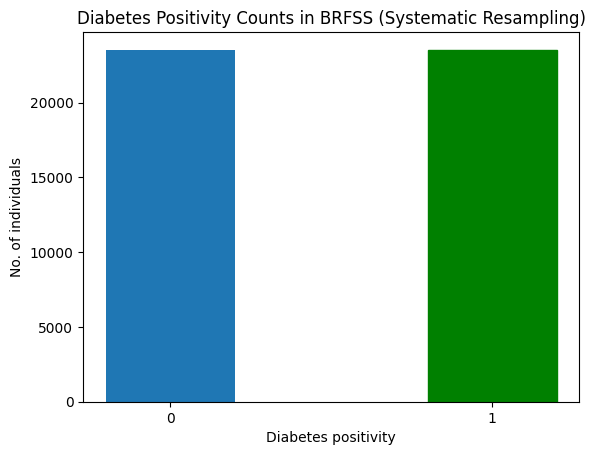

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [ ]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7335 - loss: 0.6064 - val_AUC: 0.8023 - val_loss: 0.5509
Epoch 2/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7933 - loss: 0.5519 - val_AUC: 0.8118 - val_loss: 0.5351
Epoch 3/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8034 - loss: 0.5389 - val_AUC: 0.8149 - val_loss: 0.5242
Epoch 4/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8149 - loss: 0.5220 - val_AUC: 0.8236 - val_loss: 0.5242
Epoch 5/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8231 - loss: 0.5119 - val_AUC: 0.8332 - val_loss: 0.4996
Epoch 6/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8338 - loss: 0.4986 - val_AUC: 0.8381 - val_loss: 0.4976
Epoch 7/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8483 - loss: 0.4807 - val_AUC: 0.8551 - val_loss: 0.4811
Epoch 8/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8601 - loss: 0.4648 - val_AUC: 0.8619 - val_loss: 0.4642
Epoch 9/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AU

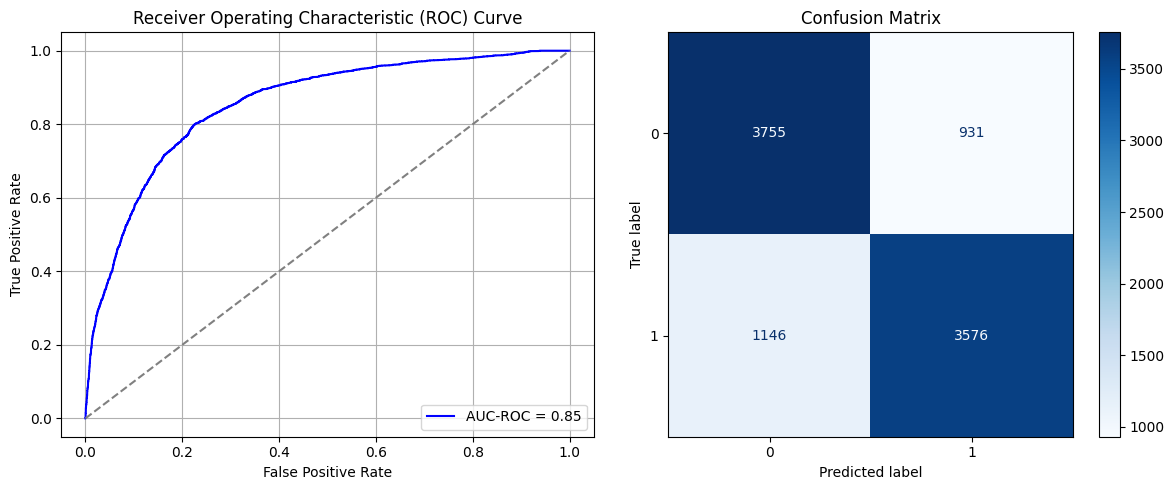

<ipython-input-29-93669339d7ff>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9898375868797302
Time elapsed (performance): 49.13984669199999


<Sequential name=sequential, built=True>

In [ ]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.6268821892778539
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.45      0.61      2792
           1       0.14      0.72      0.23       345

    accuracy                           0.48      3137
   macro avg       0.53      0.59      0.42      3137
weighted avg       0.84      0.48      0.57      3137

FPR 0.5501432664756447 TPR: 0.7246376811594203 FNR: 0.2753623188405797 TNR: 0.4498567335243553


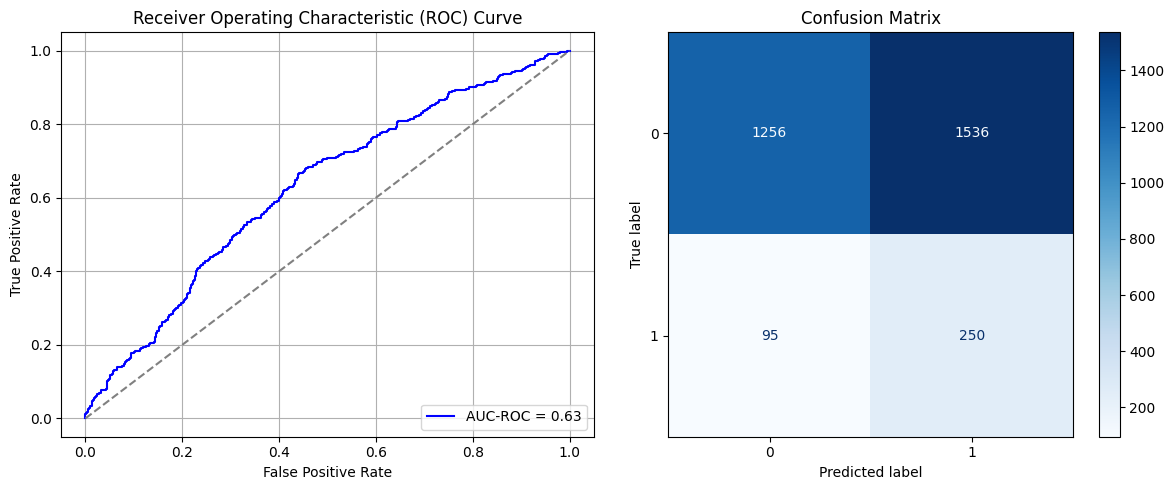

Best threshold based on F1-score: 0.5600868463516235
False Negative Rate: 0.2753623188405797
Time elapsed (performance): 0.7689110059999962


In [ ]:
Transductive_TL(model_source_Sy_ROS, X_T_test, y_T_test, "Target")

In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6543 - loss: 0.3798 - val_AUC: 0.7309 - val_loss: 0.3266
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7522 - loss: 0.3044 - val_AUC: 0.7522 - val_loss: 0.3201
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7509 - loss: 0.2964 - val_AUC: 0.7675 - val_loss: 0.3174
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7815 - loss: 0.2936 - val_AUC: 0.7759 - val_loss: 0.3069
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7728 - loss: 0.2957 - val_AUC: 0.7822 - val_loss: 0.3025
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.7897 - loss: 0.2780 - val_AUC: 0.7909 - val_loss: 0.3001
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7863 - loss: 0.2760 - val_AUC: 0.7935 - val_loss: 0.2978
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7950 - loss: 0.2797 -

(np.float64(0.0060888252148997134), np.float64(0.8376811594202899))

In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7307 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8100
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7867 - loss: 0.5317 - val_AUC: 0.0000e+00 - val_loss: 0.7502
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7905 - loss: 0.5269 - val_AUC: 0.0000e+00 - val_loss: 0.7464
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8011 - loss: 0.5136 - val_AUC: 0.0000e+00 - val_loss: 0.7436
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8162 - loss: 0.5021 - val_AUC: 0.0000e+00 - val_loss: 0.7555
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8230 - loss: 0.4942 - val_AUC: 0.0000e+00 - val_loss: 0.7291
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8325 - loss: 0.4790 - val_AUC: 0.0000e+00 - val_loss: 0.7772
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8371 - loss: 0.4766 - val_AUC: 0.0000e+00 - val_loss: 0.7859
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

(np.float64(0.11138968481375358), np.float64(0.391304347826087))

In [ ]:
times = 50

FPR = []
FNR = []

for i in range(times):
    fpr, fnr = fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)
    # print(output)
    FPR.append(fpr)
    FNR.append(fnr)

ParamFit = pd.DataFrame([FPR, FNR]).T
ParamFit.columns=['FPR', 'FNR']

# fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7341 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.7515
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7882 - loss: 0.5302 - val_AUC: 0.0000e+00 - val_loss: 0.7728
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7925 - loss: 0.5235 - val_AUC: 0.0000e+00 - val_loss: 0.8306
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8028 - loss: 0.5143 - val_AUC: 0.0000e+00 - val_loss: 0.7561
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8133 - loss: 0.5018 - val_AUC: 0.0000e+00 - val_loss: 0.7237
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8176 - loss: 0.4965 - val_AUC: 0.0000e+00 - val_loss: 0.6612
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8299 - loss: 0.4837 - val_AUC: 0.0000e+00 - val_loss: 0.8535
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7259 - loss: 0.5833 - val_AUC: 0.0000e+00 - val_loss: 0.8876
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7911 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.7406
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7921 - loss: 0.5256 - val_AUC: 0.0000e+00 - val_loss: 0.6498
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8048 - loss: 0.5116 - val_AUC: 0.0000e+00 - val_loss: 0.6979
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8126 - loss: 0.5034 - val_AUC: 0.0000e+00 - val_loss: 0.6738
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8157 - loss: 0.4974 - val_AUC: 0.0000e+00 - val_loss: 0.8448
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8276 - loss: 0.4852 - val_AUC: 0.0000e+00 - val_loss: 0.6381
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8309 - loss: 0.4805 - val_AUC: 0.0000e+00 - val_loss: 0.8803
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7330 - loss: 0.5801 - val_AUC: 0.0000e+00 - val_loss: 0.7101
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7850 - loss: 0.5329 - val_AUC: 0.0000e+00 - val_loss: 0.7640
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7970 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.7756
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8068 - loss: 0.5095 - val_AUC: 0.0000e+00 - val_loss: 0.7451
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8140 - loss: 0.5008 - val_AUC: 0.0000e+00 - val_loss: 0.7112
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8191 - loss: 0.4953 - val_AUC: 0.0000e+00 - val_loss: 0.7316
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8223 - loss: 0.4931 - val_AUC: 0.0000e+00 - val_loss: 0.7609
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8288 - loss: 0.4847 - val_AUC: 0.0000e+00 - val_loss: 0.7399
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7299 - loss: 0.5749 - val_AUC: 0.0000e+00 - val_loss: 0.7494
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7850 - loss: 0.5302 - val_AUC: 0.0000e+00 - val_loss: 0.7599
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7969 - loss: 0.5197 - val_AUC: 0.0000e+00 - val_loss: 0.7755
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8119 - loss: 0.5072 - val_AUC: 0.0000e+00 - val_loss: 0.8546
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8172 - loss: 0.4999 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8216 - loss: 0.4935 - val_AUC: 0.0000e+00 - val_loss: 0.8226
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8258 - loss: 0.4878 - val_AUC: 0.0000e+00 - val_loss: 0.6981
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8374 - loss: 0.4750 - val_AUC: 0.0000e+00 - val_loss: 0.6586
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7374 - loss: 0.5755 - val_AUC: 0.0000e+00 - val_loss: 0.7214
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7838 - loss: 0.5317 - val_AUC: 0.0000e+00 - val_loss: 0.7321
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7938 - loss: 0.5231 - val_AUC: 0.0000e+00 - val_loss: 0.7274
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8037 - loss: 0.5121 - val_AUC: 0.0000e+00 - val_loss: 0.8806
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8135 - loss: 0.5007 - val_AUC: 0.0000e+00 - val_loss: 0.6733
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8241 - loss: 0.4903 - val_AUC: 0.0000e+00 - val_loss: 0.6908
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8279 - loss: 0.4841 - val_AUC: 0.0000e+00 - val_loss: 0.6470
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8349 - loss: 0.4759 - val_AUC: 0.0000e+00 - val_loss: 0.6826
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7339 - loss: 0.5780 - val_AUC: 0.0000e+00 - val_loss: 0.8456
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7792 - loss: 0.5357 - val_AUC: 0.0000e+00 - val_loss: 0.7308
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7906 - loss: 0.5261 - val_AUC: 0.0000e+00 - val_loss: 0.7484
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8066 - loss: 0.5097 - val_AUC: 0.0000e+00 - val_loss: 0.8195
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8125 - loss: 0.5023 - val_AUC: 0.0000e+00 - val_loss: 0.6325
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8187 - loss: 0.4958 - val_AUC: 0.0000e+00 - val_loss: 0.7240
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8246 - loss: 0.4932 - val_AUC: 0.0000e+00 - val_loss: 0.6346
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8255 - loss: 0.4897 - val_AUC: 0.0000e+00 - val_loss: 0.6537
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_77 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7296 - loss: 0.5792 - val_AUC: 0.0000e+00 - val_loss: 0.8181
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7777 - loss: 0.5383 - val_AUC: 0.0000e+00 - val_loss: 0.7259
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7985 - loss: 0.5201 - val_AUC: 0.0000e+00 - val_loss: 0.8019
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8058 - loss: 0.5121 - val_AUC: 0.0000e+00 - val_loss: 0.6736
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8166 - loss: 0.5001 - val_AUC: 0.0000e+00 - val_loss: 0.7487
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8235 - loss: 0.4918 - val_AUC: 0.0000e+00 - val_loss: 0.7918
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8227 - loss: 0.4894 - val_AUC: 0.0000e+00 - val_loss: 0.5900
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8255 - loss: 0.4894 - val_AUC: 0.0000e+00 - val_loss: 0.7207
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7336 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.7984
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7803 - loss: 0.5355 - val_AUC: 0.0000e+00 - val_loss: 0.8207
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7999 - loss: 0.5195 - val_AUC: 0.0000e+00 - val_loss: 0.7183
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8105 - loss: 0.5047 - val_AUC: 0.0000e+00 - val_loss: 0.7026
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8201 - loss: 0.4936 - val_AUC: 0.0000e+00 - val_loss: 0.7490
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8282 - loss: 0.4847 - val_AUC: 0.0000e+00 - val_loss: 0.6639
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8348 - loss: 0.4782 - val_AUC: 0.0000e+00 - val_loss: 0.6201
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8318 - loss: 0.4801 - val_AUC: 0.0000e+00 - val_loss: 0.6257
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7338 - loss: 0.5763 - val_AUC: 0.0000e+00 - val_loss: 0.7463
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7803 - loss: 0.5358 - val_AUC: 0.0000e+00 - val_loss: 0.7597
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8001 - loss: 0.5143 - val_AUC: 0.0000e+00 - val_loss: 0.6627
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8088 - loss: 0.5073 - val_AUC: 0.0000e+00 - val_loss: 0.8491
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8094 - loss: 0.5051 - val_AUC: 0.0000e+00 - val_loss: 0.8110
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8190 - loss: 0.4950 - val_AUC: 0.0000e+00 - val_loss: 0.7912
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8293 - loss: 0.4845 - val_AUC: 0.0000e+00 - val_loss: 0.7968
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8214 - loss: 0.4910 - val_AUC: 0.0000e+00 - val_loss: 0.7044
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7372 - loss: 0.5764 - val_AUC: 0.0000e+00 - val_loss: 0.8110
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7879 - loss: 0.5314 - val_AUC: 0.0000e+00 - val_loss: 0.7800
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8062 - loss: 0.5092 - val_AUC: 0.0000e+00 - val_loss: 0.7215
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8065 - loss: 0.5087 - val_AUC: 0.0000e+00 - val_loss: 0.7435
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8191 - loss: 0.4934 - val_AUC: 0.0000e+00 - val_loss: 0.7433
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8237 - loss: 0.4922 - val_AUC: 0.0000e+00 - val_loss: 0.7079
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8346 - loss: 0.4800 - val_AUC: 0.0000e+00 - val_loss: 0.7535
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8373 - loss: 0.4756 - val_AUC: 0.0000e+00 - val_loss: 0.5746
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7289 - loss: 0.5835 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7829 - loss: 0.5338 - val_AUC: 0.0000e+00 - val_loss: 0.8378
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7970 - loss: 0.5214 - val_AUC: 0.0000e+00 - val_loss: 0.7758
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8117 - loss: 0.5035 - val_AUC: 0.0000e+00 - val_loss: 0.7529
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8131 - loss: 0.5001 - val_AUC: 0.0000e+00 - val_loss: 0.6686
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8244 - loss: 0.4923 - val_AUC: 0.0000e+00 - val_loss: 0.7277
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8233 - loss: 0.4924 - val_AUC: 0.0000e+00 - val_loss: 0.8473
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8318 - loss: 0.4819 - val_AUC: 0.0000e+00 - val_loss: 0.6698
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7270 - loss: 0.5838 - val_AUC: 0.0000e+00 - val_loss: 0.7373
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7812 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.8090
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7953 - loss: 0.5213 - val_AUC: 0.0000e+00 - val_loss: 0.6987
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8015 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.6544
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8148 - loss: 0.4982 - val_AUC: 0.0000e+00 - val_loss: 0.5996
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8229 - loss: 0.4904 - val_AUC: 0.0000e+00 - val_loss: 0.6483
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8291 - loss: 0.4826 - val_AUC: 0.0000e+00 - val_loss: 0.7144
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8306 - loss: 0.4838 - val_AUC: 0.0000e+00 - val_loss: 0.7513
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_119 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7338 - loss: 0.5759 - val_AUC: 0.0000e+00 - val_loss: 0.7919
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7818 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.7316
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7946 - loss: 0.5230 - val_AUC: 0.0000e+00 - val_loss: 0.6936
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8081 - loss: 0.5080 - val_AUC: 0.0000e+00 - val_loss: 0.6675
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8148 - loss: 0.5004 - val_AUC: 0.0000e+00 - val_loss: 0.6805
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8210 - loss: 0.4965 - val_AUC: 0.0000e+00 - val_loss: 0.7363
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8283 - loss: 0.4846 - val_AUC: 0.0000e+00 - val_loss: 0.7431
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8364 - loss: 0.4767 - val_AUC: 0.0000e+00 - val_loss: 0.8514
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7300 - loss: 0.5831 - val_AUC: 0.0000e+00 - val_loss: 0.8472
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7809 - loss: 0.5386 - val_AUC: 0.0000e+00 - val_loss: 0.8370
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7893 - loss: 0.5287 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8111 - loss: 0.5092 - val_AUC: 0.0000e+00 - val_loss: 0.8163
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8072 - loss: 0.5069 - val_AUC: 0.0000e+00 - val_loss: 0.7062
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8220 - loss: 0.4962 - val_AUC: 0.0000e+00 - val_loss: 0.7637
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8297 - loss: 0.4829 - val_AUC: 0.0000e+00 - val_loss: 0.6710
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8344 - loss: 0.4768 - val_AUC: 0.0000e+00 - val_loss: 0.6996
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7255 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.7878
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7937 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.8006
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8052 - loss: 0.5119 - val_AUC: 0.0000e+00 - val_loss: 0.7548
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8118 - loss: 0.5072 - val_AUC: 0.0000e+00 - val_loss: 0.6539
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8159 - loss: 0.4990 - val_AUC: 0.0000e+00 - val_loss: 0.7002
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8182 - loss: 0.4985 - val_AUC: 0.0000e+00 - val_loss: 0.6783
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8229 - loss: 0.4910 - val_AUC: 0.0000e+00 - val_loss: 0.8356
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8325 - loss: 0.4795 - val_AUC: 0.0000e+00 - val_loss: 0.6150
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7373 - loss: 0.5739 - val_AUC: 0.0000e+00 - val_loss: 0.8034
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7845 - loss: 0.5324 - val_AUC: 0.0000e+00 - val_loss: 0.6917
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7933 - loss: 0.5223 - val_AUC: 0.0000e+00 - val_loss: 0.7378
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8104 - loss: 0.5061 - val_AUC: 0.0000e+00 - val_loss: 0.6486
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8129 - loss: 0.5058 - val_AUC: 0.0000e+00 - val_loss: 0.7216
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8126 - loss: 0.5017 - val_AUC: 0.0000e+00 - val_loss: 0.6947
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8228 - loss: 0.4935 - val_AUC: 0.0000e+00 - val_loss: 0.6649
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8255 - loss: 0.4865 - val_AUC: 0.0000e+00 - val_loss: 0.6343
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7248 - loss: 0.5872 - val_AUC: 0.0000e+00 - val_loss: 0.7750
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7764 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.7661
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7925 - loss: 0.5231 - val_AUC: 0.0000e+00 - val_loss: 0.6619
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8036 - loss: 0.5133 - val_AUC: 0.0000e+00 - val_loss: 0.6900
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8069 - loss: 0.5087 - val_AUC: 0.0000e+00 - val_loss: 0.7511
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8201 - loss: 0.4938 - val_AUC: 0.0000e+00 - val_loss: 0.7160
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8258 - loss: 0.4875 - val_AUC: 0.0000e+00 - val_loss: 0.6843
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8312 - loss: 0.4838 - val_AUC: 0.0000e+00 - val_loss: 0.6080
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7245 - loss: 0.5871 - val_AUC: 0.0000e+00 - val_loss: 0.8347
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7844 - loss: 0.5337 - val_AUC: 0.0000e+00 - val_loss: 0.7469
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7893 - loss: 0.5275 - val_AUC: 0.0000e+00 - val_loss: 0.7971
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8090 - loss: 0.5094 - val_AUC: 0.0000e+00 - val_loss: 0.7182
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8109 - loss: 0.5072 - val_AUC: 0.0000e+00 - val_loss: 0.7083
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8183 - loss: 0.4963 - val_AUC: 0.0000e+00 - val_loss: 0.7814
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8270 - loss: 0.4860 - val_AUC: 0.0000e+00 - val_loss: 0.7822
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8278 - loss: 0.4866 - val_AUC: 0.0000e+00 - val_loss: 0.5972
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_161 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7287 - loss: 0.5821 - val_AUC: 0.0000e+00 - val_loss: 0.8376
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7797 - loss: 0.5363 - val_AUC: 0.0000e+00 - val_loss: 0.7285
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7927 - loss: 0.5242 - val_AUC: 0.0000e+00 - val_loss: 0.7812
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8042 - loss: 0.5152 - val_AUC: 0.0000e+00 - val_loss: 0.7128
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8148 - loss: 0.5000 - val_AUC: 0.0000e+00 - val_loss: 0.6086
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8232 - loss: 0.4915 - val_AUC: 0.0000e+00 - val_loss: 0.6234
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8268 - loss: 0.4881 - val_AUC: 0.0000e+00 - val_loss: 0.7519
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8349 - loss: 0.4799 - val_AUC: 0.0000e+00 - val_loss: 0.7336
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7306 - loss: 0.5820 - val_AUC: 0.0000e+00 - val_loss: 0.7538
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7810 - loss: 0.5352 - val_AUC: 0.0000e+00 - val_loss: 0.8461
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7937 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.7383
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8099 - loss: 0.5064 - val_AUC: 0.0000e+00 - val_loss: 0.6587
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8173 - loss: 0.4954 - val_AUC: 0.0000e+00 - val_loss: 0.8301
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8237 - loss: 0.4890 - val_AUC: 0.0000e+00 - val_loss: 0.7750
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8343 - loss: 0.4765 - val_AUC: 0.0000e+00 - val_loss: 0.6772
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8317 - loss: 0.4827 - val_AUC: 0.0000e+00 - val_loss: 0.7901
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7245 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.7536
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7850 - loss: 0.5310 - val_AUC: 0.0000e+00 - val_loss: 0.7902
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7970 - loss: 0.5215 - val_AUC: 0.0000e+00 - val_loss: 0.7778
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8053 - loss: 0.5112 - val_AUC: 0.0000e+00 - val_loss: 0.5627
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8182 - loss: 0.4980 - val_AUC: 0.0000e+00 - val_loss: 0.7633
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8245 - loss: 0.4909 - val_AUC: 0.0000e+00 - val_loss: 0.7949
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8294 - loss: 0.4849 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8384 - loss: 0.4753 - val_AUC: 0.0000e+00 - val_loss: 0.8283
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7195 - loss: 0.5899 - val_AUC: 0.0000e+00 - val_loss: 0.8895
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7844 - loss: 0.5336 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7961 - loss: 0.5225 - val_AUC: 0.0000e+00 - val_loss: 0.7297
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8068 - loss: 0.5094 - val_AUC: 0.0000e+00 - val_loss: 0.8443
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8126 - loss: 0.5041 - val_AUC: 0.0000e+00 - val_loss: 0.6702
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8240 - loss: 0.4894 - val_AUC: 0.0000e+00 - val_loss: 0.7450
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8314 - loss: 0.4821 - val_AUC: 0.0000e+00 - val_loss: 0.7761
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8356 - loss: 0.4776 - val_AUC: 0.0000e+00 - val_loss: 0.8020
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7319 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.7352
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7878 - loss: 0.5290 - val_AUC: 0.0000e+00 - val_loss: 0.7737
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7959 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.8300
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8100 - loss: 0.5059 - val_AUC: 0.0000e+00 - val_loss: 0.6783
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8179 - loss: 0.4970 - val_AUC: 0.0000e+00 - val_loss: 0.7710
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8251 - loss: 0.4913 - val_AUC: 0.0000e+00 - val_loss: 0.8336
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8271 - loss: 0.4877 - val_AUC: 0.0000e+00 - val_loss: 0.6904
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8361 - loss: 0.4755 - val_AUC: 0.0000e+00 - val_loss: 0.7635
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7191 - loss: 0.5921 - val_AUC: 0.0000e+00 - val_loss: 0.7315
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7831 - loss: 0.5363 - val_AUC: 0.0000e+00 - val_loss: 0.7777
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7959 - loss: 0.5189 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8089 - loss: 0.5081 - val_AUC: 0.0000e+00 - val_loss: 0.6346
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8139 - loss: 0.5005 - val_AUC: 0.0000e+00 - val_loss: 0.6822
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8238 - loss: 0.4892 - val_AUC: 0.0000e+00 - val_loss: 0.8489
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8286 - loss: 0.4856 - val_AUC: 0.0000e+00 - val_loss: 0.7329
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8311 - loss: 0.4811 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7240 - loss: 0.5850 - val_AUC: 0.0000e+00 - val_loss: 0.8767
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7837 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.7163
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7941 - loss: 0.5219 - val_AUC: 0.0000e+00 - val_loss: 0.7486
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8072 - loss: 0.5089 - val_AUC: 0.0000e+00 - val_loss: 0.9132
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8147 - loss: 0.5005 - val_AUC: 0.0000e+00 - val_loss: 0.8200
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.8217 - loss: 0.4931 - val_AUC: 0.0000e+00 - val_loss: 0.6819
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8276 - loss: 0.4860 - val_AUC: 0.0000e+00 - val_loss: 0.6581
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8285 - loss: 0.4841 - val_AUC: 0.0000e+00 - val_loss: 0.7109
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7343 - loss: 0.5781 - val_AUC: 0.0000e+00 - val_loss: 0.7501
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7835 - loss: 0.5325 - val_AUC: 0.0000e+00 - val_loss: 0.8015
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7966 - loss: 0.5207 - val_AUC: 0.0000e+00 - val_loss: 0.8402
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8093 - loss: 0.5073 - val_AUC: 0.0000e+00 - val_loss: 0.6258
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8125 - loss: 0.5011 - val_AUC: 0.0000e+00 - val_loss: 0.7901
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8253 - loss: 0.4888 - val_AUC: 0.0000e+00 - val_loss: 0.6814
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8277 - loss: 0.4873 - val_AUC: 0.0000e+00 - val_loss: 0.6375
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8377 - loss: 0.4738 - val_AUC: 0.0000e+00 - val_loss: 0.7565
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7294 - loss: 0.5829 - val_AUC: 0.0000e+00 - val_loss: 0.8781
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7805 - loss: 0.5346 - val_AUC: 0.0000e+00 - val_loss: 0.7175
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8035 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.7672
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8102 - loss: 0.5073 - val_AUC: 0.0000e+00 - val_loss: 0.6667
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8142 - loss: 0.5026 - val_AUC: 0.0000e+00 - val_loss: 0.7089
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8209 - loss: 0.4950 - val_AUC: 0.0000e+00 - val_loss: 0.8890
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8218 - loss: 0.4904 - val_AUC: 0.0000e+00 - val_loss: 0.7404
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8325 - loss: 0.4777 - val_AUC: 0.0000e+00 - val_loss: 0.6643
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7322 - loss: 0.5796 - val_AUC: 0.0000e+00 - val_loss: 0.8079
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7858 - loss: 0.5354 - val_AUC: 0.0000e+00 - val_loss: 0.7949
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7971 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.9404
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8091 - loss: 0.5069 - val_AUC: 0.0000e+00 - val_loss: 0.8298
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8161 - loss: 0.5002 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8222 - loss: 0.4921 - val_AUC: 0.0000e+00 - val_loss: 0.7290
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8302 - loss: 0.4836 - val_AUC: 0.0000e+00 - val_loss: 0.7059
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8314 - loss: 0.4835 - val_AUC: 0.0000e+00 - val_loss: 0.7615
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.7309 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.7808
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7842 - loss: 0.5335 - val_AUC: 0.0000e+00 - val_loss: 0.7073
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7973 - loss: 0.5179 - val_AUC: 0.0000e+00 - val_loss: 0.7775
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8060 - loss: 0.5090 - val_AUC: 0.0000e+00 - val_loss: 0.7030
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8099 - loss: 0.5072 - val_AUC: 0.0000e+00 - val_loss: 0.7231
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8195 - loss: 0.4944 - val_AUC: 0.0000e+00 - val_loss: 0.7909
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8217 - loss: 0.4921 - val_AUC: 0.0000e+00 - val_loss: 0.6692
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8320 - loss: 0.4822 - val_AUC: 0.0000e+00 - val_loss: 0.7606
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7288 - loss: 0.5817 - val_AUC: 0.0000e+00 - val_loss: 0.7615
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7846 - loss: 0.5342 - val_AUC: 0.0000e+00 - val_loss: 0.7184
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7903 - loss: 0.5275 - val_AUC: 0.0000e+00 - val_loss: 0.7253
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8069 - loss: 0.5092 - val_AUC: 0.0000e+00 - val_loss: 0.7252
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8123 - loss: 0.5029 - val_AUC: 0.0000e+00 - val_loss: 0.6671
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8176 - loss: 0.4967 - val_AUC: 0.0000e+00 - val_loss: 0.7670
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8215 - loss: 0.4929 - val_AUC: 0.0000e+00 - val_loss: 0.7463
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8319 - loss: 0.4792 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7322 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.7333
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7903 - loss: 0.5283 - val_AUC: 0.0000e+00 - val_loss: 0.8090
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7981 - loss: 0.5195 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8100 - loss: 0.5066 - val_AUC: 0.0000e+00 - val_loss: 0.7616
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8086 - loss: 0.5067 - val_AUC: 0.0000e+00 - val_loss: 0.7293
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8199 - loss: 0.4977 - val_AUC: 0.0000e+00 - val_loss: 0.8302
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8282 - loss: 0.4828 - val_AUC: 0.0000e+00 - val_loss: 0.6259
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8291 - loss: 0.4860 - val_AUC: 0.0000e+00 - val_loss: 0.7161
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7365 - loss: 0.5752 - val_AUC: 0.0000e+00 - val_loss: 0.8344
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7795 - loss: 0.5375 - val_AUC: 0.0000e+00 - val_loss: 0.7076
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7950 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.8249
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8001 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.7652
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8129 - loss: 0.5003 - val_AUC: 0.0000e+00 - val_loss: 0.7130
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8264 - loss: 0.4863 - val_AUC: 0.0000e+00 - val_loss: 0.7773
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8294 - loss: 0.4853 - val_AUC: 0.0000e+00 - val_loss: 0.6096
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8353 - loss: 0.4786 - val_AUC: 0.0000e+00 - val_loss: 0.6573
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_259 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7304 - loss: 0.5808 - val_AUC: 0.0000e+00 - val_loss: 0.8390
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7872 - loss: 0.5321 - val_AUC: 0.0000e+00 - val_loss: 0.8542
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7966 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.8125
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8090 - loss: 0.5047 - val_AUC: 0.0000e+00 - val_loss: 0.6826
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8165 - loss: 0.5007 - val_AUC: 0.0000e+00 - val_loss: 0.6181
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8256 - loss: 0.4875 - val_AUC: 0.0000e+00 - val_loss: 0.5969
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8342 - loss: 0.4777 - val_AUC: 0.0000e+00 - val_loss: 0.6038
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8323 - loss: 0.4808 - val_AUC: 0.0000e+00 - val_loss: 0.7444
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7330 - loss: 0.5785 - val_AUC: 0.0000e+00 - val_loss: 0.8482
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7757 - loss: 0.5398 - val_AUC: 0.0000e+00 - val_loss: 0.6939
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7991 - loss: 0.5161 - val_AUC: 0.0000e+00 - val_loss: 0.7665
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8057 - loss: 0.5078 - val_AUC: 0.0000e+00 - val_loss: 0.6065
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8197 - loss: 0.4949 - val_AUC: 0.0000e+00 - val_loss: 0.6823
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8237 - loss: 0.4878 - val_AUC: 0.0000e+00 - val_loss: 0.8195
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8247 - loss: 0.4885 - val_AUC: 0.0000e+00 - val_loss: 0.6757
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8351 - loss: 0.4780 - val_AUC: 0.0000e+00 - val_loss: 0.7131
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7239 - loss: 0.5859 - val_AUC: 0.0000e+00 - val_loss: 0.6999
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7802 - loss: 0.5361 - val_AUC: 0.0000e+00 - val_loss: 0.9269
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7961 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.7176
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8030 - loss: 0.5154 - val_AUC: 0.0000e+00 - val_loss: 0.8028
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8100 - loss: 0.5066 - val_AUC: 0.0000e+00 - val_loss: 0.7648
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8245 - loss: 0.4892 - val_AUC: 0.0000e+00 - val_loss: 0.7328
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8288 - loss: 0.4868 - val_AUC: 0.0000e+00 - val_loss: 0.7340
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8344 - loss: 0.4767 - val_AUC: 0.0000e+00 - val_loss: 0.6547
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7393 - loss: 0.5721 - val_AUC: 0.0000e+00 - val_loss: 0.8978
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7836 - loss: 0.5330 - val_AUC: 0.0000e+00 - val_loss: 0.7279
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7934 - loss: 0.5241 - val_AUC: 0.0000e+00 - val_loss: 0.8066
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8063 - loss: 0.5078 - val_AUC: 0.0000e+00 - val_loss: 0.6780
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8178 - loss: 0.4988 - val_AUC: 0.0000e+00 - val_loss: 0.7681
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8259 - loss: 0.4886 - val_AUC: 0.0000e+00 - val_loss: 0.7162
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8328 - loss: 0.4789 - val_AUC: 0.0000e+00 - val_loss: 0.6896
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8340 - loss: 0.4802 - val_AUC: 0.0000e+00 - val_loss: 0.6550
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7293 - loss: 0.5805 - val_AUC: 0.0000e+00 - val_loss: 0.8231
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7887 - loss: 0.5295 - val_AUC: 0.0000e+00 - val_loss: 0.7317
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7984 - loss: 0.5151 - val_AUC: 0.0000e+00 - val_loss: 0.8595
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8039 - loss: 0.5109 - val_AUC: 0.0000e+00 - val_loss: 0.6620
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8088 - loss: 0.5044 - val_AUC: 0.0000e+00 - val_loss: 0.5887
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8168 - loss: 0.4980 - val_AUC: 0.0000e+00 - val_loss: 0.6565
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8213 - loss: 0.4934 - val_AUC: 0.0000e+00 - val_loss: 0.6905
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8277 - loss: 0.4865 - val_AUC: 0.0000e+00 - val_loss: 0.6911
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7360 - loss: 0.5767 - val_AUC: 0.0000e+00 - val_loss: 0.7556
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7849 - loss: 0.5327 - val_AUC: 0.0000e+00 - val_loss: 0.7918
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7963 - loss: 0.5194 - val_AUC: 0.0000e+00 - val_loss: 0.7237
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8033 - loss: 0.5110 - val_AUC: 0.0000e+00 - val_loss: 0.7250
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8151 - loss: 0.5024 - val_AUC: 0.0000e+00 - val_loss: 0.7603
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8219 - loss: 0.4939 - val_AUC: 0.0000e+00 - val_loss: 0.6883
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.8271 - loss: 0.4867 - val_AUC: 0.0000e+00 - val_loss: 0.7267
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.8311 - loss: 0.4818 - val_AUC: 0.0000e+00 - val_loss: 0.7493
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7328 - loss: 0.5779 - val_AUC: 0.0000e+00 - val_loss: 0.7594
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7870 - loss: 0.5277 - val_AUC: 0.0000e+00 - val_loss: 0.7705
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7960 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.7719
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8031 - loss: 0.5137 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8143 - loss: 0.4995 - val_AUC: 0.0000e+00 - val_loss: 0.7945
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8229 - loss: 0.4888 - val_AUC: 0.0000e+00 - val_loss: 0.8484
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8214 - loss: 0.4939 - val_AUC: 0.0000e+00 - val_loss: 0.7066
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8282 - loss: 0.4848 - val_AUC: 0.0000e+00 - val_loss: 0.7536
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7288 - loss: 0.5804 - val_AUC: 0.0000e+00 - val_loss: 0.8033
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7856 - loss: 0.5312 - val_AUC: 0.0000e+00 - val_loss: 0.7168
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8046 - loss: 0.5126 - val_AUC: 0.0000e+00 - val_loss: 0.7825
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8018 - loss: 0.5130 - val_AUC: 0.0000e+00 - val_loss: 0.8129
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8138 - loss: 0.5035 - val_AUC: 0.0000e+00 - val_loss: 0.7327
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8201 - loss: 0.4955 - val_AUC: 0.0000e+00 - val_loss: 0.6889
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8256 - loss: 0.4885 - val_AUC: 0.0000e+00 - val_loss: 0.6986
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8342 - loss: 0.4770 - val_AUC: 0.0000e+00 - val_loss: 0.7965
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7385 - loss: 0.5744 - val_AUC: 0.0000e+00 - val_loss: 0.8590
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7817 - loss: 0.5358 - val_AUC: 0.0000e+00 - val_loss: 0.7787
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7927 - loss: 0.5230 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8056 - loss: 0.5098 - val_AUC: 0.0000e+00 - val_loss: 0.7120
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8142 - loss: 0.5000 - val_AUC: 0.0000e+00 - val_loss: 0.7846
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8296 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.7193
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8259 - loss: 0.4853 - val_AUC: 0.0000e+00 - val_loss: 0.8184
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8324 - loss: 0.4824 - val_AUC: 0.0000e+00 - val_loss: 0.8350
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7193 - loss: 0.5910 - val_AUC: 0.0000e+00 - val_loss: 0.7962
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7855 - loss: 0.5316 - val_AUC: 0.0000e+00 - val_loss: 0.9192
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7943 - loss: 0.5210 - val_AUC: 0.0000e+00 - val_loss: 0.7339
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8046 - loss: 0.5113 - val_AUC: 0.0000e+00 - val_loss: 0.7436
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8176 - loss: 0.4996 - val_AUC: 0.0000e+00 - val_loss: 0.6716
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8206 - loss: 0.4948 - val_AUC: 0.0000e+00 - val_loss: 0.7016
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8231 - loss: 0.4892 - val_AUC: 0.0000e+00 - val_loss: 0.5898
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8285 - loss: 0.4848 - val_AUC: 0.0000e+00 - val_loss: 0.7155
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_329 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7332 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.7829
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.7812 - loss: 0.5356 - val_AUC: 0.0000e+00 - val_loss: 0.7384
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7957 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.7076
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8081 - loss: 0.5093 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8193 - loss: 0.4982 - val_AUC: 0.0000e+00 - val_loss: 0.6789
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8209 - loss: 0.4930 - val_AUC: 0.0000e+00 - val_loss: 0.7790
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8261 - loss: 0.4866 - val_AUC: 0.0000e+00 - val_loss: 0.7200
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8291 - loss: 0.4867 - val_AUC: 0.0000e+00 - val_loss: 0.6511
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7247 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8141
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7809 - loss: 0.5352 - val_AUC: 0.0000e+00 - val_loss: 0.6110
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7933 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.6936
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8112 - loss: 0.5056 - val_AUC: 0.0000e+00 - val_loss: 0.7803
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8129 - loss: 0.5056 - val_AUC: 0.0000e+00 - val_loss: 0.7641
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8295 - loss: 0.4851 - val_AUC: 0.0000e+00 - val_loss: 0.7074
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8287 - loss: 0.4835 - val_AUC: 0.0000e+00 - val_loss: 0.8209
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8364 - loss: 0.4752 - val_AUC: 0.0000e+00 - val_loss: 0.6970
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7275 - loss: 0.5823 - val_AUC: 0.0000e+00 - val_loss: 0.8380
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7898 - loss: 0.5275 - val_AUC: 0.0000e+00 - val_loss: 0.7959
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7965 - loss: 0.5204 - val_AUC: 0.0000e+00 - val_loss: 0.8233
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8070 - loss: 0.5087 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8189 - loss: 0.4972 - val_AUC: 0.0000e+00 - val_loss: 0.5737
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8179 - loss: 0.4978 - val_AUC: 0.0000e+00 - val_loss: 0.8210
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8238 - loss: 0.4883 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8331 - loss: 0.4801 - val_AUC: 0.0000e+00 - val_loss: 0.7281
Epoch 9/10
556/556 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7223 - loss: 0.5836 - val_AUC: 0.0000e+00 - val_loss: 0.8450
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7809 - loss: 0.5366 - val_AUC: 0.0000e+00 - val_loss: 0.8312
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7915 - loss: 0.5280 - val_AUC: 0.0000e+00 - val_loss: 0.7923
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8019 - loss: 0.5156 - val_AUC: 0.0000e+00 - val_loss: 0.7961
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8100 - loss: 0.5032 - val_AUC: 0.0000e+00 - val_loss: 0.6418
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8212 - loss: 0.4932 - val_AUC: 0.0000e+00 - val_loss: 0.6174
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8279 - loss: 0.4861 - val_AUC: 0.0000e+00 - val_loss: 0.7447
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8272 - loss: 0.4869 - val_AUC: 0.0000e+00 - val_loss: 0.5830
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7381 - loss: 0.5735 - val_AUC: 0.0000e+00 - val_loss: 0.8625
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7843 - loss: 0.5281 - val_AUC: 0.0000e+00 - val_loss: 0.8711
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7953 - loss: 0.5243 - val_AUC: 0.0000e+00 - val_loss: 0.7932
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8114 - loss: 0.5035 - val_AUC: 0.0000e+00 - val_loss: 0.7073
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8127 - loss: 0.5026 - val_AUC: 0.0000e+00 - val_loss: 0.7828
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8221 - loss: 0.4937 - val_AUC: 0.0000e+00 - val_loss: 0.7284
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8293 - loss: 0.4834 - val_AUC: 0.0000e+00 - val_loss: 0.6813
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8301 - loss: 0.4815 - val_AUC: 0.0000e+00 - val_loss: 0.5647
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7324 - loss: 0.5813 - val_AUC: 0.0000e+00 - val_loss: 0.7912
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7899 - loss: 0.5258 - val_AUC: 0.0000e+00 - val_loss: 0.7528
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7942 - loss: 0.5171 - val_AUC: 0.0000e+00 - val_loss: 0.7224
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8103 - loss: 0.5062 - val_AUC: 0.0000e+00 - val_loss: 0.6804
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8153 - loss: 0.4990 - val_AUC: 0.0000e+00 - val_loss: 0.8943
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8187 - loss: 0.4967 - val_AUC: 0.0000e+00 - val_loss: 0.6489
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8232 - loss: 0.4900 - val_AUC: 0.0000e+00 - val_loss: 0.7592
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8326 - loss: 0.4832 - val_AUC: 0.0000e+00 - val_loss: 0.6954
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.7329 - loss: 0.5772 - val_AUC: 0.0000e+00 - val_loss: 0.8100
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7820 - loss: 0.5313 - val_AUC: 0.0000e+00 - val_loss: 0.8450
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7945 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.7186
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8113 - loss: 0.5053 - val_AUC: 0.0000e+00 - val_loss: 0.6652
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8132 - loss: 0.5024 - val_AUC: 0.0000e+00 - val_loss: 0.8093
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8206 - loss: 0.4941 - val_AUC: 0.0000e+00 - val_loss: 0.7463
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8238 - loss: 0.4907 - val_AUC: 0.0000e+00 - val_loss: 0.7700
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8350 - loss: 0.4796 - val_AUC: 0.0000e+00 - val_loss: 0.7263
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_378 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7224 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.8750
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7789 - loss: 0.5380 - val_AUC: 0.0000e+00 - val_loss: 0.7448
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7949 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.8333
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8072 - loss: 0.5098 - val_AUC: 0.0000e+00 - val_loss: 0.7736
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8123 - loss: 0.4999 - val_AUC: 0.0000e+00 - val_loss: 0.6637
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8223 - loss: 0.4928 - val_AUC: 0.0000e+00 - val_loss: 0.6648
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8300 - loss: 0.4831 - val_AUC: 0.0000e+00 - val_loss: 0.8216
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8244 - loss: 0.4893 - val_AUC: 0.0000e+00 - val_loss: 0.6325
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS_Fine_Tuning.csv')

         FPR       FNR
0   0.142550  0.356522
1   0.171562  0.307246
2   0.166189  0.304348
3   0.104943  0.373913
4   0.078797  0.440580
5   0.183023  0.327536
6   0.087034  0.443478
7   0.105301  0.411594
8   0.093123  0.417391
9   0.116762  0.359420
10  0.150788  0.333333
11  0.122135  0.373913
12  0.135745  0.359420
13  0.123209  0.376812
14  0.140759  0.353623
15  0.073782  0.475362
16  0.140759  0.353623
17  0.150430  0.350725
18  0.128582  0.365217
19  0.140759  0.333333
20  0.125000  0.353623
21  0.131805  0.359420
22  0.094556  0.423188
23  0.166547  0.330435
24  0.147923  0.330435
25  0.119986  0.376812
26  0.155802  0.324638
27  0.143625  0.336232
28  0.143983  0.333333
29  0.150072  0.333333
30  0.185530  0.310145
31  0.110673  0.391304
32  0.111390  0.376812
33  0.134670  0.339130
34  0.115688  0.382609
35  0.145057  0.362319
36  0.128940  0.379710
37  0.150788  0.350725
38  0.116046  0.368116
39  0.063754  0.501449
40  0.115688  0.388406
41  0.202364  0.272464
42  0.18660